# CS145: Project 3 | Personalized chess analytics from the Lichess Database

## Collaborators:
Please list the names and SUNet IDs of your collaborators below:
* Bowen Jiang, **bwjiang**
* James Laux, **laux6459**

## Project Overview

*******

The COVID-19 pandemic, the release of *The Queen's Gambit*, and recent drama over tournament cheating accusations have all helped fuel an explosive rise in popularity of chess in the past few years. As millions of new players start learning the game for the first time (and millions more dust off old chess sets from the attic, hustle marks in Washington Square Park, or prepare to compete in national and global competitions), there is a growing market to capitalize on their aggregate desire to understand the game better, improve their play, and win more - thousands of courses, YouTube videos, books, blogs, columns in the *New York Times* containing countless puzzles, positional analyses, studies of famous games, and opening recommendations catered to players of all levels. In most instructional chess content targeted at a specific audience, especially beginners, the creator will often justify their repertoire with lots of qualitative reasoning, with statements like "this opening is easier to learn for a beginning player", "the resulting positions have very clear attacking ideas", or "opponents will be less prepared against your strategy". However, these claims can be vague and difficult to evaluate objectively when comparing equally convincing, logical recommendations made by several content creators. Even if one tries out and learns multiple strategies by playing them over hundreds of games, recording their results and critical positions for each, how should they decide what to play when they face a brand new opponent, and can they predict the outcome of the game before it happens?

For highly-skilled players, preparation for professional tournaments entails looking up the history of their opponents once they know the roster - by studying these older games (oftentimes including previous direct encounters), players can prepare secret new weapons against their opponents' favorite strategies, or find weaknesses to exploit with the help of coaches and deep-learning informed move suggestions. For the average player getting paired with a complete stranger in an online event, we must rely on the help of big data. In this project, we will examine over 10 million chess games played on one of the most popular online chess websites, Lichess, in an attempt to answer or provide some insight into two key questions:

1. **What strategies should a given player adopt against a given opponent?** (We should take into account not just the rough skill level of a player, but also the skill level of the opponent and the amount of time available to each player. If we know even more information about an opponent - e.g. they lose more often in longer games - how can we steer the game into a favorable trajectory?)

2. **For a given player, opponent, and game, what are the likelihoods of various outcomes?** (With limited information about the game conditions and maybe the first few moves of the game, we should be able to predict victory or draw, which will allow us to model our performance against random opponents or in tournaments.) 

We will answer the first question primarily with exploratory analyses of our dataset in SQL by looking at the frequency of certain opening strategies in historical games of with different conditions and results. We will answer the second question by training a three-way classifier on our dataset with the outcomes (labels) of either a white or black victory or a draw. 

*******


## Analysis of Dataset

*********

###Downloading and Processing Raw Data

Although many chess websites and databases (e.g. movelists and results from tournament play) are proprietary, especially at the professional level, [lichess](https://lichess.org/) is notable for being completely free to play and publishing all of its game data for download from an [open database](https://database.lichess.org/). Each file in the database corresponds to one month's worth of standard rated chess games since January 2013, for a total of 118 files to date, 1.17 TB of compressed data, and over 3.8 billion games. 

To transform this data into a queryable form, we built a small pipeline in Python to do the following: 
* Parse a compressed monthly games file (`.pgn.zst` format), convert each game into a single tuple of informationm, extract features from the game's movelist, and write blocks of rows to a CSV (`pgn_parser_movelevel_features.py`); 
* Read in a batch of CSVs, reorder and re-type specific attributes such that all tables share the same schema, and save the updated CSVs to Google Cloud Storage (`schema_building.py`); and finally
* Upload the batch of CSVs to a predefined BigQuery dataset (`upload.py`).

Although recommended against by the teaching team, we elected to use the batch uploading and processing strategy because of the flexibility and durability it offered while working on Google Cloud virtual machines (VMs) with limited RAM. In the case of a system crash or cloud credit exhaustion, the incremental write strategy ensured that we would have sufficient preprocessed data to continue with a smaller, more focused set of questions. As is, the slow rate of preprocessing in Python limited our analysis to 13 million games, the download, processing and upload to BigQuery of which took a total of about 15 hours of VM use. With additional time, we would consider creating a preprocessing pipeline in a faster language such as C++ or devising a more efficient batching strategy that does not require as many reads/writes to disk but still keeps track of and organizes a common schema efficiently. 

###PGN File Structure and Features
The data for each chess game is stored in portable game notation (PGN) format, invented in the early 1990s and readable by both humans and computers. While typically a single game is stored per file, the lichess monthly files in `.pgn.zst` format contain hundreds of thousands to hundreds of millions of games in a single file, separated by empty lines. As detailed on the lichess open databse website, the command `zstdcat filename.pgn.zst | ` can be used to read out the contents of this file one line at a time, so we elected to use this strategy to parse the contents of a game with `pgn_parser_movelevel_features.py` to save memory and avoid either loading the entire file into RAM or decompressing the whole file onto disk. 

The exemplar PGN-notated game from the lichess database (with some slight modifications to reflect how games look straight from the compressed file) looks as follows: 

```
[Event "Rated Bullet tournament https://lichess.org/tournament/yc1WW2Ox"]
[Site "https://lichess.org/PpwPOZMq"]
[Date "2017.04.01"]
[Round "-"]
[White "Abbot"]
[Black "Costello"]
[Result "0-1"]
[UTCDate "2017.04.01"]
[UTCTime "11:32:01"]
[WhiteElo "2100"]
[BlackElo "2000"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+1"]
[WhiteTitle "FM"]
[ECO "B30"]
[Opening "Sicilian Defense: Old Sicilian"]
[TimeControl "300+0"]
[Termination "Time forfeit"]

1. e4 { [%eval 0.17] [%clk 0:00:30] } c5 { [%eval 0.19] [%clk 0:00:30] } 2. Nf3 { [%eval 0.25] [%clk 0:00:29] } Nc6 { [%eval 0.33] [%clk 0:00:30] } 3. Bc4 { [%eval -0.13] [%clk 0:00:28] } e6 { [%eval -0.04] [%clk 0:00:30] } 4. c3 { [%eval -0.4] [%clk 0:00:27] } b5? { [%eval 1.18] [%clk 0:00:30] } 5. Bb3?! { [%eval 0.21] [%clk 0:00:26] } c4 { [%eval 0.32] [%clk 0:00:29] } 6. Bc2 { [%eval 0.2] [%clk 0:00:25] } a5 { [%eval 0.6] [%clk 0:00:29] } 7. d4 { [%eval 0.29] [%clk 0:00:23] } cxd3 { [%eval 0.6] [%clk 0:00:27] } 8. Qxd3 { [%eval 0.12] [%clk 0:00:22] } Nf6 { [%eval 0.52] [%clk 0:00:26] } 9. e5 { [%eval 0.39] [%clk 0:00:21] } Nd5 { [%eval 0.45] [%clk 0:00:25] } 10. Bg5?! { [%eval -0.44] [%clk 0:00:18] } Qc7 { [%eval -0.12] [%clk 0:00:23] } 11. Nbd2?? { [%eval -3.15] [%clk 0:00:14] } h6 { [%eval -2.99] [%clk 0:00:23] } 12. Bh4 { [%eval -3.0] [%clk 0:00:11] } Ba6? { [%eval -0.12] [%clk 0:00:23] } b3?? { [%eval -4.14] [%clk 0:00:02] } Nf4? { [%eval -2.73] [%clk 0:00:21] } 0-1
```

The file begins with several lines of tag pairs. The first seven tags - `Event`, `Site`, `Date`, `Round`, `Black`, `White`, `Result` - are mandatory and contain information relevant to over-the-board tournament games, and are adapted slightly for use in online games.
* `Event` - describes the type of game and time control. All games in this database are rated (players will gain or lose ELO points depending on the game result). Time control refers to categories of duration of games; the longest Correspondence games may have unlimited time per player or will require players to make one move per certain number of days before forfeit, whereas UltraBullet games may allot as few as 15 seconds of time for each player to make all of their moves in a game. 
* `Site` - traditionally the city, region, country where a tournament was held, this tag now refers to a unique game URL. 
* `Date` - traditionally the day, month and year of a game being played, this tag is mostly redundant as lichess uses additional tags for UTC-coordinated game times and provides finer-grained start times (down to the second). 
* `Round` - traditionally the round number of a tournament, this tag is almost never used in online games, even for online tournaments, because the concept of rounds with predetermined pairings is very rare. 
* `Black`, `White` - traditionally the Last, First names of players, these now store player usernames. 
* `Result` - White wins (1-0), Black wins (0-1) or draw (1/2-1/2). 

PGN games can also contain optional tag pairs; most lichess games have several others, which will be detailed in the section below. In our pipeline, all of the tag pairs are parsed manually by `pgn_parser_movelevel_features.py`. (Although the Python `chess` module can do so, we elected to parse these features by hand for the speed of implementation.) 

After the tag pairs is an empty line, followed by a single line containing all of the moves of the game. Each turn is numbered, containing the representation of White's move (in algebraic notation) followed by Black's move. For example, 

```
1. e4 { [%eval 0.17] [%clk 0:00:30] } c5 { [%eval 0.19] [%clk 0:00:30] } 
```
Indicates that White's first move was a pawn to square e4, and Black's first move was a pawn to square c5. 

In the brackets are optional move-level annotations which are included in some lichess games. The `%clk` comment tells how much time each player has left after making the move preceding the annotation (e.g. White has 30 seconds left after playing `e4`), and is present for every move of every relevant game since April 2017. The `%eval` comment gives a chess engine evaluation of the position after each move is played in terms of material (pawn) points or the possibility of forced mate, from the perspective of White (e.g. after playing `e4`, White has a 0.17 point advantage, and after Black plays `c5`, White's advantage has grown by two centipawns to 0.19. If the evaluation value begins with 'M', the following number gives the minimum number of moves a player needs from that position to force mate; e.g. an evaluation of `-M4` for Black means that Black can checkmate white in 4 more [Black] moves; an evaluation of `M1` for Black means that on the very next move, White can deliver checkmate). According to the lichess database, about 6% of all games have engine evaluations. 

Because of the difficulty of parsing through the movelist, `pgn_parser_movelevel_features.py` utilizes the Python `chess` module to build a `Game` object (a tree representation of the game) and extract move-level features, such as the time spent or position evaluation after each player's move - the exact features extracted are discussed below.  


###BigQuery Dataset and Structure

Our primary dataset for analysis is structured in a single table, `games_main`, consisting of 12 million games (5.96 GB logical, 883.82 MB physical) played between UTC 12:00:00 on April 1, 2021 to UTC 17:53:01 on April 4, 2021. An identically-structured but separate table called `games_val`, consisting of additional 1 million games (507.02 MB logical, 67.89 MB physical) played between midnight and 11:00:16 UTC on October 1, 2022 was also created to serve as a model test (external validation) set. `game_val` was therefore not used for exploratory analysis, but because of its smaller size, it was used to verify the syntax of some exploratory queries.

In both tables, a unique game occupies one row, so `games_main` has 12 million rows and `games_val` has 1 million rows. Because each game has a unique URL stored in the `site` attribute, the `Site` STRING serves as a primary key for this table. Each game and row must also have attributes for the other of the mandatory tag pairs as described above - `Event` as a STRING; `Date` as a DATE object; `Round` as a FLOAT (can be removed from the dataset; unlikely to be a relevant predictor because it rarely contains information, otherwise it might be useful as something like a correlate for fatigue in a tournament); `Black` and `White` as STRINGs; and `Result` as a STRING, which will be a crucial categorical variable encoding victory, defeat or draws. 

We will also have attributes for lichess optional tag pairs. Important ones for our downstream analysis include:
* `WhiteElo` and `BlackElo`, both encoded as FLOATs. Elo ratings are a quantifier of skill; higher ratings correspond to higher skill levels, and two players of different ratings are expected to win or lose against each other at a rate which is a function of the difference in rating. These will be critical for evaluating the best strategy for players of different skill levels, as well as choosing policies for upset victories or defeating lower-rated opponents as expected. As all games in the database are rated, all of these values should be non-`NULL` except for database error.
* `WhiteTitle`, `BlackTitle`, both encoded as STRINGs. FIDE, the international governing body of chess, as well as national chess associations, have the ability to grant highly-skilled players certain titles if they meet certain requirements such as a minimum skill rating or a certain number of tournament wins. Some titles (abbreviated in the database) include `GM` (Grandmaster - the highest title possible), `FM` (FIDE Master), `WGM` (Woman Grandmaster), `CM` (Candidate Master) and `WIM` (Woman International Master). The presence of certain titles for a player or opponent may be useful predictors of victory or more complex opening strategies, but these attributes will also be `NULL` for many games too. 
* `ECO`, `Opening`, both STRINGs. These attributes will be our closest proxies for opening strategy, as they both describe either series of the first few moves or specific positions in the early phase of a chess game. ECO is a classification system with specific codes referring to certain positions, and the `Opening` column is the plain English name for these opening positions. These two systems may have different levels of granularity, however, where one English-named opening may correspond to multiple ECO codes, or one ECO code may encompass multiple named openings. Every chess game can be classified or named, however, so these attributes should never be `NULL` except through data corruption.
*  `TimeControl` - STRING. In the lichess database, this attribute takes the form `[StartTime]+[Increment]`, where `StartTime` is the amount of time each player starts the game with, and `Increment` is the amount of bonus time each player accrues after making a move. Either `StartTime` or `Increment` may be 0, but not both (or the game automatically ends with White losing on time after both sides have made 1 move). While doing table preprocessing, we created `StartTime` and `Increment` attributes to which we assigned the appropriate values extracted from `TimeControl`. Generally, both starting time and increments are given in seconds. 
* `Termination` - STRING. This attribute tells us how a game ended, with possible values of "Abandoned" (one player left the game and the other player had a choice of declaring victory or a draw), "Unterminated" (game did not end appropriately), "Normal" (checkmate, resignation, stalemate, insufficient material to checkmate, threefold repetition, or draw by agreement), "Time forfeit" (one player's clock reached 0), or "Rules infraction" (if a player is banned for cheating, rating manipulation/smurfing and a game must be terminated as a result). This attribute might be useful for selecting openings that require opponents to use more clock time to navigate the position, or which are so powerful they cause players to rage quit. 

We then have a bunch of engineered attributes from each game's movelist. Using the Python `chess` module, we first extracted the combined number of moves played by both White and Black, stored as a FLOAT in the `Ply` attribute. We then extracted the first 10 moves from each game (or as many moves as were played in each game) for both White and Black. For a given move `i` and for a given `color` (either White or Black), the features were named as follows:
* `[color]_move[i]_move` - STRING encoding the move number `i` made by `color`. This string does not mention the piece name, but instead mentions the starting square and ending square of the move in algebraic notation (e.g. the knight move `Nf3` in algebraic notation would be represented as `g1f3`). `NULL` if the game ended before move `i`.
* `[color]_move[i]_timespent` - FLOAT encoding the time *remaining* after `color` made move `i`. This column should be renamed. `NULL` if the game ended before move `i`, or for unlimited-time games.
* `[color]_move[i]_evalaftermove` - FLOAT encoding the centipawn advantage from White's perspective OR the number of moves before forced mate after `color` made move `i`. `NULL` if the game ended before move `i`, or for games without evaluations. 
* `[color]_move[i]_eval_is_mate` - BOOL which was *supposed* to encode whether a given evaluation number was a centipawn advantage or number of moves until mate. However, I (Bowen) must have messed up my preprocessing, because this value is only `NULL` or `true`. We could use some heuristics to correct or guess this value in MOST cases, but honestly it's too much work and not critical for our basic analyses. This feature also does not exist for `move1`, because it is impossible for either player to allow mate after a single move (although it is possible for either White or Black to allow mate after 2 of their moves). 

Ultimately, because the evaluation features were sparse (only about 9.2% of games contained evaluations) and the indicator for mate evaluation status broke, we decided not to use these features for analysis (**decide if we should remove these columns after running all analyses**). 

In the end, our initial table contained a hefty **101** attributes, which were organized rather annoyingly by string sort (first by capital/lowercase letter, then alphabetically - and we get the fun behavior where "10" sorts before "1"). Although many rows have `NULL` values, we can calculate the number of logical bytes each row must occupy:
* For each of the `[color]_move[i]` sets of features, save the two BOOLs for the first moves for White and Black, we need 1 (BOOL) + 8 (FLOAT for eval) + 2 + 4 (STRING representation of move; contains only 4 characters a-h, 1-8 and 2 extra logical bytes) + 8 (FLOAT for time) bytes. 
$$(1 + 8 + 2 + 4 + 8)*2*10-2=418 \text{ bytes}$$
* For all STRING attributes extracted from the PGN tag pairs, we used the `LENGTH()` function in SQL to find the number of bytes occupied by the largest attribute value, added 2 logical bytes, and summed up all of these maximum-length values, arriving at $303 \text{ bytes}$ potentially necessary for a given row.
* For all fixed-size attributes extracted from the PGN tag pairs, we need 8 (FLOAT for BlackElo) + 8 (FLOAT for BlackRatingDiff) + 16 (same values for White) + 16 (FLOATs for StartTime and Increment) + 8 (FLOAT for Ply) + 8 (FLOAT for Round) + 24 (DATE, DATETIME, TIME for UTC features) bytes.
$$8 + 8 + 16 + 16 + 8 + 8 + 24 = 88 \text{ bytes}$$

For our given data, the maximum row size is therefore 809 bytes; over 12 million rows, we end up with a maximum table size of 9.04 GB. We can only assume that the table is performing some hidden optimizations for very small numbers, even though BigQuery will not permit an explicit declaration INT or FLOAT types less than 8 bytes in size (throws an error for declaring TINYINT or SMALLINT, for example). 

We recognize that while comprehensive, our feature-extraction strategy resulted in a potentially bloated and certainly confusing primary table. We continue our evaluation of the table schema and propose some potential optimizations in the Discussion section. 

**make notes if we create more tables later - e.g. `openings_codes`**



********

####Some queries used to generate data in this section:

In [ ]:
#####Queries used for Analysis of Dataset 
#Query structure for range of Dates/Times games were played
'''
SELECT MAX(UTCDateTime) AS last_time, MIN(UTCDateTime) AS earliest_time
FROM `cs145-f2022.project3.games_val`
'''

#Query structure for number of games with Evaluations 
'''
SELECT COUNT(white_move1_evalaftermove)/(SELECT COUNT(*) FROM `cs145-f2022.project3.games_main`) 
AS eval_percent
FROM `cs145-f2022.project3.games_main`
WHERE white_move1_evalaftermove IS NOT NULL
'''

#Query structure for maximum possible row size - tag pair STRING features
'''
SELECT 2+MAX(LENGTH(Black)) as max_size_Black,
2+MAX(LENGTH(BlackTitle)) as max_size_BlackTitle,
2+MAX(LENGTH(Date)) as max_size_Date,
2+MAX(LENGTH(ECO)) as max_size_ECO,
2+MAX(LENGTH(Event)) as max_size_Event,
2+MAX(LENGTH(Opening)) as max_size_Opening,
2+MAX(LENGTH(Result)) as max_size_Result,
2+MAX(LENGTH(Site)) as max_size_Size,
2+MAX(LENGTH(Termination)) as max_size_Termination,
2+MAX(LENGTH(TimeControl)) as max_size_TimeControl,
2+MAX(LENGTH(White)) as max_size_White,
2+MAX(LENGTH(WhiteTitle)) as max_size_WhiteTitle,
2+MAX(LENGTH(Black)) +
2+MAX(LENGTH(BlackTitle)) +
2+MAX(LENGTH(Date)) +
2+MAX(LENGTH(ECO)) +
2+MAX(LENGTH(Event)) +
2+MAX(LENGTH(Opening)) +
2+MAX(LENGTH(Result)) +
2+MAX(LENGTH(Site)) +
2+MAX(LENGTH(Termination)) +
2+MAX(LENGTH(TimeControl)) +
2+MAX(LENGTH(White)) +
2+MAX(LENGTH(WhiteTitle)) AS max_size_tags
FROM `cs145-f2022.project3.games_main`
'''

## Data Exploration

That was a lot of discussion about our raw data and BigQuery dataset - let's get into some exploration! 

####Library and BigQuery setup

In [ ]:
# Run this cell to authenticate yourself to BigQuery
from google.colab import auth
auth.authenticate_user()
project_id = "cs145-f2022"

In [ ]:
# Initialize BiqQuery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [ ]:
#Python libraries for analysis 
import sys, os
import math, random
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [ ]:
%load_ext google.cloud.bigquery

###Exploring basic end conditions

To begin, we consider some basic questions about overall win rates by either color, the proportion of various termination conditions, and the effect of player rating on win rates. Almost all of these questions are answerable using the lichess Analysis board interface, but at low resolutions (percentages rounded to the nearest whole number, data summed over all years/coarse rating bins).

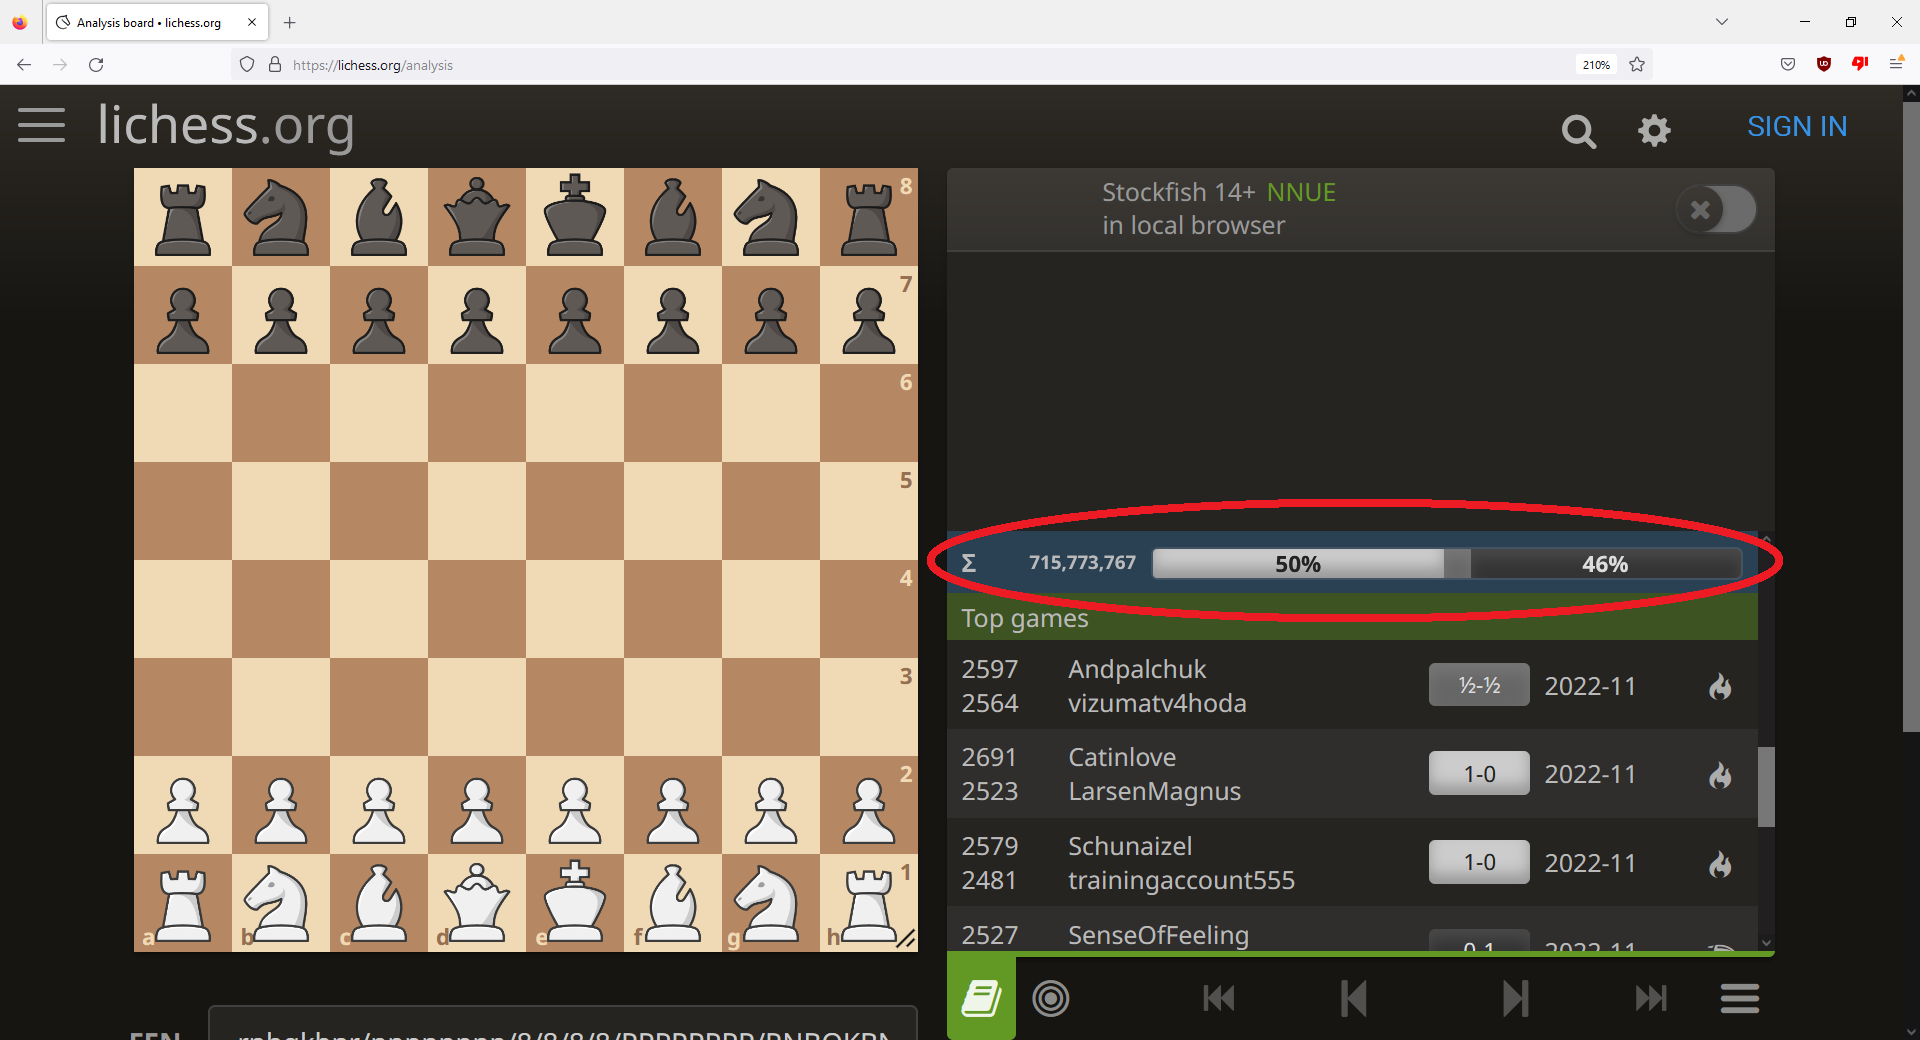

This will be a good opportunity to sanity-check the quality of our basic game attributes. 

####Frequency of game results
First, let's simply visualize the percentages of white wins, black wins, and draws. 

In [ ]:
#Query 
%%bigquery result_percentages --project cs145-f2022

SELECT Result, 
ROUND(COUNT(Result)/(
  SELECT COUNT(*) 
  FROM `cs145-f2022.project3.games_main`)*100,2
) AS percent_games
FROM `cs145-f2022.project3.games_main`
GROUP BY Result

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
result_percentages

Result  percent_games
0      1-0          49.50
1  1/2-1/2           4.09
2      0-1          46.37
3        *           0.04

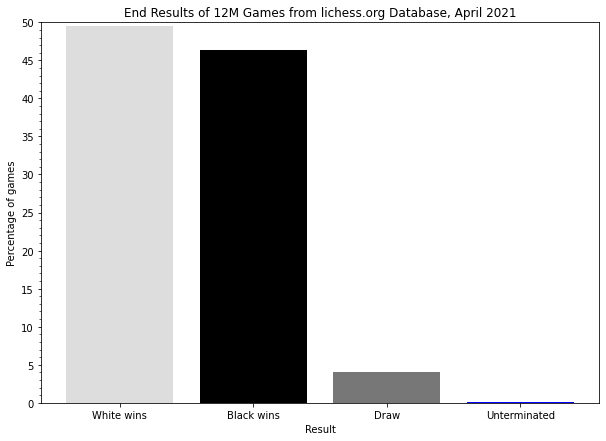

In [ ]:
#plotting/labeling - can try pie chart if extra time?
fig, ax = plt.subplots(figsize = (10, 7)) #Giant plots for language readability
ax.bar(['White wins', 'Black wins', 'Draw', 'Unterminated'], 
        result_percentages.percent_games.values[[0,2,1,3]], 
        color=['#dddddd', '#000000', '#777777', '#0000ff'])
ax.set_xlabel("Result")
ax.set_ylabel("Percentage of games")
ax.set_title("End Results of 12M Games from lichess.org Database, April 2021")

#Beautifying
ax.set_ylim([0,50])
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))

We see that overall, White wins slightly more than Black (49.5% vs 46.37% of the time); only a small number of games (\~4.1%) end in draws. There is also a very tiny percentage (0.04%) of games which have a result of "*" in the database; because it is not possible for a game to end in any other fashion, this result denotes games that have not terminated and therefore applies either toCorrespondence chess games played without a time limit, or to games where both players abandoned the game (so that there was no remaining player to claim victory or draw by abandonment). 

These percentages corroborate the current figures obtained from the lichess database across over 700 million games:


####Game results by average player rating

Here, we have our first question which gives us some strategic insight! Here, we will take the average Elo rating of the players in a game and bin it by rounding it to the nearest 100, and then visualize if the proportion of (terminated) win results appears to change across rating ranges. 

In [ ]:
#Partial query - we will do a bit of downstream processing in Pandas
%%bigquery result_by_elo --project cs145-f2022 

SELECT ROUND((WhiteElo + BlackElo)/2,-2) AS average_elo, Result, COUNT(Result) as num_games
FROM `cs145-f2022.project3.games_main`
WHERE Result <> '*'
GROUP BY average_elo, Result

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
#Processing in Pandas because of small table size; fewer issues of costly query debugging with limited credits!
result_by_elo['percent_games'] = 100 * result_by_elo.num_games / \
  result_by_elo.groupby('average_elo')['num_games'].transform('sum')
result_by_elo

average_elo   Result  num_games  percent_games
0        1800.0      0-1     547644      46.498106
1        1500.0      1-0     557868      49.642896
2        2000.0      1-0     432319      49.345513
3        1100.0      1-0     275799      49.706142
4         900.0      1-0     118500      49.614389
..          ...      ...        ...            ...
73        700.0  1/2-1/2       1688       4.321999
74        600.0  1/2-1/2        253       4.991123
75       3100.0      0-1         37      39.784946
76       3100.0      1-0         51       54.83871
77       3000.0      1-0         44      53.658537

[78 rows x 4 columns]

In [ ]:
#Examine frequency of very high-rated games
result_by_elo.loc[result_by_elo.average_elo==3000]

average_elo   Result  num_games  percent_games
18       3000.0      0-1         29      35.365854
35       3000.0  1/2-1/2          9       10.97561
77       3000.0      1-0         44      53.658537

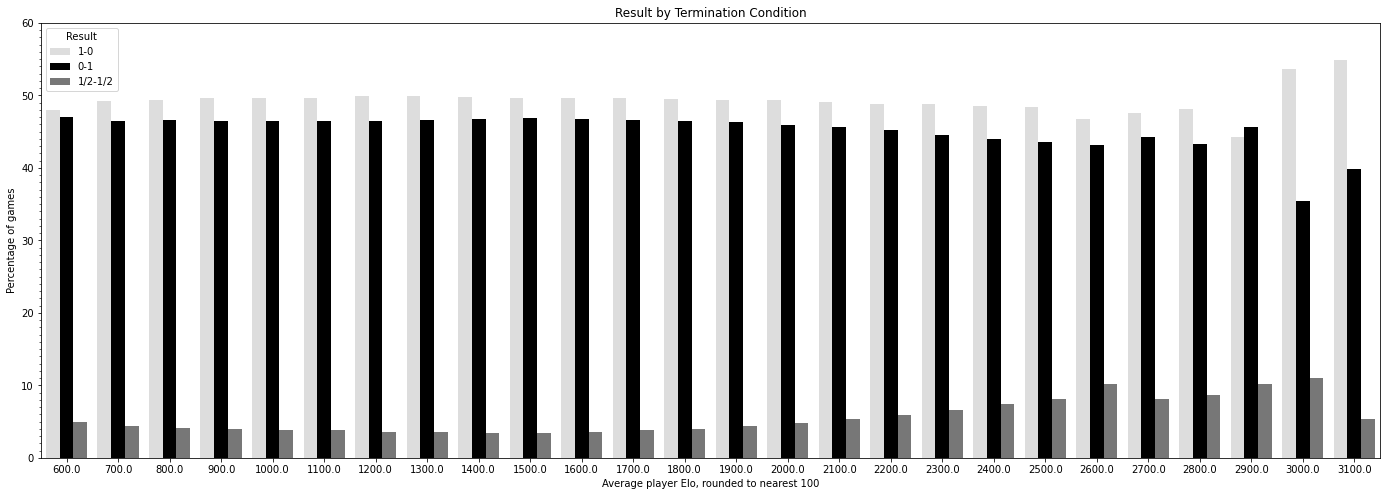

In [ ]:
fig, ax = plt.subplots(figsize = (24, 8))
sns.barplot(x = 'average_elo',       # x variable name
            y = "percent_games",       # y variable name
            hue = "Result",  # group variable name
            data = result_by_elo, # dataframe to plot
            hue_order = ['1-0', '0-1', '1/2-1/2',],
            palette = {'1-0':'#dddddd', '1/2-1/2':'#777777', 
                       '0-1':'#000000'},
            ax=ax)
ax.set_xlabel("Average player Elo, rounded to nearest 100")
ax.set_ylabel("Percentage of games")
ax.set_title("Result by Termination Condition")

#Beautifying
ax.set_ylim([0,60])
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))

In making this plot, we can identify some interesting patterns. 
* Notably, White's first move advantage is evident across all rating ranges and is reflected in slight if not always statistically-statistically significant edges in terms of win percentage; this lines up with engine evaluations as well as the general consensus from the chess community (i.e. the game is likely a theoretical draw with perfect play, but having White offers human players some actionable advantages). These trends become highly exaggerated above an average rating of 2700 (and even invert for games with an average rating of 2900), but this is likely due to very small sample sizes (just over 500 games played with an average Elo of 2900, only about 100 each for average Elo buckets of 3000 or above). There is also the covariate of time control, which in practice may affect the magnitude of the first-move advantage beyond the evaluation of the position. (We will investigate time controls more in subsequent sections.) 
* The percentage of draws has a roughly parabolic distribution; uncommon at lower ratings, reaching a low point around an average rating of 1400, and then rising as the average player rating rises towards 3000 and above. This trend corroborates previous chess wisdom; higher-skilled players are less likely to blunder bad moves and create winning chances out of theoretically drawn positions to the same degree as less-experienced players, and are thus more likely to agree to draws on the mutual knowledge that the opponent can "hold the draw". 

*Our strategic takeaway:* If we are given a choice of what color to play, we should always pick White if we want to win.

####Frequency of termination conditions
For each result (win, lose, draw), a player can claim the result in different ways - either by reaching a normal board condition such as a checkmate or threefold repetition or by non-board-related conditions such as loss on time or abandonment. Let's visualize these:

In [ ]:
#Query 
%%bigquery termination_percentages --project cs145-f2022

SELECT Termination, 
ROUND(COUNT(Termination)/(
  SELECT COUNT(*) 
  FROM `cs145-f2022.project3.games_main`)*100,2
) AS percent_games
FROM `cs145-f2022.project3.games_main`
GROUP BY Termination

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
termination_percentages

Termination  percent_games
0            Normal          68.22
1      Time forfeit          31.42
2  Rules infraction           0.01
3         Abandoned           0.34
4      Unterminated           0.01

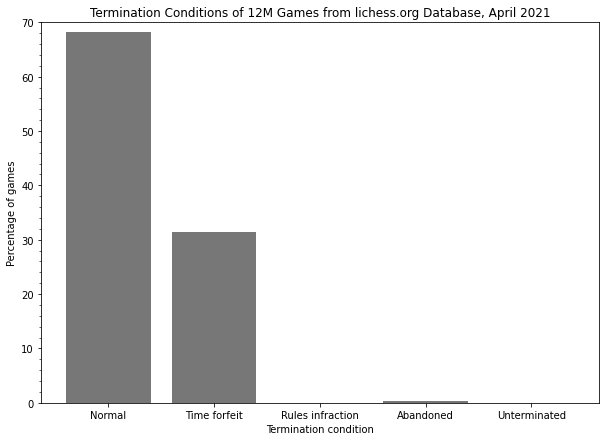

In [ ]:
#plotting/labeling - can try pie chart if extra time?
fig, ax = plt.subplots(figsize = (10, 7))
ax.bar(termination_percentages.Termination, 
        termination_percentages.percent_games, 
        color='#777777')
ax.set_xlabel("Termination condition")
ax.set_ylabel("Percentage of games")
ax.set_title("Termination Conditions of 12M Games from lichess.org Database, April 2021")

#Beautifying
ax.set_ylim([0,70])
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(2))

We see that about a bit more than two-thirds of games end (win, lose or draw) with a board result; another nearly one-third of games end on time. That leaves a very small percentage (less than 0.5%) of games which end in another fashion: 0.34% by one or both players abandoning the game, and 0.01% each for games that either never ended or that were terminated because a player was caught violating lichess TOS in the middle of a game.

####Termination conditions by color

An interesting follow-up question, although not strategically relevant - how do results and termination conditions correlate? 

In [ ]:
#Query 
%%bigquery term_by_result --project cs145-f2022

SELECT Termination, Result, 
COUNT(*) AS num_result_by_term_type
FROM `cs145-f2022.project3.games_main`
GROUP BY Termination, Result

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
#Additional processing in Pandas - cheap, over 11 rows only
term_by_result['percentage'] = 100 * term_by_result.num_result_by_term_type / \
  term_by_result.groupby('Termination')['num_result_by_term_type'].transform('sum')
term_by_result

Termination   Result  num_result_by_term_type  percentage
0             Normal      1-0                  4072080   49.740547
1             Normal  1/2-1/2                   402557    4.917243
2       Time forfeit  1/2-1/2                    88738    2.353776
3          Abandoned        *                     3176     7.74483
4          Abandoned      1-0                    17144   41.806477
5          Abandoned      0-1                    20688   50.448693
6   Rules infraction      1-0                      431   49.426606
7             Normal      0-1                  3712004   45.342211
8       Time forfeit      0-1                  1830984   48.566854
9       Time forfeit      1-0                  1850306    49.07937
10      Unterminated        *                     1451       100.0
11  Rules infraction      0-1                      441   50.573394

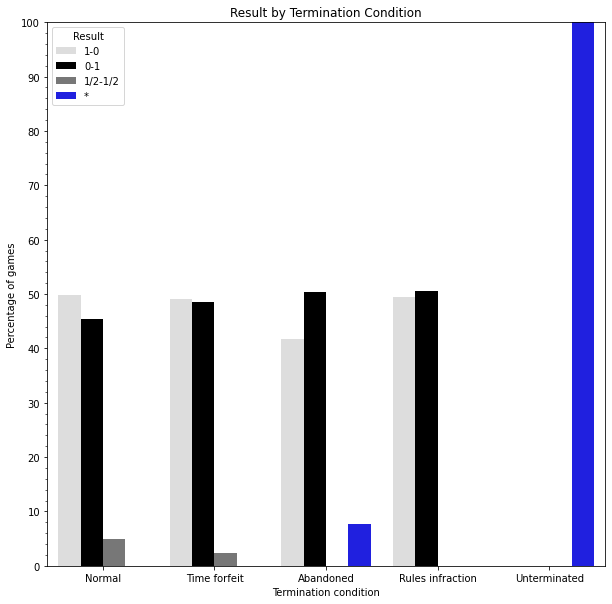

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.barplot(x = 'Termination',       # x variable name
            y = "percentage",       # y variable name
            hue = "Result",  # group variable name
            data = term_by_result, # dataframe to plot
            hue_order = ['1-0', '0-1', '1/2-1/2', '*'],
            palette = {'1-0':'#dddddd', '1/2-1/2':'#777777', 
                       '0-1':'#000000', '*':'#0000ff'},
            ax=ax)
ax.set_xlabel("Termination condition")
ax.set_ylabel("Percentage of games")
ax.set_title("Result by Termination Condition")

#Beautifying
ax.set_ylim([0,100])
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(2))

Interestingly, it seems that amongst the games that ended on the board (again, about two-thirds of all games), we see a similar proportion of white to black wins as across all games; however, the likelihood of either Black or White winning on time was more similar. Interestingly, Black is significantly more likely to be the winner amongst games where one player abandoned ($p=0$), and is slightly (but not statistically significantly, $p=0.38$) more likely to be declared the winner where the game terminates due to a rules infraction.

####Scratch work for Basic end condition queries (Remaining Queries 2)

---



In [ ]:
####Basics - how did games end?

###Query for % games won by White, Black; or drawn 


###Query for % games that ended in any of the Termination conditions above 


###Query for  # games played by "Taimanovspiano" (Bowen) in the time period between UTC 12:00:00 on April 1, 2021 to UTC 17:53:01 on April 4, 2021
# SELECT COUNT(*) AS num_games_bowen_played
# FROM `cs145-f2022.project3.games_main` 
# WHERE Black='Taimanovspiano' OR White='Taimanovspiano'

#Query for # games won by "Taimanovspiano" (Bowen) in the time period between UTC 12:00:00 on April 1, 2021 to UTC 17:53:01 on April 4, 2021
# SELECT COUNT(*) AS num_games_bowen_won
# FROM `cs145-f2022.project3.games_main` 
# WHERE (Black='Taimanovspiano' AND Result='0-1') OR (White='Taimanovspiano' AND Result='1-0')

###win rate, # games with each color, etc.



###Exploring basic opening strategies

Next, let's consider some basic questions surrounding players' opening strategies, including most and least frequent openings as well as the frequency of specific opening moves. Almost all of these questions are answerable using the lichess Analysis board interface, some more easily than with SQL alone - this is especially the case when examining the popularity or win rates of individual lines (specific sequences of moves), where lichess will show a list of opponent responses and win rates, ordered by frequency. 

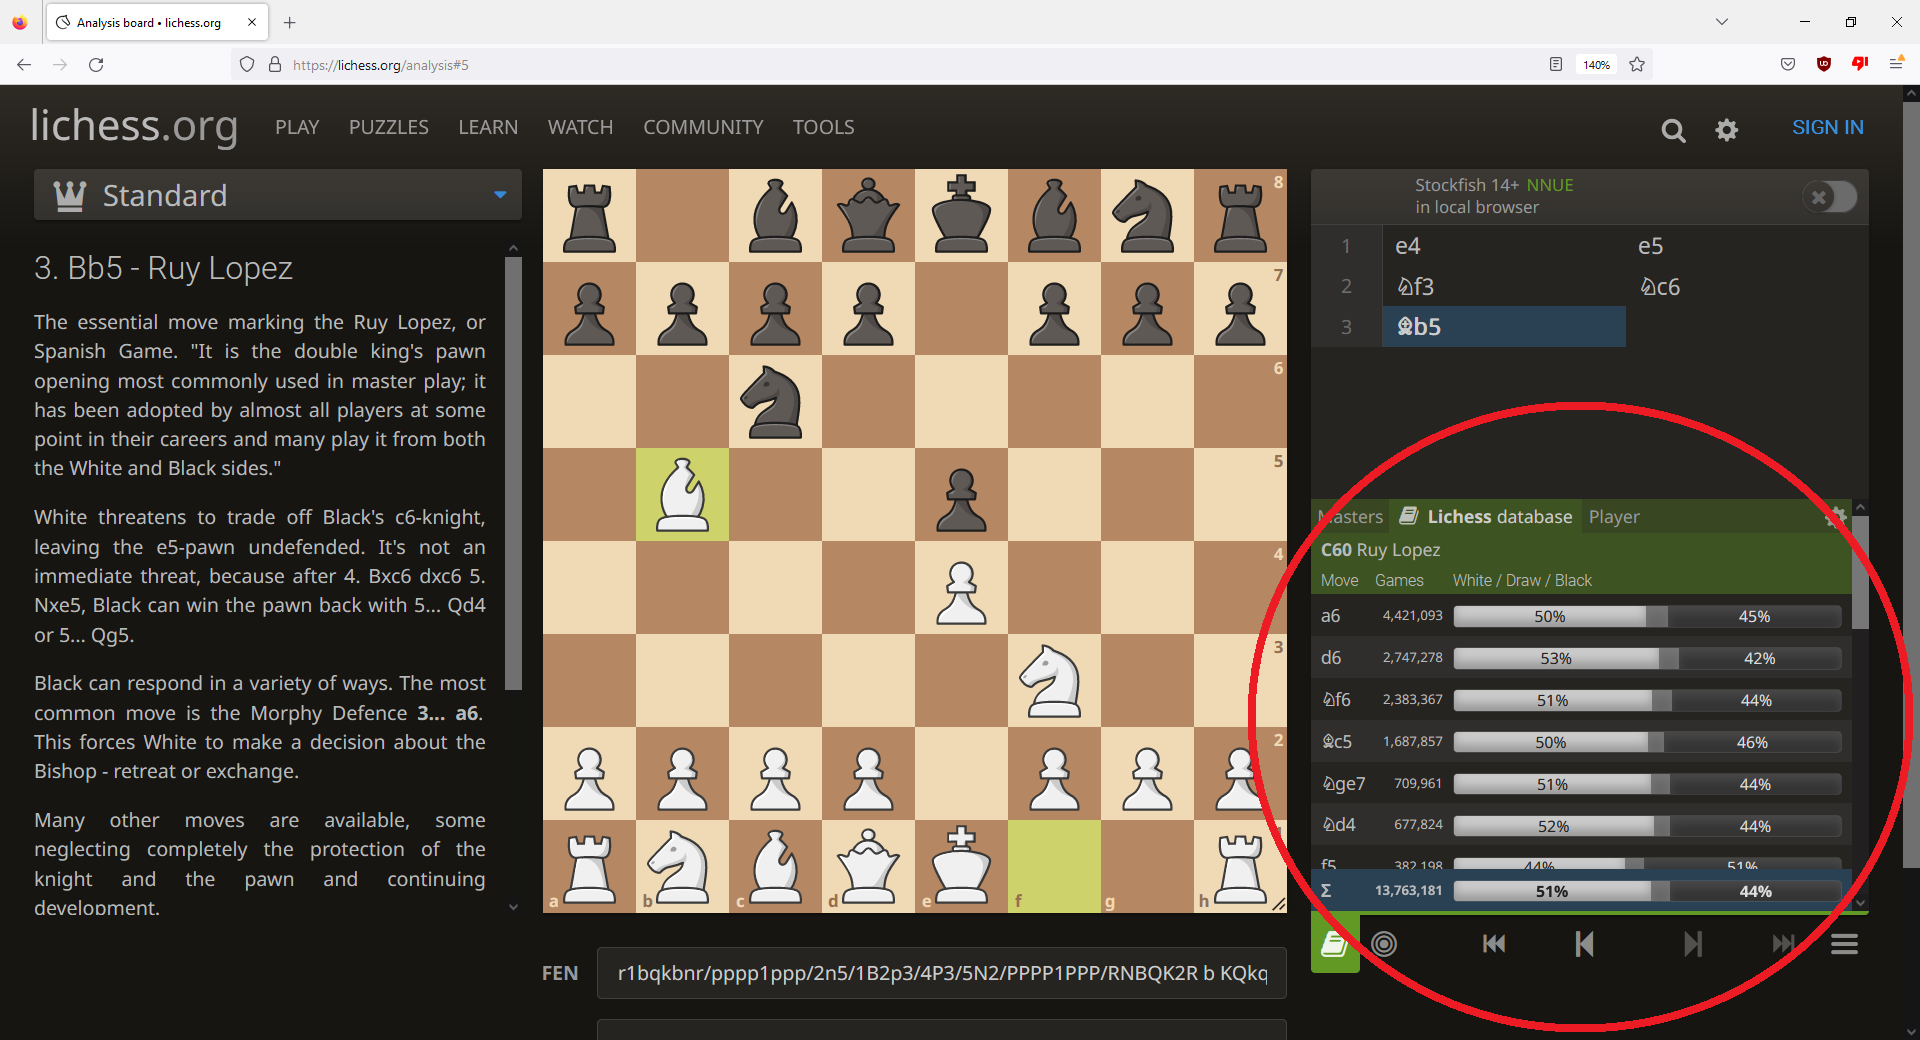

However, for comparing the overall popularity of named openings across multiple opening moves, SQL is much easier. 

####Frequency of games by ECO code
The Encyclopaedia of Chess Openings, or ECO, is a five-volume classification system which assigns every chess game a 3-character code based on specific positions reached or sequences of moves played at the beginning of games. The first character is a letter in `[A,B,C,D,E]`, followed by a two-digit number ranging from `00` to `99`. The system has some rough structure, where later numbers can refer to more specific variations (i.e. after more moves have been played) than earlier numbers, and letters group together openings that share common first moves. However, ECO codes are not mutually exclusive; rather, the most specific ECO code that can be applied to a position is used, and there exist more general ECO codes which cover dozens of unique positions that are more precisely described by child codes. The [Wikipedia page](https://en.wikipedia.org/wiki/Encyclopaedia_of_Chess_Openings) on the ECO system has more detail. 

As there are 500 ECO codes in total, let's see how many unique codes are present across all the games in our dataset before we do anything else.

In [ ]:
%%bigquery --project cs145-f2022
SELECT COUNT(*) as num_eco_codes
FROM(
  SELECT DISTINCT ECO
  FROM `cs145-f2022.project3.games_main`
)

Query is running:   0%|          |

Downloading:   0%|          |

num_eco_codes
0            496

Interestingly, despite the size of our dataset (12 million games), there are still some opening positions encoded by a total of 4 ECO codes which are never reached. 

Next, we will visualize the 10 most and least frequent openings by ECO code. 

In [ ]:
%%bigquery common_ECO --project cs145-f2022

SELECT ECO, COUNT(ECO) AS num_games
FROM `cs145-f2022.project3.games_main`
GROUP BY ECO
ORDER BY num_games DESC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
#How many games total across 10 most common ECO codes?
np.sum(common_ECO.num_games.values), np.sum(common_ECO.num_games.values)/12000000

(4772842, 0.3977368333333333)

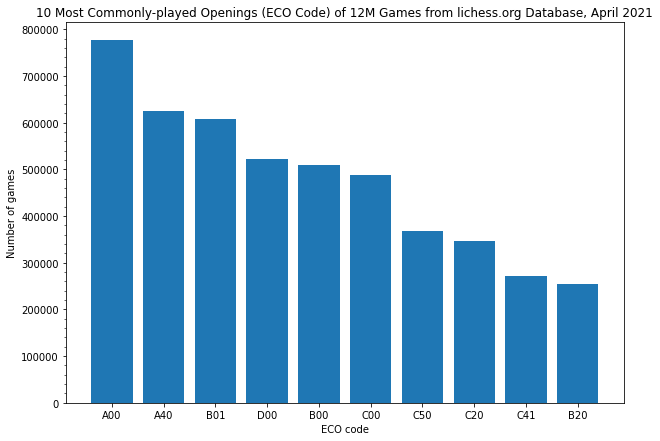

In [ ]:
#plotting/labeling
fig, ax = plt.subplots(figsize = (10, 7)) #Giant plots for language readability
ax.bar(common_ECO.ECO, common_ECO.num_games)
ax.set_xlabel("ECO code")
ax.set_ylabel("Number of games")
ax.set_title("10 Most Commonly-played Openings (ECO Code) of 12M Games from lichess.org Database, April 2021")

#Beautifying
ax.yaxis.set_minor_locator(ticker.MultipleLocator(20000))

Out of 500 possible ECO codes, the 10 most frequent codes contain 4.77 million games, or 39.77% of the games in this dataset.

The named openings corresponding to these codes are:
* A00: "Uncommon Opening" (incl. 1. g4, 1.a3, 1.h3, etc. with no later transposition to a more common position) 
* A40: "Queen's Pawn Game" (1. d4)
* B01: "Scandinavian" (1. e4 d5)
* D00: "Queen's Pawn Game" (1. d4 d5)
* B00: "Uncommon King's Pawn Opening" (incl. 1. e4 a6, 1. e4 b6, 1. e4 Nc6, etc. with no later transposition to a more common position)
* C00: "French Defence" (1. e4 e6)
* C50: "Italian Game" (1. e4 e5 2. Nf3 Nc6 3. Bc4)
* C20: "King's Pawn Game" (1. e4 e5)
* C41: "Philidor's Defence" (1. e4 e5 2. Nf3 d6)
* B20: "Sicilian Defence" (1. e4 c5)

Of these 10 codes, 4 are the most general codes possible for their respective volumes: `A00`, `B00`, `C00` and `D00` - referring to at most the first move made by both White and Black. This implies that many of these games' positions quickly deviate from the later-numbered codes which require players to make several well-studied moves in succession to be reached (i.e. are played at higher levels of chess). Additionally, the only code referring to an opening position that is reached after 3 or more moves is `C50`, the Italian game - very common and taught at all levels of chess. What this suggests is that a significant percentage of games (played by the average low-rated player on the website) do not follow established chess theory, as players quickly enter positions that professionals do not deem worth classifying or studying as their own variations. However, because of how general these codes are, they do NOT imply that the these games share even the first two or three moves in common.

How about the least frequent ECO codes? 

In [ ]:
%%bigquery rare_ECO --project cs145-f2022

SELECT ECO, COUNT(ECO) AS num_games
FROM `cs145-f2022.project3.games_main`
GROUP BY ECO
ORDER BY num_games
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
#How many games total across 10 rarest ECO codes?
np.sum(rare_ECO.num_games.values)

103

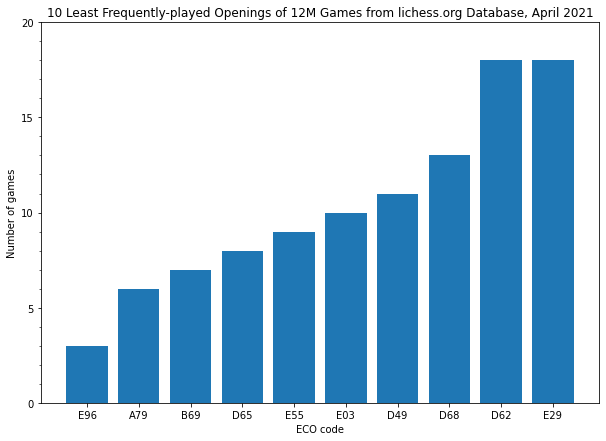

In [ ]:
#plotting/labeling
fig, ax = plt.subplots(figsize = (10, 7)) #Giant plots for language readability
ax.bar(rare_ECO.ECO, rare_ECO.num_games)
ax.set_xlabel("ECO code")
ax.set_ylabel("Number of games")
ax.set_title("10 Least Frequently-played Openings of 12M Games from lichess.org Database, April 2021")

#Beautifying
ax.set_ylim([0,20])
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))

Of the 500 possible ECO codes, the 10 least frequent codes contain only 103 games between them.

The named openings corresponding to these codes are:
* E96: "King's Indian Defence, Orthodox Main Line with 7...Nbd7" (1.d4 Nf6 2.c4 g6 3.Nc3 Bg7 4.e4 d6 5.Nf3 O-O 6.Be2 e5 7.O-O Nbd7)
* A79: "Benoni Defence, Classical with 11. f3" (1.d4 Nf6 2.c4 c5 3.d5 e6 4.Nc3 exd5 5.cxd5 d6 6.e4 g6 7.Nf3 Bg7 8.Be2 O-O 9.O-O Re8 10.Nd2 Na6 11.f3)
* B59: "Sicilian Defense, Boleslavsky Variation with 7. Nb3" (1.e4 c5 2.Nf3 Nc6 3.d4 cxd4 4.Nxd4 Nf6 5.Nc3 d6 6.Be2 e5 7.Nb3)
* D65: "Queen's Gambit Declined, Orthodox Defence, Rubenstein Attack, Main Line" (1.d4 d5 2.c4 e6 3.Nc3 Nf6 4.Bg5 Be7 5.e3 O-O 6.Nf3 Nbd7 7.Rc1 c6 8.Qc2 a6 9.cxd5)
* E55: "Nimzo-Indian Defence, Gligoric System, Bronstein Variation" (1.d4 Nf6 2.c4 e6 3.Nc3 Bb4 4.e3 O-O 5.Nf3 d5 6.Bd3 c5 7.O-O dxc4 8.Bxc4 Nbd7)
* E03: "Catalan Opening, Open, Alekhine Variation (5. Qa4 Ndb7 6. Qxc4)" (1.d4 Nf6 2.c4 e6 3.g3 d5 4.Bg2 dxc4 5.Qa4 Nbd7 6.Qxc4)
* D49: "Queen's Gambit Declined, Semi-Slav, Meran Variation" (1.d4 d5 2.c4 e6 3.Nc3 Nf6 4.Nf3 c6 5.e3 Nbd7 6.Bd3 dxc4 7.Bxc4 b5 8.Bd3 a6 9.e4 c5 10.e5 cxd4 11.Nxb5)
* D68: "Queen's Gambit Declined, Orthodox Defence, Classical Variation" (1.d4 d5 2.c4 e6 3.Nc3 Nf6 4.Bg5 Be7 5.e3 O-O 6.Nf3 Nbd7 7.Rc1 c6 8.Bd3 dxc4 9.Bxc4 Nd5 10.Bxe7 Qxe7 11.O-O Nxc3 12.Rxc3 e5)
* D62: "Queen's Gambit Declined, Orthodox Defence with 7. Qc2 c5 8. cxd5 (Rubenstein)" (1.d4 d5 2.c4 e6 3.Nc3 Nf6 4.Bg5 Be7 5.e3 O-O 6.Nf3 Nbd7 7.Qc2 c5 8.cxd5)
* E29: "Nimzo-Indian Defence, Saemisch, Main Line" (1.d4 Nf6 2.c4 e6 3.Nc3 Bb4 4.a3 Bxc3 5.bxc3 O-O 6.e3 c5 7.Bd3 Nc6)

In contrast to the most frequent ECO codes, these refer to positions that require a minimum of 6 moves to reach and as many as 12; it makes sense, therefore, that the database would contain far fewer games that share so many opening moves or positions in common. 

Through this investigation, we conclude that while ECO codes may be useful for the study and classification of games at the professional level, the unevenness of code frequency and the hierarchical nature of the codes may make them poor machine learning features to one-hot encode. Additionally, because they are most effective for classifying well-studied opening lines, they may hide a significant amount of correlation with game outcome in that the more finely-grained opening classifications are more likely to be studied and played at the top level, and therefore should intuitively offer better chances for both White and Black; clearly winning/losing lines for either color will likely fall into "other variations" or "uncommon responses" bins. 

####Distribution of ECO code frequencies 

To get a better sense of how informative our ECO codes are, let's query how many games are classified under each ECO code. The table generated by this query can be used to visualize the distribution of ECO code sizes, as well as calculate information content (IC) if we so desire. 

In [ ]:
%%bigquery eco_dist --project cs145-f2022
SELECT ECO, COUNT(ECO) as num_games
FROM `cs145-f2022.project3.games_main`
GROUP BY ECO

Query is running:   0%|          |

Downloading:   0%|          |

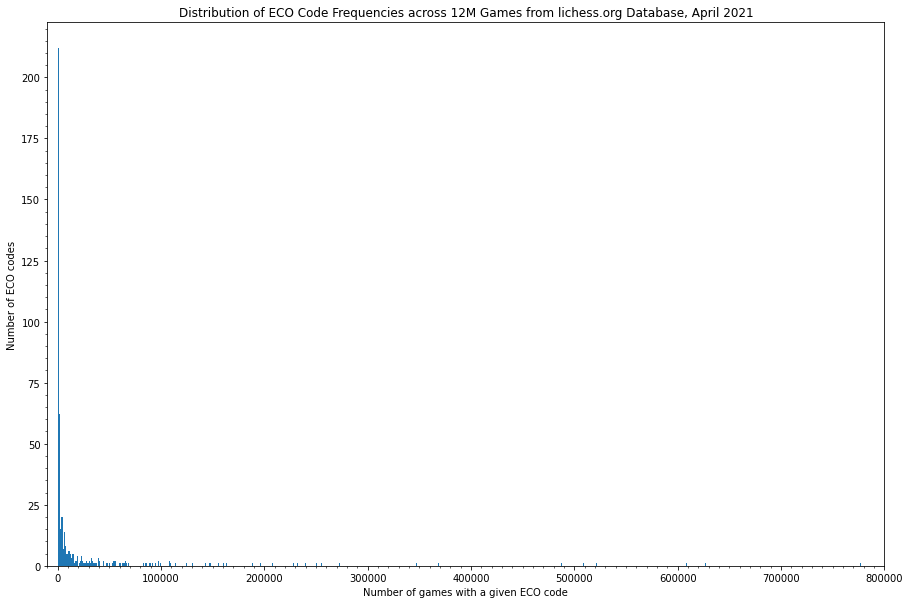

In [ ]:
bins = np.arange(0,800000,1000) #

fig, ax = plt.subplots(figsize = (15, 10)) #Giant plots for language readability
ax.hist(eco_dist.num_games, bins=bins)
ax.set_xlabel("Number of games with a given ECO code")
ax.set_ylabel("Number of ECO codes")
ax.set_title("Distribution of ECO Code Frequencies across 12M Games from lichess.org Database, April 2021")

#Beautifying
ax.set_xlim([-10000,800000])
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10000))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))

From this extraordinarily right-skewed histogram, we can see that over 200 - more than 40% - of all ECO codes contain fewer than 1000 games; only a tiny handful of ECO codes comprise 120k or more games (1% of our dataset). Therefore, if we were to train a model with ECO as an outcome (one of our ideas), we would have to find a way to handle egregious class imbalances and help the model perform well on subsets of predictions where we may only have a few hundred training examples (in contrast to others, where we may have hundreds of thousands!). 

What other methods can we use to investigate opening strategy?

####Frequency of openings by common name
All ECO codes correspond to named openings in the English language - these names may be inspired by certain [people](https://www.chess.com/openings/Sicilian-Defense-Open-Najdorf-Variation), [places](https://www.chessable.com/blog/berlin-defense/), even [animals](https://www.chess.com/forum/view/chess-openings/the-crab-opening) or [drug use](https://www.chess.com/openings/Kings-Pawn-Opening-The-Bongcloud). However, there are many named variations and subvariations which are grouped together under a single ECO code (sometimes a few cases in the reverse, where multiple ECO codes describe specific lines to a single named opening, but this is rare as these lines are usually later assigned their own names). Therefore, it's plausible that the English name of openings is a more useful proxy for opening strategy.

We begin again by counting the number of unique opening names in our dataset.

In [ ]:
%%bigquery --project cs145-f2022
SELECT COUNT(*) as num_named_openings
FROM(
  SELECT DISTINCT Opening
  FROM `cs145-f2022.project3.games_main`
)

Query is running:   0%|          |

Downloading:   0%|          |

num_named_openings
0                2896

Indeed, we have almost 6 times as many named openings as we do ECO codes! 

Which of these are most and least common? 

In [ ]:
%%bigquery common_openings --project cs145-f2022

SELECT Opening, COUNT(Opening) AS num_games
FROM `cs145-f2022.project3.games_main`
GROUP BY Opening
ORDER BY num_games DESC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
#How many games total across 10 most common named openings?
np.sum(common_openings.num_games.values), np.sum(common_openings.num_games.values)/12000000

(2192280, 0.18269)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

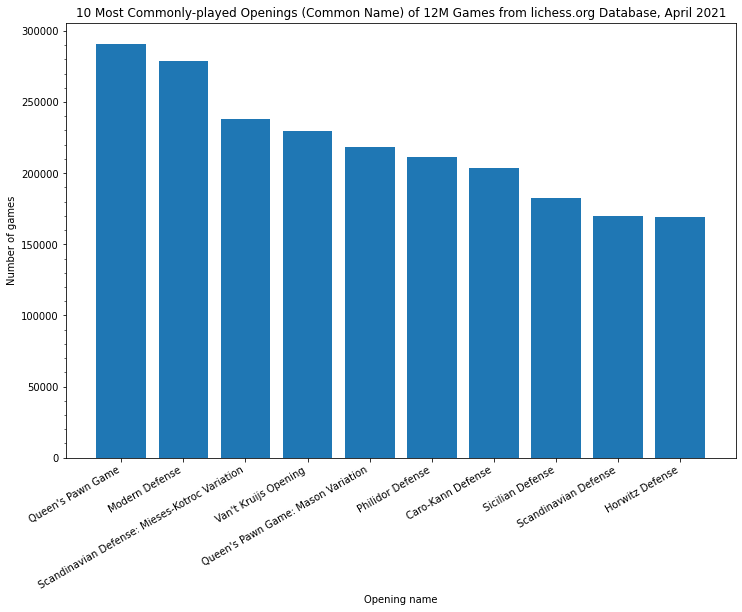

In [ ]:
#Plot
fig, ax = plt.subplots(figsize = (12, 8))
ax.bar(common_openings.Opening, common_openings.num_games)
ax.set_xlabel("Opening name")
ax.set_ylabel("Number of games")
ax.set_title("10 Most Commonly-played Openings (Common Name) of 12M Games from lichess.org Database, April 2021")

#Beautifying
ax.yaxis.set_minor_locator(ticker.MultipleLocator(10000))
plt.xticks(rotation=30, ha='right')

The 10 most frequent English-named openings contain between them about 2.19 million games, or 18.27% of the games in this dataset.

With the moves (or a set of moves that could lead to these positions):
* "Queen's Pawn Game" (1. d4)
* "Modern Defense" (1. e4 g6)
* "Scandinavian Defense: Mieses-Kotroc Variation" (1. e4 d5 2. exd5 Qxd5)
* "Van't Kruijs Opening" (1. e3 - this is Bowen's favorite!)
* "Queen's Pawn Game: Mason Variation" (1. d4 d5 2. Bf4)
* "Philidor Defense" (1. e4 e5 2. Nf3 d6)
* "Caro-Kann Defense" (1. e4 c6)
* "Sicilian Defence" (1. e4 c5)
* "Scandinavian Defense" (1. e4 d5)
* "Horwitz Defense" (1. d4 e6)

Some of these named openings such as the Scandinavian Defense and the Philidor Defense correspond directly to frequently-encountered ECO codes; however, we can already see more finely-grained distinctions in the English-naming system with a specific variation of the Scandi (games with 2...Qxd5) being more frequent than all other games with the Scandinavian Defense combined (either with a different White or Black second move). Additionally, the grab-bag ECO code of `A00` has no English-named counterpart of "all other openings" (because each is given a distinct English name), so there are no English-named openings in the top ten most frequent which correspond to several possible first moves by White like ECO `A00` does. However, we still see that there are very few multi-move openings in this list. 

Now, for the least frequent of the English-named openings:

In [ ]:
%%bigquery rare_openings --project cs145-f2022

SELECT Opening, COUNT(Opening) AS num_games
FROM `cs145-f2022.project3.games_main`
GROUP BY Opening
ORDER BY num_games
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
#How many games total across 10 most common ECO codes?
np.sum(rare_openings.num_games.values)

10

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

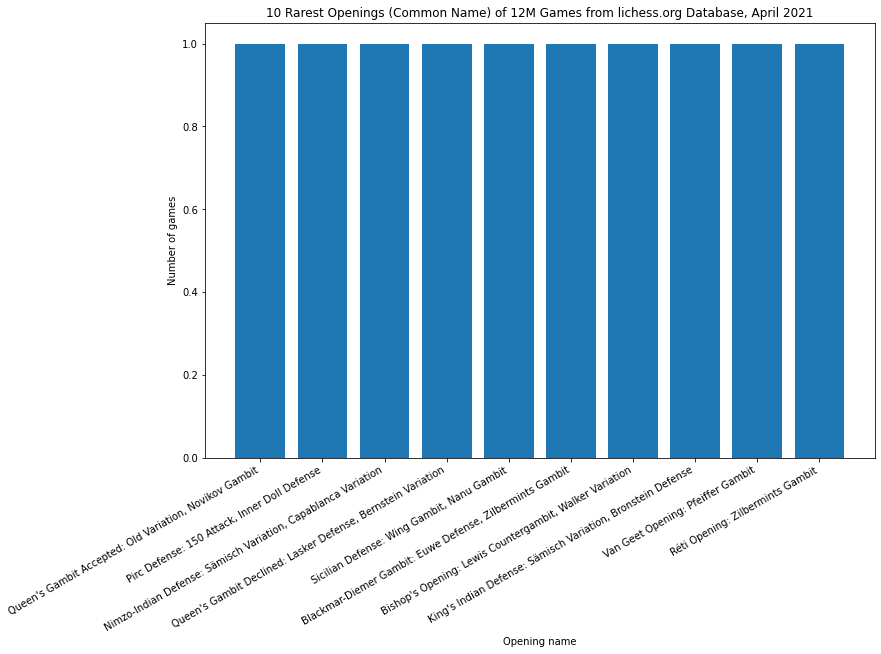

In [ ]:
#plotting/labeling - can try pie chart if extra time?
fig, ax = plt.subplots(figsize = (12, 8)) #Giant plots for language readability
ax.bar(rare_openings.Opening, rare_openings.num_games)
ax.set_xlabel("Opening name")
ax.set_ylabel("Number of games")
ax.set_title("10 Rarest Openings (Common Name) of 12M Games from lichess.org Database, April 2021")

#Beautifying
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.xticks(rotation=30, ha='right')

We can see by the resultant plot that there are at least 10 named openings that were played only once out of the 12 million games in our dataset. 

In [ ]:
%%bigquery --project cs145-f2022

SELECT COUNT(*) AS num_single_played_openings
FROM(
  SELECT Opening, COUNT(Opening) AS num_games
  FROM `cs145-f2022.project3.games_main`
  GROUP BY Opening
  HAVING num_games=1
)

Query is running:   0%|          |

Downloading:   0%|          |

num_single_played_openings
0                          84

And a follow-up query shows that there are a total of 84 such named openings that were played just once in the dataset. 

Of the ten openings plotted in the above chart, Black and White need to play an average of 13.1 plies or about 6.5 moves (7 moves by White, arriving at a position for Black to play) to reach the named position; it appears therefore that the least frequent named lines may not be as deep as for the least frequent ECO codes. Although we will not statistically test this observation, it would intuitively support the role of ECO codes for classifying deep, often high-level opening lines which is not the sole purpose of assigning opening positions an English name. 

####Distribution of English-named opening frequencies

We've seen that both the most frequent and least frequent English-named openings have a smaller game count than the corresponding most and least frequently-encountered ECO codes. How does the distribution of English-named openings compare in terms of the frequency in the overall dataset? 

In [ ]:
%%bigquery opening_dist --project cs145-f2022
SELECT Opening, COUNT(Opening) as num_games
FROM `cs145-f2022.project3.games_main`
GROUP BY Opening

Query is running:   0%|          |

Downloading:   0%|          |

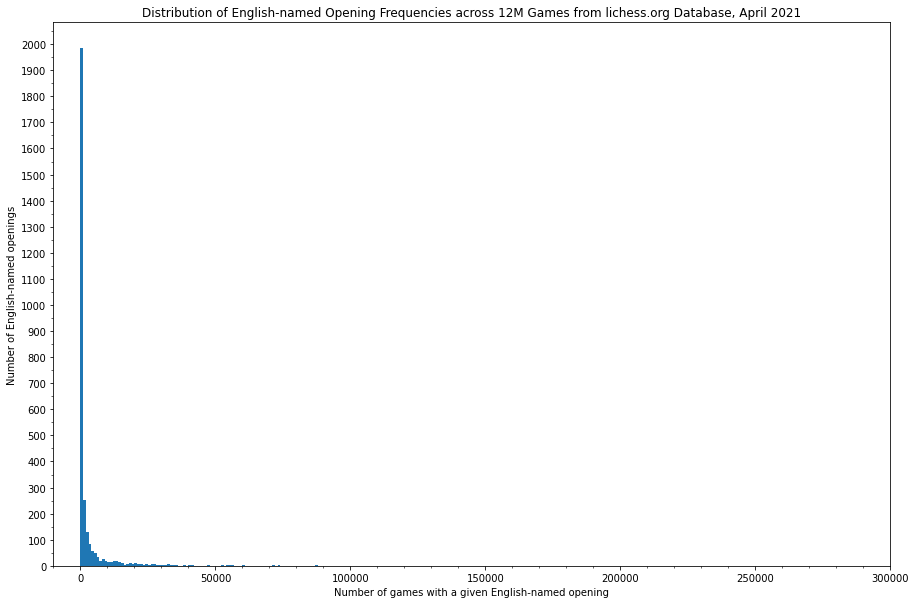

In [ ]:
bins = np.arange(0,300000,1000) #

fig, ax = plt.subplots(figsize = (15, 10)) #Giant plots for language readability
ax.hist(opening_dist.num_games, bins=bins)
ax.set_xlabel("Number of games with a given English-named opening")
ax.set_ylabel("Number of English-named openings")
ax.set_title("Distribution of English-named Opening Frequencies across 12M Games from lichess.org Database, April 2021")

#Beautifying
ax.set_xlim([-10000,300000])
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10000))
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(50))

The distribution of English-named openings across our games is similarly severely right-skewed. In this case, almost 2000 - almost 70% - of all English-named openings contain fewer than 1000 games. Keeping in mind that there is significant (although imperfect) overlap between ECO codes and English-named openings, this suggests that a very large number of games will evade finer-grained classification, simply because their openings moves start to go crazy (i.e. deviate from well-established, higher-level chess theory) very quickly - perhaps by as early as the second or third move. 

####Frequency and distribution of the first 3 moves

Later in the project, we will attempt to build a model to predict the result of a game with limited information (such as that we might gain from the first 10 seconds of watching a game). If ECO codes and named openings are not enough, can we get even more informative features by looking at the moves themselves? 

Here, we will visualize the frequencies of the 10 most common opening lines played until black's third move, as well as the distribution of the first 3 moves across all games that are at least 3 full moves long. 

In [ ]:
%%bigquery first_3_moves --project cs145-f2022

SELECT white_move1_move, black_move1_move, 
        white_move2_move, black_move2_move, 
        white_move3_move, black_move3_move, 
        COUNT(*) AS num_games
FROM `cs145-f2022.project3.games_main`
WHERE black_move3_move IS NOT NULL
GROUP BY white_move1_move, black_move1_move, 
          white_move2_move, black_move2_move, 
          white_move3_move, black_move3_move
ORDER BY num_games DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
#How many games total across 10 most common named openings?
topten_first3 = first_3_moves.iloc[:10]

np.sum(topten_first3.num_games.values), np.sum(topten_first3.num_games.values)/12000000

(1063485, 0.08862375)

In [ ]:
#How many unique 3-move opening lines are there? 
first_3_moves.shape[0]

676588

In [ ]:
#Get column names as all moves strung together
topten_first3['movelist'] = topten_first3[['white_move1_move', 'black_move1_move', 'white_move2_move', 'black_move2_move', 
                                          'white_move3_move', 'black_move3_move']].apply(lambda x: ' '.join(x), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

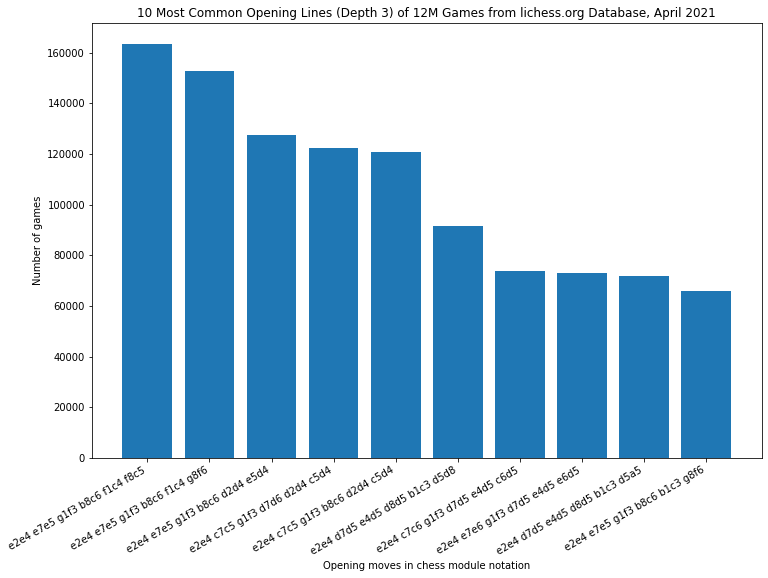

In [ ]:
#Plot
fig, ax = plt.subplots(figsize = (12, 8))
ax.bar(topten_first3.movelist, topten_first3.num_games)
ax.set_xlabel("Opening moves in chess module notation")
ax.set_ylabel("Number of games")
ax.set_title("10 Most Common Opening Lines (Depth 3) of 12M Games from lichess.org Database, April 2021")

#Beautifying
#ax.yaxis.set_minor_locator(ticker.MultipleLocator(10000))
plt.xticks(rotation=30, ha='right')

In our dataset, there are a total of 676,588 unique opening lines that are 3 moves deep. This doesn't necessarily mean that there are this many unique positions, because it is possible to reach a position through multiple move orders; however, we can quickly see how building features out of more and more moves strung together quickly becomes intractable. 

However, we do see that the top 10 depth-3 opening lines comprise a combined total of just over 1.06 million games, or about 8.86% of all games in our dataset, which is surprising in that if we randomly selected 12 games from our dataset, we would expect about one of them on average to contain an opening that matches one of these top 10 exactly - up until the 3rd move exactly. Translated from Python `chess` notation to algebraic notation with an annotated English name, these openings are:

* 1. e4 e5 2. Nf3 Nc6 3. Bc4 Bc5 - Italian Game, Giuoco Piano
* 1. e4 e5 2. Nf3 Nc6 3. Bc4 Nf6 - Italian Game, Two Knights' Defense
* 1. e4 e5 2. Nf3 Nc6 3. d4 exd4 - Scotch Game (*most common variation)
* 1. e4 c5 2. Nf3 d6 3. d4 cxd4 - Sicilian Defense, Modern Variations
* 1. e4 c5 2. Nf3 Nc6 3. d4 cxd4 - Sicilian Defense, Old Variations
* 1. e4 d5 2. exd5 Qxd5 3. Nc3 Qd8 - Scandinavian Defense, Mieses-Kotroc Variation (*queen retreating variation) 
* 1. e4 c6 2. Nf3 d5 3. exd5 cxd5 - Caro-Kann Defense, (*Knight/Exchange Variation with no 2. d4)
* 1. e4 e6 2. Nf3 d5 3. exd5 exd5 - French Defense, Knight Variation (* early exchange with no 2. d4)
* 1. e4 d5 2. exd5 Qxd5 3. Nc3 Qa5 - Scandinavian Defense, Main Line
* 1. e4 e5 2. Nf3 Nc6 3. Nc3 Nf6 - Four Knight's Game 

We see that all of the 10 most frequently-played opening lines are King's Pawn openings (starting with 1. e4). This is not unexpected and lines up with general chess consensus; 1. e4 openings tend to be more frequently played overall (especially at lower levels) and are taught to beginners more commonly. Importantly for this question, 1. e4 lines tend to be very forcing, meaning that moves must be played in a particular sequence to avoid getting a worse position. We notice that of these 10 lines, 7 involve a piece or pawn being captured; although the opponent is not obliged to recapture (they can choose to gambit material), they often must play specific moves to either rebalance material (such as an immediate recapture) or gain winning chances elsewhere, which ensures that more games follow predictable sequences of moves. Many Queen's Pawn openings (1. d4) or hypermodern openings (1. Nf3, 1. g3) are far less confrontational, so players can often perform their development in different move orders to arrive at the same board position after a certain number of moves - this phenomenon is known as transposition, and can explain why no line beginning with 1. d4 appears in this top 10 (the count of games with the exact move order, not the exact board position, after the end of 3 moves). 

What about the distribution of opening line frequencies? 

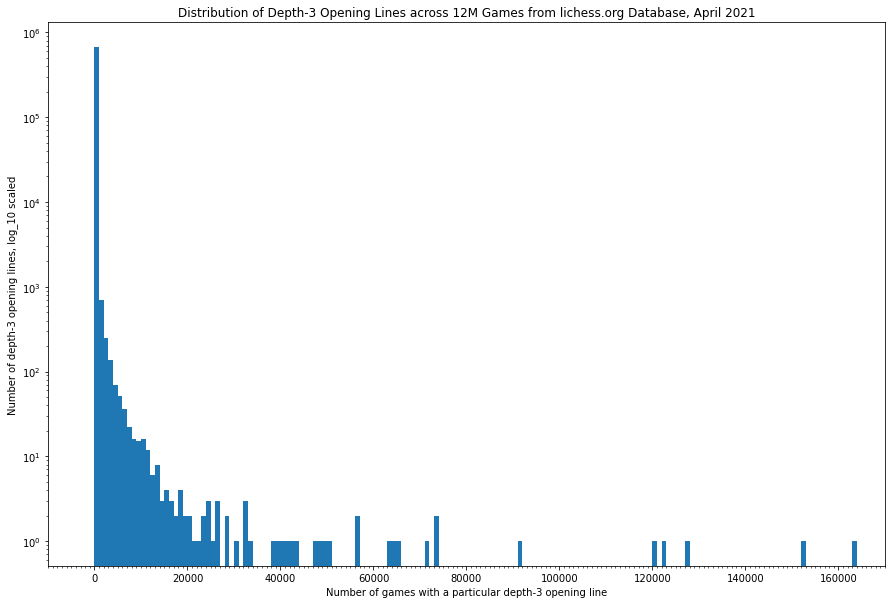

In [ ]:
bins = np.arange(0,170000,1000) #

#first_3_moves['log2_num_games'] = np.log2(first_3_moves.num_games)

fig, ax = plt.subplots(figsize = (15, 10)) #Giant plots for language readability
ax.hist(first_3_moves.num_games, bins=bins, log=True)
ax.set_xlabel("Number of games with a particular depth-3 opening line")
ax.set_ylabel("Number of depth-3 opening lines, log_10 scaled")
ax.set_title("Distribution of Depth-3 Opening Lines across 12M Games from lichess.org Database, April 2021")

#Beautifying
ax.set_xlim([-10000,170000])
ax.xaxis.set_major_locator(ticker.MultipleLocator(20000))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1000))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
# ax.yaxis.set_minor_locator(ticker.MultipleLocator(50))

Unsurprisingly, we see that a huge majority of opening lines, even for as shallow as 3 moves, are played only once in the database. 

This doesn't necessarily rule out the utility of moves as features, however - more complex machine learning models like fully-connected neural networks might be able to learn the interaction between certain moves that are played in certain orders (handling the issue of opening transpositions) such that we don't have to worry about the limited number of training examples that share specific opening move orders. 

####Scratch work for basic chess opening queries

In [ ]:
#Basics for strategy - what do people play? (This data can be obtained/inferred from lichess visual interface)

#Query for most and least frequent openings (ECO and/or Opening attribute)
#Query for most and least frequent opening 2/3 moves (check that moves are not NULL!)

###Exploring opening choice and game results as a function of other attributes

Now, let's start combining the above two areas of inquiry, to start getting a better sense of how player strength, strategies and playing style interact with and potentially influence the distribution of results. We'll begin with a few queries treating result type as a function of game duration (by time and number of moves). Then, we'll look at opening distribution as a function of game length (time and number of moves) and average player Elo. 

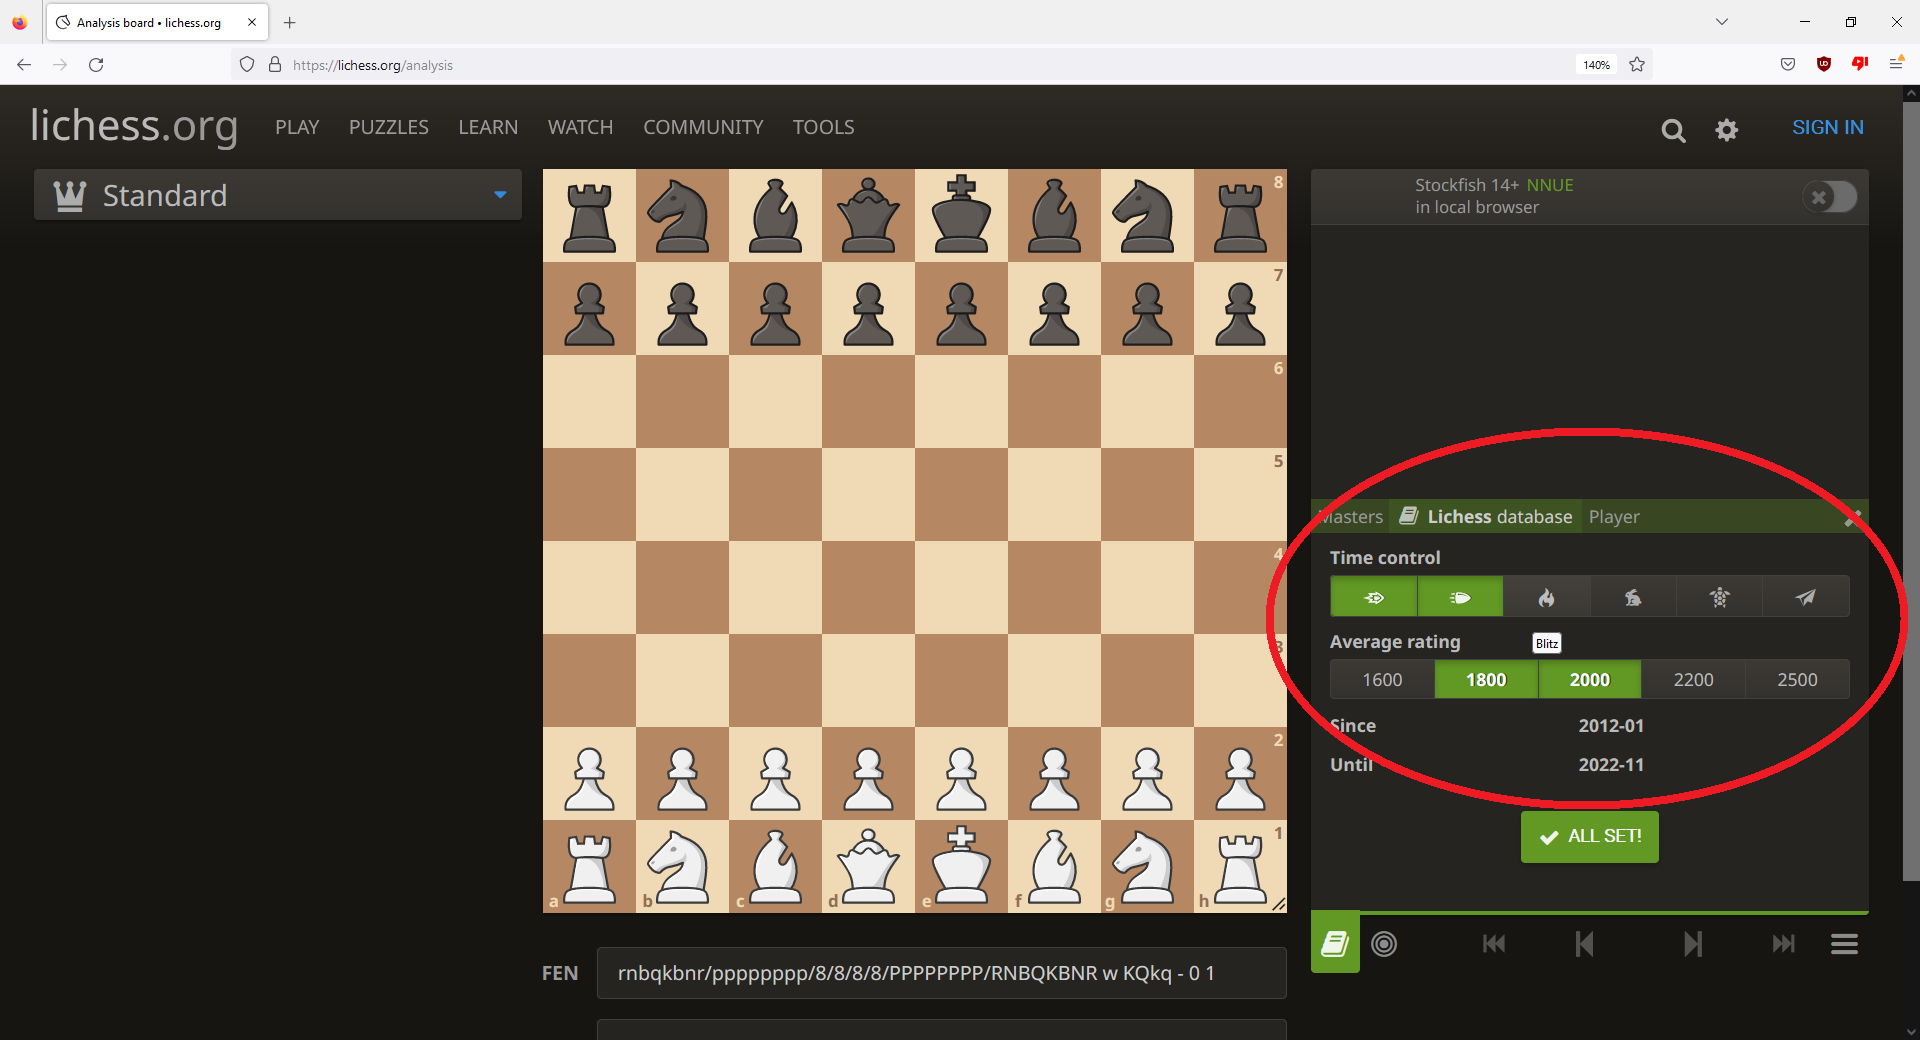

Although there are ways to obtain answers to many of these questions with game duration and average player Elo filters in the lichess interface, some of the queries in this session begin to necessitate SQL, and it certainly helps for all queries to gather and present data neatly. 

####Result as a function of time control 

First, let's investigate if certain time formats are biased towards White or Black. 


In [ ]:
#Query 
%%bigquery result_by_timecontrol --project cs145-f2022

SELECT 
CASE WHEN CONTAINS_SUBSTR(Event, 'ultrabullet') THEN "UltraBullet"
  WHEN CONTAINS_SUBSTR(Event, 'bullet') THEN "Bullet"
  WHEN CONTAINS_SUBSTR(Event, 'blitz') THEN "Blitz"
  WHEN CONTAINS_SUBSTR(Event, 'rapid') THEN "Rapid"
  WHEN CONTAINS_SUBSTR(Event, 'classical') THEN "Classical"
  WHEN CONTAINS_SUBSTR(Event, 'correspondence') THEN "Correspondence"
  ELSE "Other"
END AS time_control_type, Result, COUNT(*) as num_games
FROM `cs145-f2022.project3.games_main`
GROUP BY time_control_type, Result

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
#Additional processing in Pandas - cheap, over 11 rows only
result_by_timecontrol['percentage'] = 100 * result_by_timecontrol.num_games / \
  result_by_timecontrol.groupby('time_control_type')['num_games'].transform('sum')

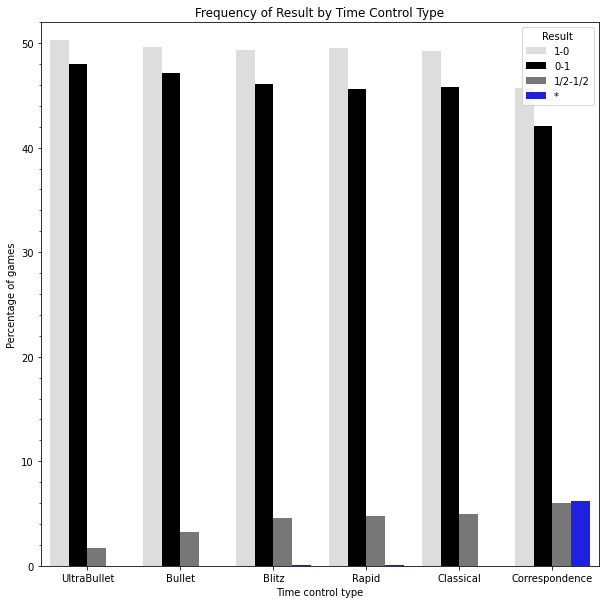

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.barplot(x = 'time_control_type',       # x variable name
            y = "percentage",       # y variable name
            hue = "Result",  # group variable name
            data = result_by_timecontrol, # dataframe to plot
            order = ['UltraBullet', 'Bullet', 'Blitz', 'Rapid', 'Classical', 'Correspondence'],
            hue_order = ['1-0', '0-1', '1/2-1/2', '*'],
            palette = {'1-0':'#dddddd', '1/2-1/2':'#777777', 
                       '0-1':'#000000', '*':'#0000ff'},
            ax=ax)
ax.set_xlabel("Time control type")
ax.set_ylabel("Percentage of games")
ax.set_title("Frequency of Result by Time Control Type")

#Beautifying
ax.set_ylim([0,52])
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(2))

* White maintains first-move advantage in all time formats 
* Proportion of draws increases as time duration increases 
* Black win percentage decreases as time duration increases

####Game length as a function of time control 

As a quick aside, let's investigate how time control affects the average length of games (in number of moves). 

In [ ]:
#Query - randomly sample ~1% of games to plot distributions
%%bigquery gamelength_by_timecontrol --project cs145-f2022

SELECT 
CASE WHEN CONTAINS_SUBSTR(Event, 'ultrabullet') THEN "UltraBullet"
  WHEN CONTAINS_SUBSTR(Event, 'bullet') THEN "Bullet"
  WHEN CONTAINS_SUBSTR(Event, 'blitz') THEN "Blitz"
  WHEN CONTAINS_SUBSTR(Event, 'rapid') THEN "Rapid"
  WHEN CONTAINS_SUBSTR(Event, 'classical') THEN "Classical"
  WHEN CONTAINS_SUBSTR(Event, 'correspondence') THEN "Correspondence"
  ELSE "Other"
END AS time_control_type, Ply/2 as num_moves
FROM `cs145-f2022.project3.games_main`
ORDER BY RAND()
LIMIT 100000

Query is running:   0%|          |

Downloading:   0%|          |

Text(0.5, 1.0, 'Distributions of Game Length by Time Control Type')

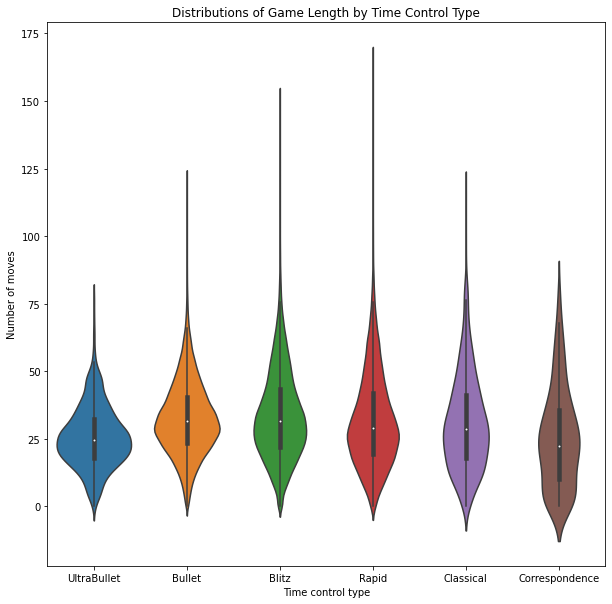

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.violinplot(x = 'time_control_type',       # x variable name
            y = "num_moves",       # y variable name
            data = gamelength_by_timecontrol, # dataframe to plot
            order = ['UltraBullet', 'Bullet', 'Blitz', 'Rapid', 'Classical', 'Correspondence'],
            ax=ax)
ax.set_xlabel("Time control type")
ax.set_ylabel("Number of moves")
ax.set_title("Distributions of Game Length by Time Control Type")

#Beautifying
# ax.set_ylim([0,52])
# ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
# ax.yaxis.set_minor_locator(ticker.MultipleLocator(2))

As expected, ultrabullet games are quite short; but an interesting parabolic trend in game length vs time control.

####Remaining Queries

In [ ]:
#Remaining Queries to do:

#Win rate by game length (round to nearest 10 moves)

#Most frequent openings by Time control (start time)

#Most frequent openings in Bullet with/without increment (logic for this one - safer openings to premove to gain/save time)

#Most Frequent openings by game length 

#Most frequent openings by player Elo? (bifurcate on Black and White)

#Most Frequent openings by Elo difference btwn players (bifurcate on Black and White)

#Openings in tournaments vs casual play?

#Frequency of Openings

Here we will explore the frequency of openings (ECO codes) depending on the following conditions:

*   time control (StartTime)
*   in the Bullet mode with and without Increments
*   game length (number of moves)
*   Black Elo (who receives the opening move)
*   White Elo (who makes the opening move)
*   Elo difference for Black
*   Elo difference for White
*   casual play v. tournament play









First let's look at how StartTime (amount of time each player starts the game with in seconds) affects the types and frequency of ECO codes (opening moves) 

We'll start with the lowest allotted StartTime -- 60 seconds

In [ ]:
#Query for ECO and frequency by StartTime=60
%%bigquery start_60_eco_bar --project cs145-f2022

SELECT StartTime, ECO, COUNT(ECO) as num_times_eco_appears_for_startTime
FROM `cs145-f2022.project3.games_main`
WHERE StartTime=60.0
GROUP BY StartTime, ECO
ORDER BY COUNT(ECO) DESC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

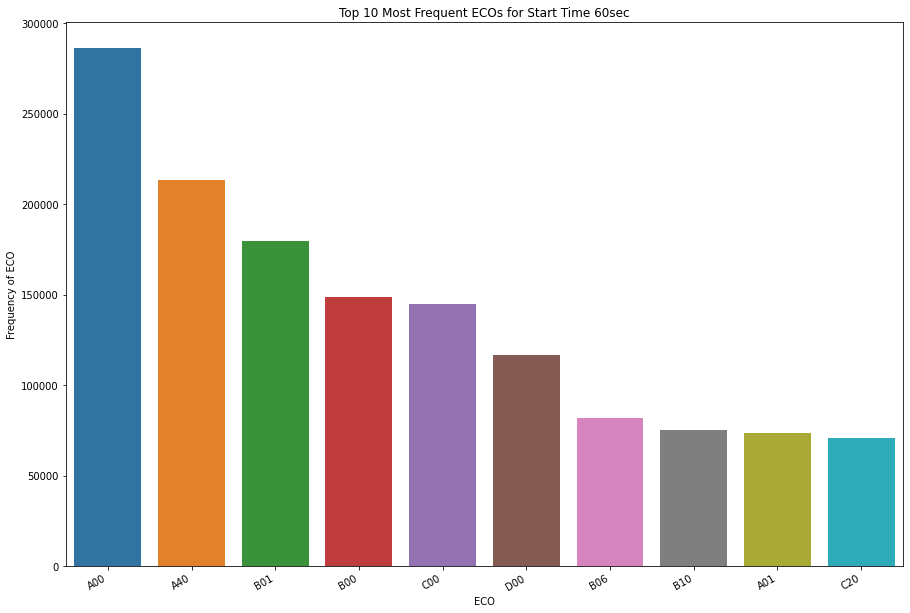

In [ ]:
fig, ax = plt.subplots(figsize = (15, 10))

#Cheap to re-type for visualization - very few columns
start_60_eco_bar['num_times_eco_appears_for_startTime'] = start_60_eco_bar.num_times_eco_appears_for_startTime.astype('int')

sns.barplot(x = 'ECO',       # x variable name
            y = "num_times_eco_appears_for_startTime",       # y variable name
            data = start_60_eco_bar, # dataframe to plot
            ax=ax)
ax.set_xlabel("ECO")
ax.set_ylabel("Frequency of ECO")
ax.set_title("Top 10 Most Frequent ECOs for Start Time 60sec")

#Beautifying
# ax.set_ylim([0,100])
# ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
# ax.yaxis.set_minor_locator(ticker.MultipleLocator(2))
plt.xticks(rotation=30, ha='right')

Now let's look at the highest allotted time - 10800s or 180mins or 3 hours

In [ ]:
#Query for ECO and frequency by StartTime=10800
%%bigquery start_10800_eco_bar --project cs145-f2022

SELECT StartTime, ECO, COUNT(ECO) as num_times_eco_appears_for_startTime
FROM `cs145-f2022.project3.games_main`
WHERE StartTime=10800.0
GROUP BY StartTime, ECO
ORDER BY COUNT(ECO) DESC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

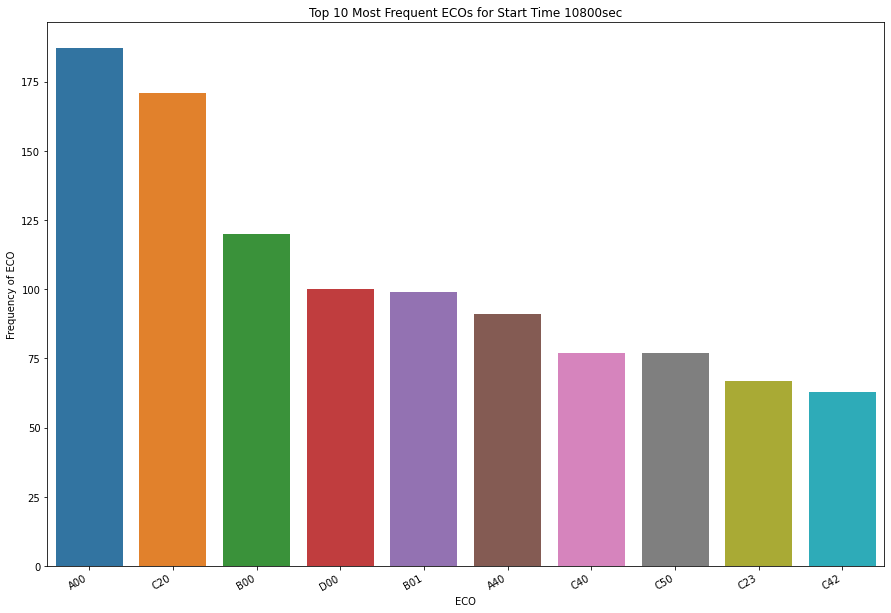

In [ ]:
fig, ax = plt.subplots(figsize = (15, 10))

#Cheap to re-type for visualization - very few columns
start_10800_eco_bar['num_times_eco_appears_for_startTime'] = start_10800_eco_bar.num_times_eco_appears_for_startTime.astype('int')

sns.barplot(x = 'ECO',       # x variable name
            y = "num_times_eco_appears_for_startTime",       # y variable name
            data = start_10800_eco_bar, # dataframe to plot
            ax=ax)
ax.set_xlabel("ECO")
ax.set_ylabel("Frequency of ECO")
ax.set_title("Top 10 Most Frequent ECOs for Start Time 10800sec")

#Beautifying
# ax.set_ylim([0,100])
# ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
# ax.yaxis.set_minor_locator(ticker.MultipleLocator(2))
plt.xticks(rotation=30, ha='right')

Finally, let's look at a visualization of a query that returns to us the MOST frequent ECO codes and their counts for EACH StartTime

In [ ]:
#Query for most frequent ECO for every StartTime
%%bigquery all_start_eco_bar --project cs145-f2022

SELECT t1.StartTime, t1.ECO, t2.max_occur
FROM (
  SELECT StartTime, ECO, COUNT(ECO) as num_times_eco_appears_for_startTime
  FROM `cs145-f2022.project3.games_main`
  GROUP BY StartTime, ECO
  ORDER BY StartTime, COUNT(ECO) DESC
) t1
INNER JOIN (
  SELECT StartTime, MAX(num_times_eco_appears_for_startTime) AS max_occur
FROM (
    SELECT StartTime, ECO, COUNT(ECO) as num_times_eco_appears_for_startTime
  FROM `cs145-f2022.project3.games_main`
  GROUP BY StartTime, ECO
  ORDER BY StartTime, COUNT(ECO) DESC
)
GROUP BY StartTime
ORDER BY StartTime DESC
) t2 
ON t1.StartTime=t2.startTime
AND t1.num_times_eco_appears_for_startTime=t2.max_occur
WHERE t2.max_occur > 5000
ORDER BY t1.StartTime ASC

Query is running:   0%|          |

Downloading:   0%|          |

Text(0.5, 1.0, 'Most Frequent ECO codes and the counts by StartTime (only including frequencies above 5,000)')

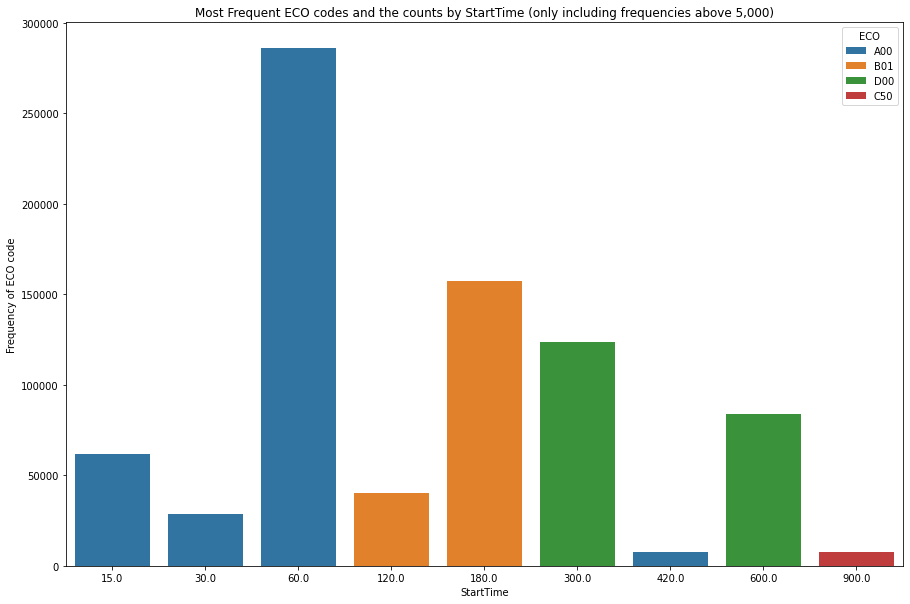

In [ ]:
fig, ax = plt.subplots(figsize = (15, 10))

#Cheap to re-type for visualization - very few columns
all_start_eco_bar['max_occur'] = all_start_eco_bar.max_occur.astype('int')

sns.barplot(x = 'StartTime',       # x variable name
            y = "max_occur",       # y variable name
            hue = "ECO",  # group variable name
            data = all_start_eco_bar, # dataframe to plot
            ax=ax,
            dodge=False)
ax.set_xlabel("StartTime")
ax.set_ylabel("Frequency of ECO code")
ax.set_title("Most Frequent ECO codes and the counts by StartTime (only including frequencies above 5,000)")

### Interesting Observations
*   ECO Opening ***A00*** is consistently ***the most popular opening*** btwn the lowest and highest allotted start times
*   ***C20*** is the ***10th*** most popular opening for start time ***60s***, but it is the ***2nd*** most popular opening for start time ***10800s***
*   ***A40*** is the ***2nd*** most popular opening for start time ***60s***, but it is the ***6th*** most popular opening for start time ***10800s***
*   For ECO frequencies above 5000 among StartTimes, A00 is most frequent, followed by D00 then B01







Second, we'll look at the frequency of ECO openings in the Bullet game mode based on Intervals (or lack thereof)

In [ ]:
#Query for ECO and frequency by Bullet Mode Interval
%%bigquery bullet_0_eco_bar --project cs145-f2022

SELECT ECO, COUNT(ECO) AS freq_of_eco_for_this_bullet_increment
FROM `cs145-f2022.project3.games_main`
WHERE CONTAINS_SUBSTR(Event, 'bullet') 
AND NOT CONTAINS_SUBSTR(Event, 'ultrabullet')
AND Increment = 0.0
GROUP BY ECO, Increment
ORDER BY COUNT(ECO) DESC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

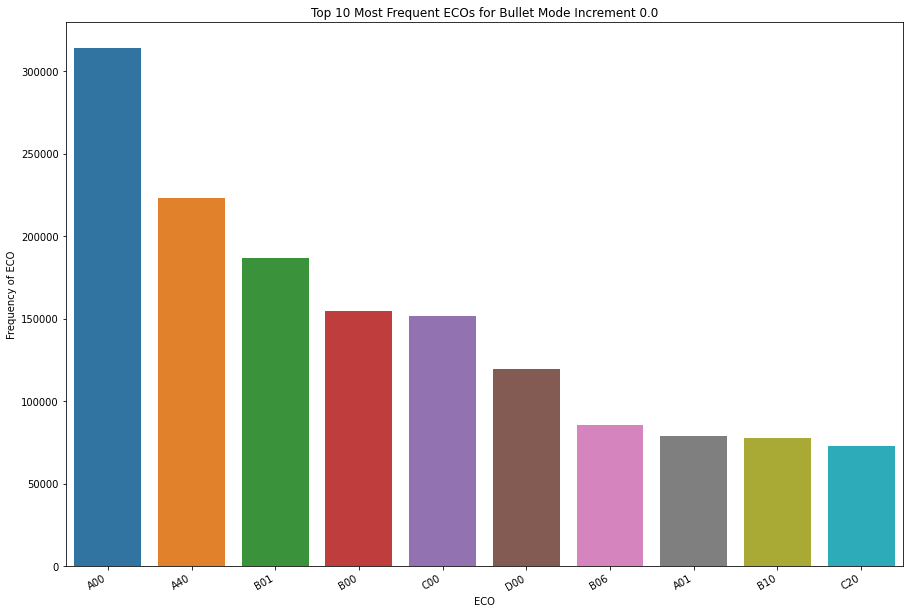

In [ ]:
fig, ax = plt.subplots(figsize = (15, 10))

#Cheap to re-type for visualization - very few columns
bullet_0_eco_bar['freq_of_eco_for_this_bullet_increment'] = bullet_0_eco_bar.freq_of_eco_for_this_bullet_increment.astype('int')

sns.barplot(x = 'ECO',       # x variable name
            y = "freq_of_eco_for_this_bullet_increment",       # y variable name
            data = bullet_0_eco_bar, # dataframe to plot
            ax=ax)
ax.set_xlabel("ECO")
ax.set_ylabel("Frequency of ECO")
ax.set_title("Top 10 Most Frequent ECOs for Bullet Mode Increment 0.0")

plt.xticks(rotation=30, ha='right')

Now let's look at the other end of the spectrum, Increment 4.0

In [ ]:
#Query for ECO and frequency by Bullet Mode Interval
%%bigquery bullet_4_eco_bar --project cs145-f2022

SELECT ECO, COUNT(ECO) AS freq_of_eco_for_this_bullet_increment
FROM `cs145-f2022.project3.games_main`
WHERE CONTAINS_SUBSTR(Event, 'bullet') 
AND NOT CONTAINS_SUBSTR(Event, 'ultrabullet')
AND Increment = 4.0
GROUP BY ECO, Increment
ORDER BY COUNT(ECO) DESC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

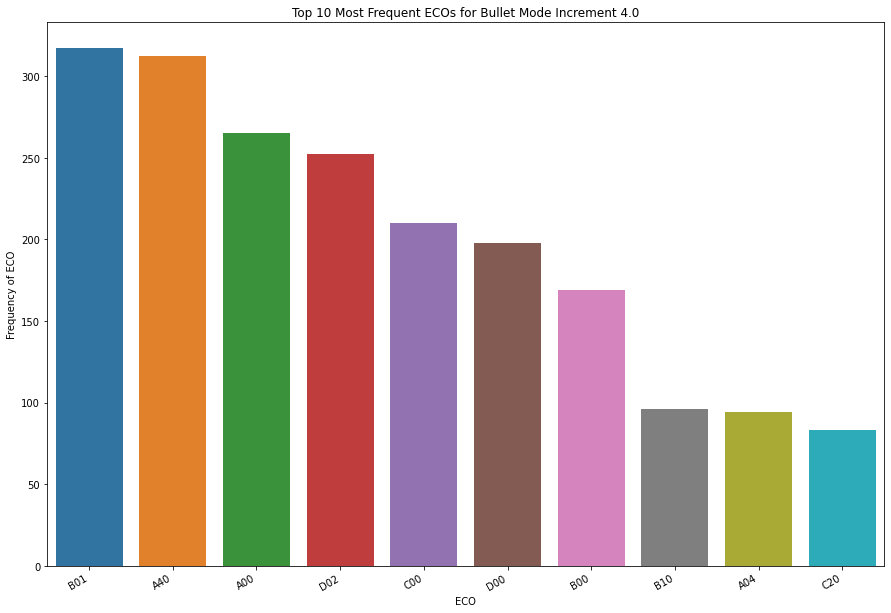

In [ ]:
fig, ax = plt.subplots(figsize = (15, 10))

#Cheap to re-type for visualization - very few columns
bullet_4_eco_bar['freq_of_eco_for_this_bullet_increment'] = bullet_4_eco_bar.freq_of_eco_for_this_bullet_increment.astype('int')

sns.barplot(x = 'ECO',       # x variable name
            y = "freq_of_eco_for_this_bullet_increment",       # y variable name
            data = bullet_4_eco_bar, # dataframe to plot
            ax=ax)
ax.set_xlabel("ECO")
ax.set_ylabel("Frequency of ECO")
ax.set_title("Top 10 Most Frequent ECOs for Bullet Mode Increment 4.0")

plt.xticks(rotation=30, ha='right')

Now let's look at the most frequent ECO and its count for EACH Bullet Mode Increment (0.0, 1.0, 2.0, 3.0, 4.0)

In [ ]:
#Query for most frequent ECO for every Increment
%%bigquery all_increment_eco_bar --project cs145-f2022

SELECT t1.Increment, t1.ECO, t2.max_occur
FROM (
  SELECT Increment, ECO, COUNT(ECO) AS freq_of_eco_for_this_bullet_increment
  FROM `cs145-f2022.project3.games_main`
  WHERE CONTAINS_SUBSTR(Event, 'bullet') 
  AND NOT CONTAINS_SUBSTR(Event, 'ultrabullet')
  GROUP BY ECO, Increment
  ORDER BY COUNT(ECO) DESC
) t1
INNER JOIN (
  SELECT Increment, MAX(freq_of_eco_for_this_bullet_increment) AS max_occur
FROM (
    SELECT Increment, ECO, COUNT(ECO) AS freq_of_eco_for_this_bullet_increment
    FROM `cs145-f2022.project3.games_main`
    WHERE CONTAINS_SUBSTR(Event, 'bullet') 
    AND NOT CONTAINS_SUBSTR(Event, 'ultrabullet')
    GROUP BY ECO, Increment
    ORDER BY Increment, COUNT(ECO) DESC
)
GROUP BY Increment
ORDER BY Increment DESC
) t2 
ON t1.Increment=t2.Increment
AND t1.freq_of_eco_for_this_bullet_increment=t2.max_occur
ORDER BY t1.Increment ASC

Query is running:   0%|          |

Downloading:   0%|          |

Text(0.5, 1.0, 'Most Frequent ECO codes and the counts by Bullet Mode Increment')

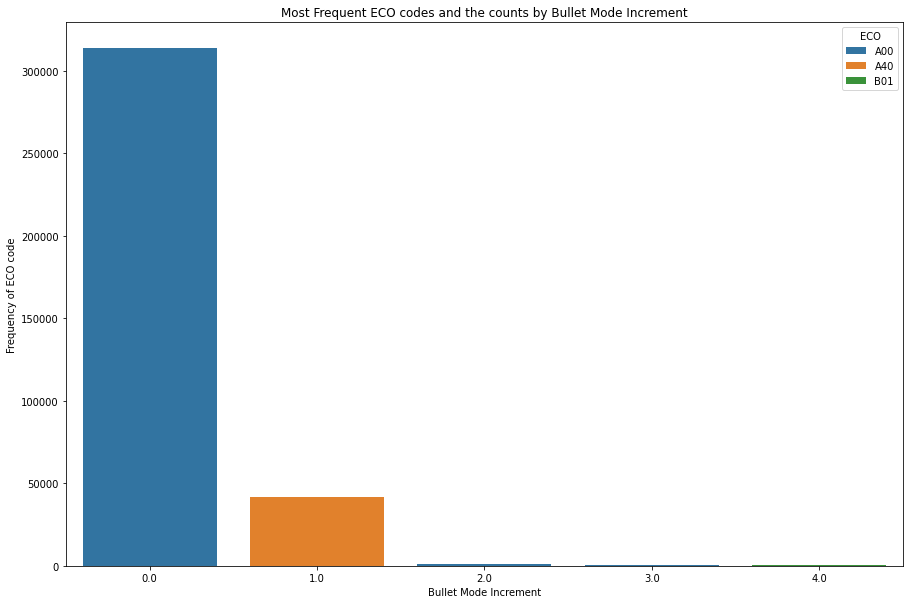

In [ ]:
fig, ax = plt.subplots(figsize = (15, 10))

#Cheap to re-type for visualization - very few columns
all_increment_eco_bar['max_occur'] = all_increment_eco_bar.max_occur.astype('int')

sns.barplot(x = 'Increment',       # x variable name
            y = "max_occur",       # y variable name
            hue = "ECO",  # group variable name
            data = all_increment_eco_bar, # dataframe to plot
            ax=ax,
            dodge=False)
ax.set_xlabel("Bullet Mode Increment")
ax.set_ylabel("Frequency of ECO code")
ax.set_title("Most Frequent ECO codes and the counts by Bullet Mode Increment")

### Frequency of ECO Opening by Game Length (num of moves)



In [ ]:
#Query for most frequent ECO for every game length w freq > 5000
%%bigquery all_game_length_eco_bar --project cs145-f2022

SELECT t1.game_length, t1.ECO, t2.max_occur
FROM (
      SELECT Round(Ply / 10) * 10 AS game_length, ECO, COUNT(ECO) AS freq_eco_by_game_length
    FROM `cs145-f2022.project3.games_main`
    GROUP BY game_length, ECO
    ORDER BY freq_eco_by_game_length DESC
) t1
INNER JOIN (
  SELECT game_length, MAX(freq_eco_by_game_length) AS max_occur
FROM (
    SELECT Round(Ply / 10) * 10 AS game_length, ECO, COUNT(ECO) AS freq_eco_by_game_length
    FROM `cs145-f2022.project3.games_main`
    GROUP BY game_length, ECO
    ORDER BY freq_eco_by_game_length DESC
)
GROUP BY game_length
ORDER BY game_length DESC
) t2 
ON t1.game_length=t2.game_length
AND t1.freq_eco_by_game_length=t2.max_occur
WHERE t2.max_occur>5000
ORDER BY t1.game_length ASC

Query is running:   0%|          |

Downloading:   0%|          |

Text(0.5, 1.0, 'Most Frequent ECO codes and the counts by Game Length (limited to max ECO occurrences > 5000')

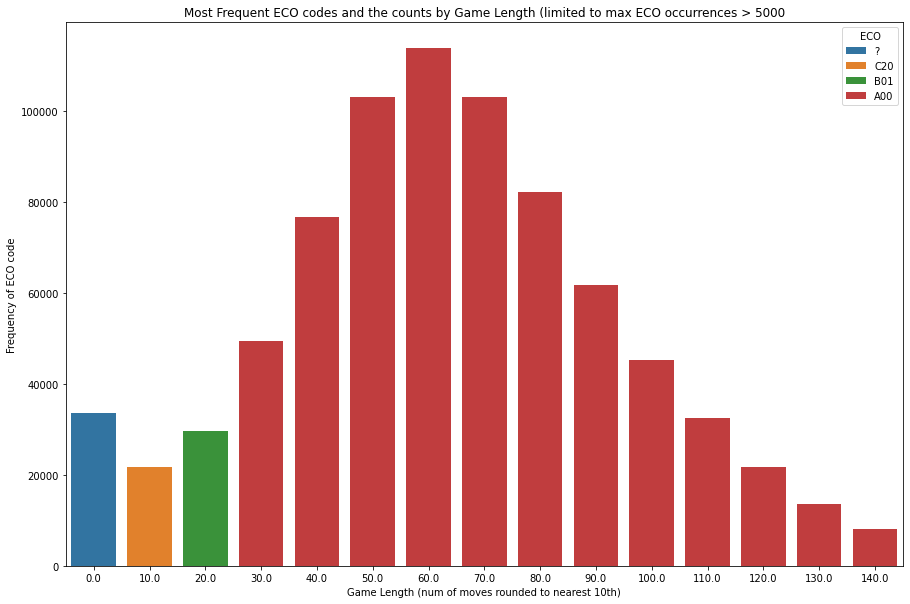

In [ ]:
fig, ax = plt.subplots(figsize = (15, 10))

#Cheap to re-type for visualization - very few columns
all_game_length_eco_bar['max_occur'] = all_game_length_eco_bar.max_occur.astype('int')

sns.barplot(x = 'game_length',       # x variable name
            y = "max_occur",       # y variable name
            hue = "ECO",  # group variable name
            data = all_game_length_eco_bar, # dataframe to plot
            ax=ax,
            dodge=False)
ax.set_xlabel("Game Length (num of moves rounded to nearest 10th)")
ax.set_ylabel("Frequency of ECO code")
ax.set_title("Most Frequent ECO codes and the counts by Game Length (limited to max ECO occurrences > 5000")

A00, not surprising. But when we look at games that end up going longer than 140 moves, we see a large variety of most-frequent-ECOs

In [ ]:
#Query for most frequent ECO for every Game Length w freq < 10
%%bigquery all_game_length_eco_bar_2 --project cs145-f2022

SELECT t1.game_length, t1.ECO, t2.max_occur
FROM (
      SELECT Round(Ply / 10) * 10 AS game_length, ECO, COUNT(ECO) AS freq_eco_by_game_length
    FROM `cs145-f2022.project3.games_main`
    GROUP BY game_length, ECO
    ORDER BY freq_eco_by_game_length DESC
) t1
INNER JOIN (
  SELECT game_length, MAX(freq_eco_by_game_length) AS max_occur
FROM (
    SELECT Round(Ply / 10) * 10 AS game_length, ECO, COUNT(ECO) AS freq_eco_by_game_length
    FROM `cs145-f2022.project3.games_main`
    GROUP BY game_length, ECO
    ORDER BY freq_eco_by_game_length DESC
)
GROUP BY game_length
ORDER BY game_length DESC
) t2 
ON t1.game_length=t2.game_length
AND t1.freq_eco_by_game_length=t2.max_occur
WHERE t2.max_occur<10
ORDER BY t1.game_length ASC

Query is running:   0%|          |

Downloading:   0%|          |

Text(0.5, 1.0, 'Most Frequent ECO codes and the counts by Game Length (limited to max ECO occurrences < 10')

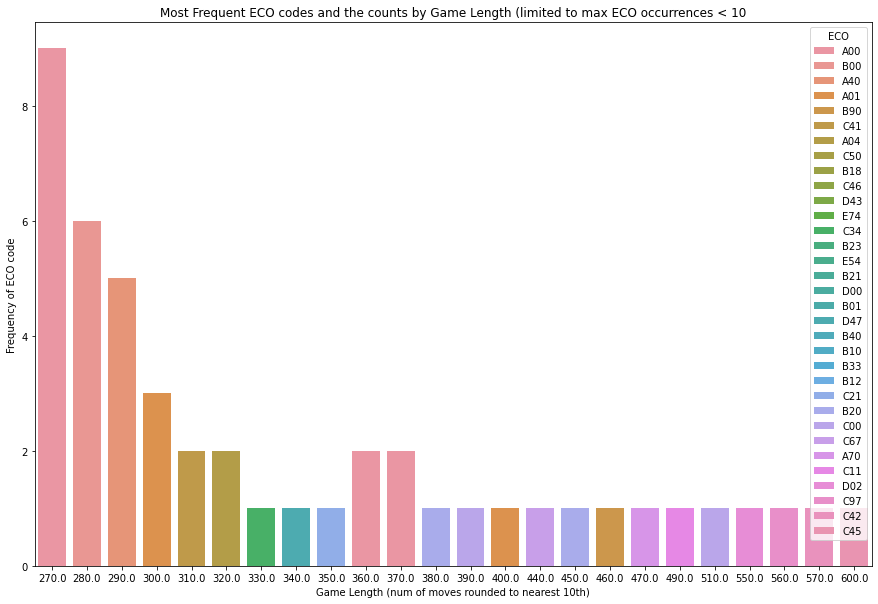

In [ ]:
fig, ax = plt.subplots(figsize = (15, 10))

#Cheap to re-type for visualization - very few columns
all_game_length_eco_bar_2['max_occur'] = all_game_length_eco_bar_2.max_occur.astype('int')

sns.barplot(x = 'game_length',       # x variable name
            y = "max_occur",       # y variable name
            hue = "ECO",  # group variable name
            data = all_game_length_eco_bar_2, # dataframe to plot
            ax=ax,
            dodge=False)
ax.set_xlabel("Game Length (num of moves rounded to nearest 10th)")
ax.set_ylabel("Frequency of ECO code")
ax.set_title("Most Frequent ECO codes and the counts by Game Length (limited to max ECO occurrences < 10")

### Now let's look at the effects of ELOs on opening strategy

Starting w the most freq ECO openings Black receives from White (function of Black ELO)

In [16]:
#Query for most frequent ECO for every Black ELO rounded to the nearest 100
%%bigquery all_black_elo_eco_bar --project cs145-f2022

SELECT t1.BElo, t1.ECO, t2.max_occur
FROM (
    SELECT Round(BlackElo, -2) AS BElo, ECO, COUNT(ECO) as freq_eco_black_elo
    FROM `cs145-f2022.project3.games_main`
    GROUP BY ECO, BElo
    ORDER BY COUNT(ECO) DESC
) t1
INNER JOIN (
  SELECT BElo, MAX(freq_eco_black_elo) AS max_occur
FROM (
    SELECT Round(BlackElo, -2) AS BElo, ECO, COUNT(ECO) as freq_eco_black_elo
    FROM `cs145-f2022.project3.games_main`
    GROUP BY ECO, BElo
    ORDER BY COUNT(ECO) DESC
)
GROUP BY BElo
ORDER BY BElo DESC
) t2 
ON t1.BElo=t2.BElo
AND t1.freq_eco_black_elo=t2.max_occur
WHERE t1.BElo<2900.0
ORDER BY t1.BElo ASC

Query is running:   0%|          |

Downloading:   0%|          |

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]), <a list of 23 Text major ticklabel objects>)

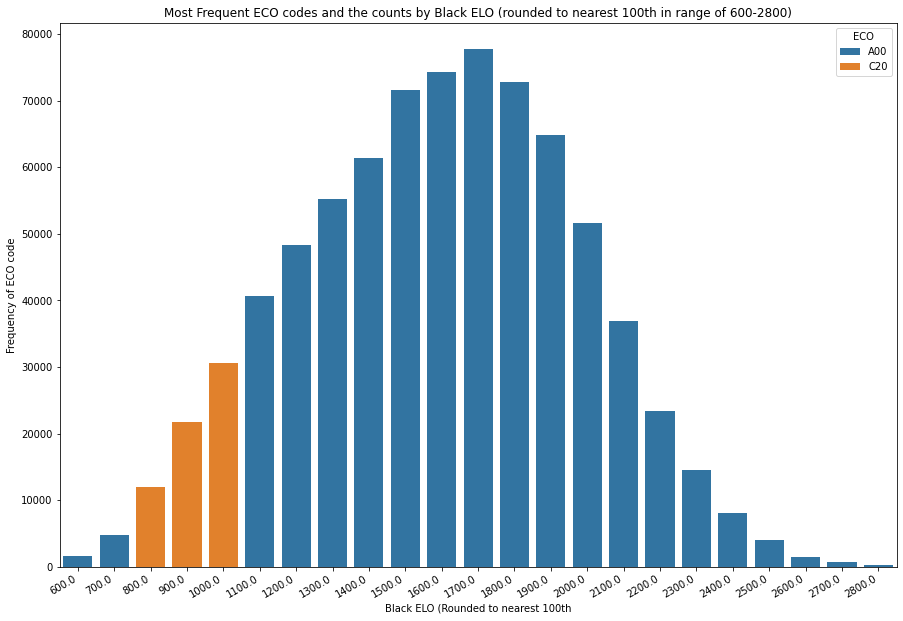

In [18]:
fig, ax = plt.subplots(figsize = (15, 10))

#Cheap to re-type for visualization - very few columns
all_black_elo_eco_bar['max_occur'] = all_black_elo_eco_bar.max_occur.astype('int')

sns.barplot(x = 'BElo',       # x variable name
            y = "max_occur",       # y variable name
            hue = "ECO",  # group variable name
            data = all_black_elo_eco_bar, # dataframe to plot
            ax=ax,
            dodge=False)
ax.set_xlabel("Black ELO (Rounded to nearest 100th")
ax.set_ylabel("Frequency of ECO code")
ax.set_title("Most Frequent ECO codes and the counts by Black ELO (rounded to nearest 100th in range of 600-2800)")

plt.xticks(rotation=30, ha='right')

If we look beyond Black Elo of 2800, we see variations from the majority A00 opening

In [19]:
#Query for most frequent ECO for every Black ELO rounded to the nearest 100
%%bigquery all_black_elo_eco_bar_2 --project cs145-f2022

SELECT t1.BElo, t1.ECO, t2.max_occur
FROM (
    SELECT Round(BlackElo, -2) AS BElo, ECO, COUNT(ECO) as freq_eco_black_elo
    FROM `cs145-f2022.project3.games_main`
    GROUP BY ECO, BElo
    ORDER BY COUNT(ECO) DESC
) t1
INNER JOIN (
  SELECT BElo, MAX(freq_eco_black_elo) AS max_occur
FROM (
    SELECT Round(BlackElo, -2) AS BElo, ECO, COUNT(ECO) as freq_eco_black_elo
    FROM `cs145-f2022.project3.games_main`
    GROUP BY ECO, BElo
    ORDER BY COUNT(ECO) DESC
)
GROUP BY BElo
ORDER BY BElo DESC
) t2 
ON t1.BElo=t2.BElo
AND t1.freq_eco_black_elo=t2.max_occur
WHERE t1.BElo>2800.0
ORDER BY t1.BElo ASC

Query is running:   0%|          |

Downloading:   0%|          |

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

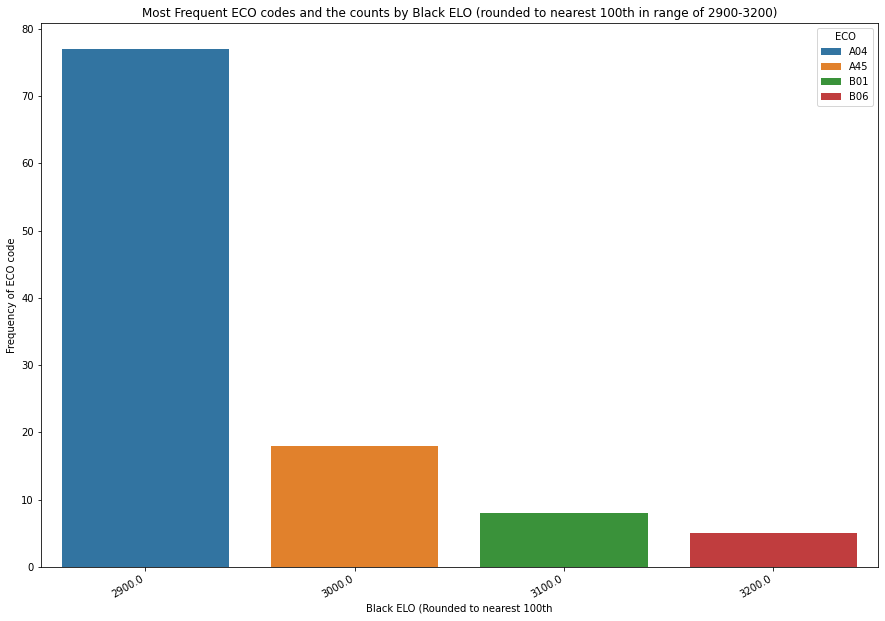

In [20]:
fig, ax = plt.subplots(figsize = (15, 10))

#Cheap to re-type for visualization - very few columns
all_black_elo_eco_bar_2['max_occur'] = all_black_elo_eco_bar_2.max_occur.astype('int')

sns.barplot(x = 'BElo',       # x variable name
            y = "max_occur",       # y variable name
            hue = "ECO",  # group variable name
            data = all_black_elo_eco_bar_2, # dataframe to plot
            ax=ax,
            dodge=False)
ax.set_xlabel("Black ELO (Rounded to nearest 100th")
ax.set_ylabel("Frequency of ECO code")
ax.set_title("Most Frequent ECO codes and the counts by Black ELO (rounded to nearest 100th in range of 2900-3200)")

plt.xticks(rotation=30, ha='right')

Here we see that once we get to the upper echelon of opponents, players that are the White side end up doing majority different openings than A00 and C20

Let's see if there's any difference with this relationship and White Elo's

###Exploring rating-aware opening strategy

Finally, we arrive at our last series of exploratory univariate and bivariate queries, after which we will combine our associations into a multivariate machine learning model. Instead of looking at trends of openings and game results across large categories of player rating or time control, let's consider the relationships between players themselves. Specifically, let's see if there appear to be certain strategies or time controls which favor the higher-rated or lower-rated player in an encounter. 

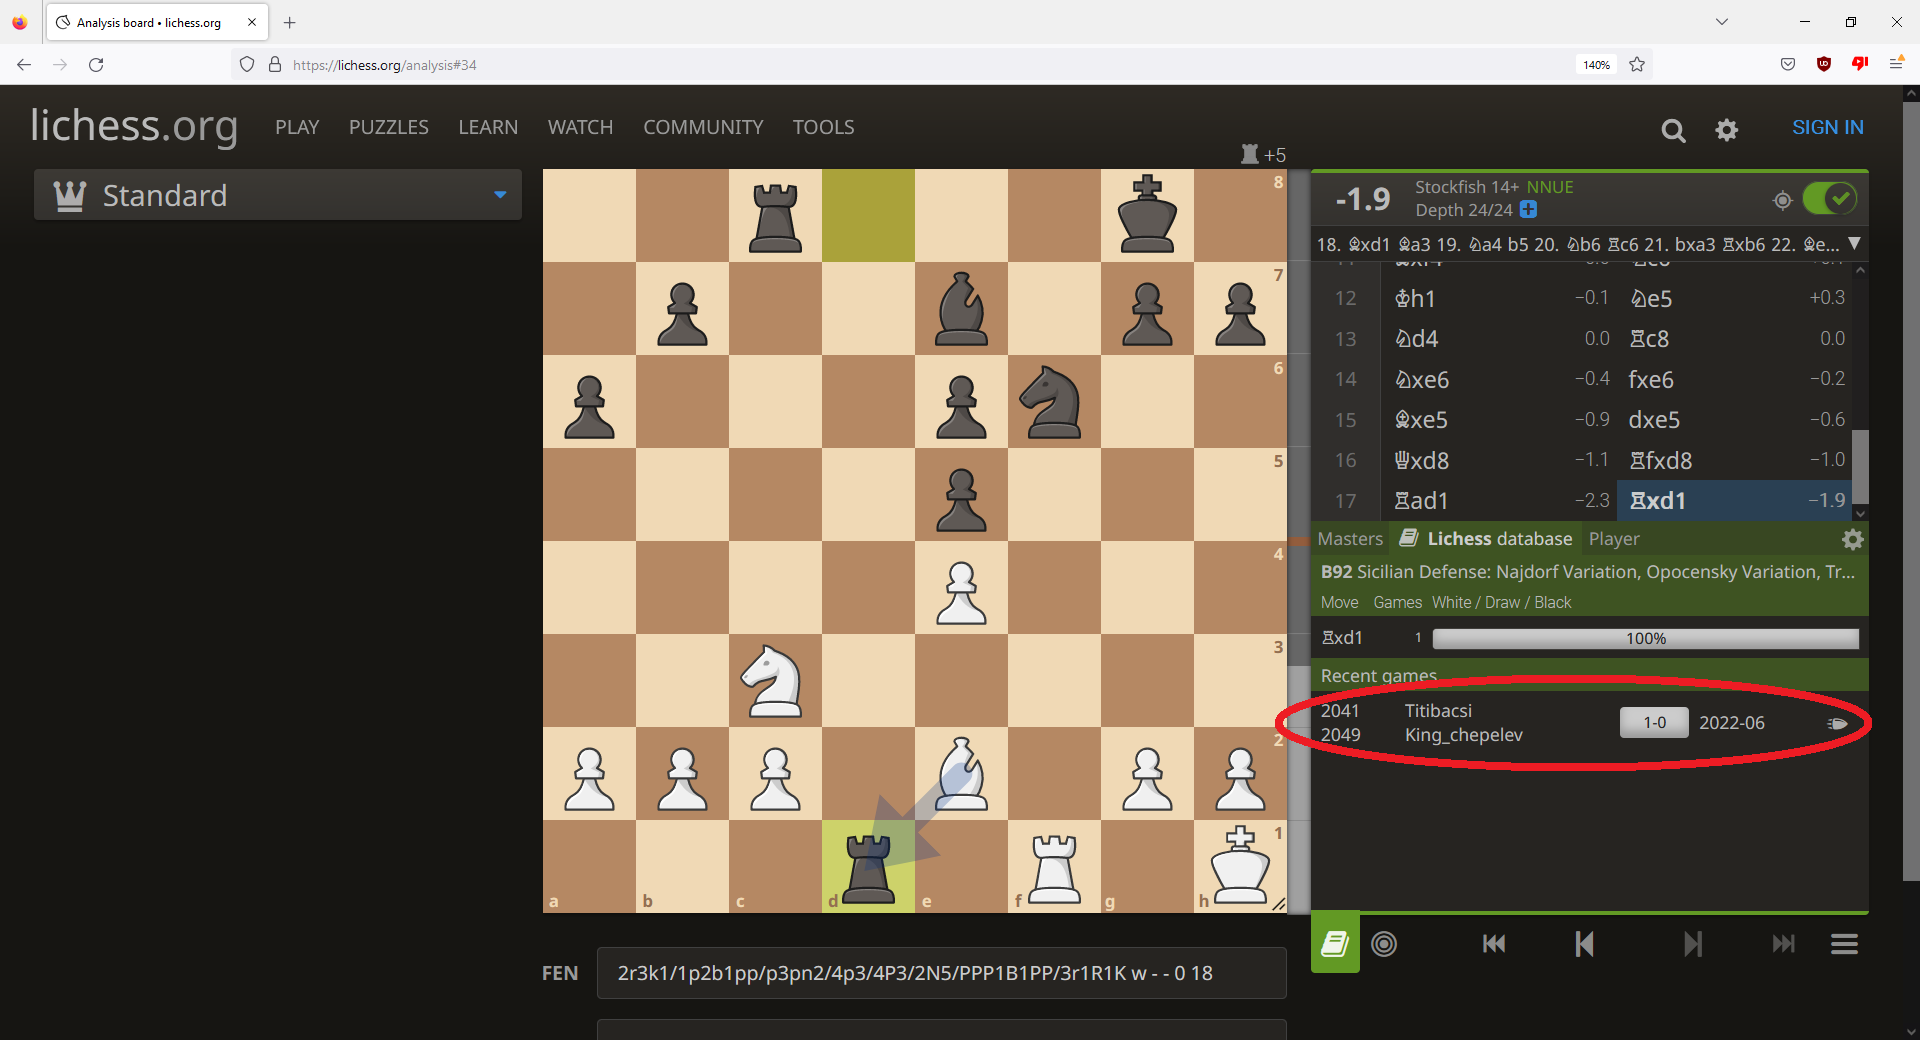

Here, the current lichess analysis board interface becomes exceedingly difficult to use to answer these questions (one must painstakingly sample individual games and create sample statistics, instead of counting occurrences across the entire dataset), and SQL gains a clear advantage. 

####Upset wins by color

Let's define an "upset win" as a game which ends in victory (1-0 or 0-1 result) for the lower-rated player; favorite wins are defined oppositely, where the winner is the higher-rated player. For this question, we will consider a subset of upset wins where the winner has an Elo rating of at least 100 less than the opponent, which I will call "substantial upsets". Are the winners of these substantial upsets more likely to be White or Black? 

In [ ]:
#Query - no visualization, just look at the numbers of games 
%%bigquery upset_color --project cs145-f2022

SELECT Upset_win, COUNT(*) AS num_games
FROM (
  SELECT 
  CASE WHEN WhiteElo <= BlackElo - 100 AND Result='1-0' THEN 'White'
    WHEN BlackElo <= WhiteElo - 100 AND Result='0-1' THEN 'Black'
    ELSE NULL
  END AS Upset_win
  FROM `cs145-f2022.project3.games_main`
  )
WHERE Upset_win IS NOT NULL
GROUP BY Upset_win

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
upset_color

Upset_win  num_games
0     White     329351
1     Black     304456

We can see that in total, substantial upsets account for over 630,000 games in the dataset - over 5% of all games, so not an insignificant proportion. In aggregate, White wins a few more games of this category. However, there is an issue - White tends to win more frequently than Black under a variety of conditions, as we've established in previous sections. We'll look at the percentages of (substantial) upset wins relative to all wins by a given color in the next section.

####Upset and favorite wins by average player rating - **FIX THESE**

First, let's sample 1000 of all the upset and favorite games from our dataset, with no restrictions on minimum rating differential. How do the distributions of average player rating and the average rating differential in an upset win affect each other?

In [ ]:
#Query for upset differentials by avg rating
%%bigquery upset_rating_scatter --project cs145-f2022

SELECT *
FROM (
  SELECT (WhiteElo + BlackElo)/2 AS avg_rating,
  CASE WHEN WhiteElo < BlackElo AND Result='1-0' THEN BlackElo - WhiteElo
    WHEN BlackElo < WhiteElo AND Result='0-1' THEN WhiteElo - BlackElo
    ELSE NULL
  END AS upset_differential, Result --for coloring points?
  FROM `cs145-f2022.project3.games_main`)
WHERE upset_differential IS NOT NULL
ORDER BY RAND()
LIMIT 1000

Could not save output to variable 'upset_rating_scatter'.

ERROR:
 ("Failed to retrieve http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true from the Google Compute Engine metadata service. Status: 404 Response:\nb''", <google.auth.transport.requests._Response object at 0x7f8b33720e80>)


In [ ]:
#Query for favorite differentials by avg rating 
%%bigquery fav_rating_scatter --project cs145-f2022

SELECT *
FROM (
  SELECT (WhiteElo + BlackElo)/2 AS avg_rating,
  CASE WHEN WhiteElo > BlackElo AND Result='1-0' THEN WhiteElo - BlackElo
    WHEN BlackElo > WhiteElo AND Result='0-1' THEN BlackElo - WhiteElo
    ELSE NULL
  END AS favorite_differential, Result
  FROM `cs145-f2022.project3.games_main`)
WHERE favorite_differential IS NOT NULL
ORDER BY RAND()
LIMIT 1000

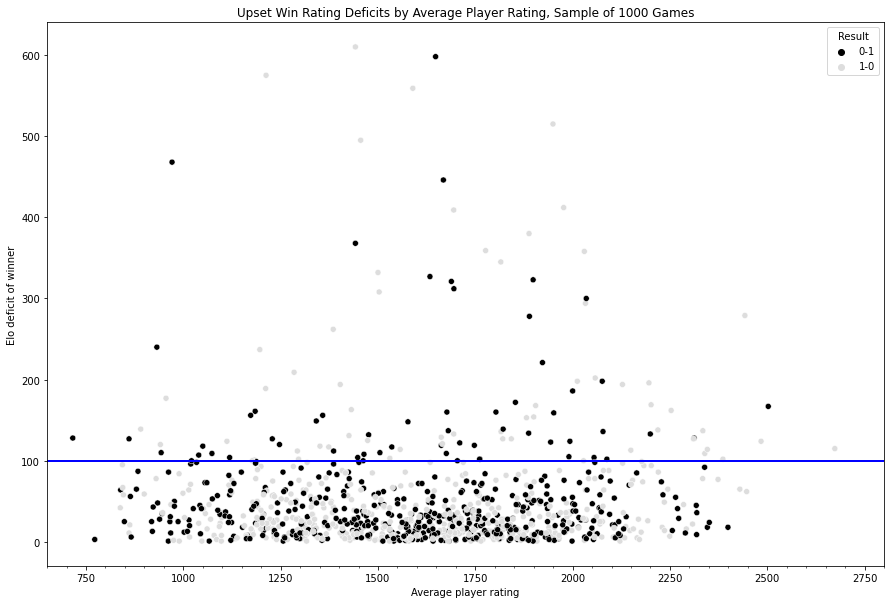

In [ ]:
fig, ax = plt.subplots(figsize = (15, 10))
sns.scatterplot(x = 'avg_rating',       # x variable name
            y = "upset_differential",       # y variable name
            hue = "Result",  # group variable name
            data = upset_rating_scatter, # dataframe to plot
            palette = {'1-0':'#dddddd', 
                       '0-1':'#000000',},
            ax=ax)
ax.set_xlabel("Average player rating")
ax.set_ylabel("Elo deficit of winner")
ax.set_title("Upset Win Rating Deficits by Average Player Rating, Sample of 1000 Games")
ax.hlines(y=100, xmin=650, xmax=2800, linewidth=2, color='b')

#Beautifying
ax.set_xlim([650,2800])
# ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(50))

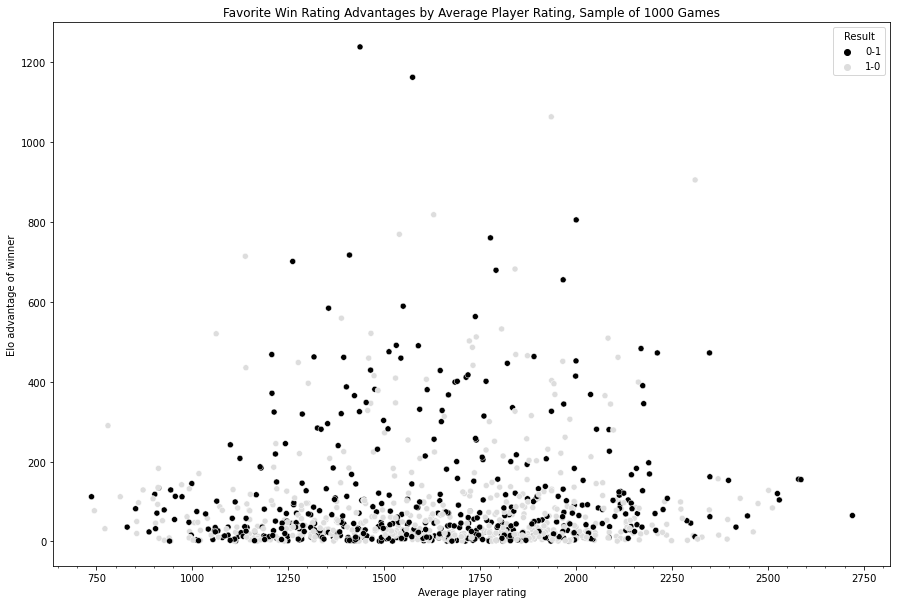

In [ ]:
fig, ax = plt.subplots(figsize = (15, 10))
sns.scatterplot(x = 'avg_rating',       # x variable name
            y = "favorite_differential",       # y variable name
            hue = "Result",  # group variable name
            data = fav_rating_scatter, # dataframe to plot
            palette = {'1-0':'#dddddd', 
                       '0-1':'#000000',},
            ax=ax)
ax.set_xlabel("Average player rating")
ax.set_ylabel("Elo advantage of winner")
ax.set_title("Favorite Win Rating Advantages by Average Player Rating, Sample of 1000 Games")

#Beautifying
# ax.set_ylim([0,100])
# ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(50))

From the above two scatterplots, it's difficult to pick out any exact trends, except to note that the vast majority of both upset and favorite wins occur when the players are close in rating, which is unsurprising given that lichess preferentially pairs players of close ratings (within a few hundred Elo) during the matchmaking process. In addition to having to be manually selected, large differences in player ratings are also only possible for moderate average player ratings as well, which explains why there are few to no outliers on either extreme of the average player rating spectrum (for which thousand-point Elo differentials would necessitate either negative Elos which are impossible, or superhuman Elos which are unachievable). 

If we narrow our focus to substantial upsets as defined above, and view games in aggregate, perhaps we can get a better idea of upset trends. In which rating ranges are these most likely to occur, across all of the games in our dataset?

In [ ]:
#Query 
%%bigquery upset_rating_hist --project cs145-f2022

SELECT avg_rating, Result, ROUND(100*AVG(upset),2) as subst_upset_percentage
FROM (
  SELECT ROUND((WhiteElo + BlackElo)/2, -2) AS avg_rating, Result,
  CASE WHEN WhiteElo < BlackElo - 99 AND Result='1-0' THEN 1
    WHEN BlackElo < WhiteElo -99 AND Result='0-1' THEN 1
    ELSE 0
  END AS upset
  FROM `cs145-f2022.project3.games_main`
  WHERE Result='1-0' OR Result='0-1'
)
GROUP BY avg_rating, Result

Query is running:   0%|          |

Downloading:   0%|          |

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text major ticklabel objects>)

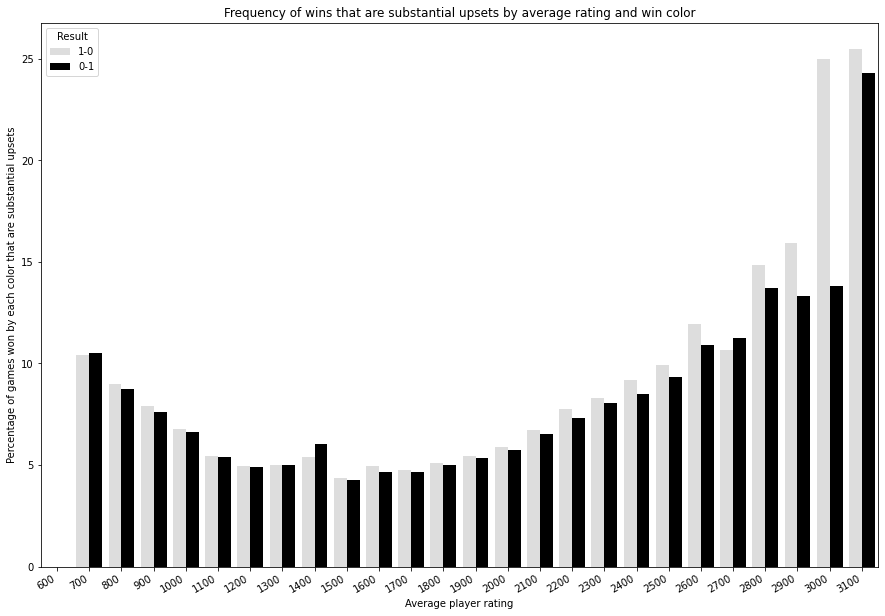

In [ ]:
fig, ax = plt.subplots(figsize = (15, 10))

#Cheap to re-type for visualization - very few columns
upset_rating_hist['avg_rating'] = upset_rating_hist.avg_rating.astype('int')

sns.barplot(x = 'avg_rating',       # x variable name
            y = "subst_upset_percentage",       # y variable name
            hue = "Result",  # group variable name
            data = upset_rating_hist, # dataframe to plot
            hue_order = ['1-0', '0-1'],
            palette = {'1-0':'#dddddd', 
                       '0-1':'#000000',},
            ax=ax)
ax.set_xlabel("Average player rating")
ax.set_ylabel("Percentage of games won by each color that are substantial upsets")
ax.set_title("Frequency of wins that are substantial upsets by average rating and win color")

#Beautifying
# ax.set_ylim([0,100])
# ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
# ax.yaxis.set_minor_locator(ticker.MultipleLocator(2))
plt.xticks(rotation=30, ha='right')

Here we see much clearer trends. Across most of higher average player rating strata, the proportion of white wins that are substantial upsets is slightly higher than the corresponding proportion of black wins that are substantial upsets - however, this is less true for games with an average player rating of below around 1500. More interesting is the overall percentage of wins that are substantial upsets, which follows a roughly parabolic distribution with a minimum around 1500, higher in lower-rated and higher-rated games. 

This graph demands one final query - what is the percentage of substantial upset wins as a percentage of all games and results at a given average rating level? 

In [ ]:
#Query 
%%bigquery upset_rating_hist_allresults --project cs145-f2022

SELECT avg_rating, Result, ROUND(100*AVG(upset),2) as subst_upset_percentage
FROM (
  SELECT ROUND((WhiteElo + BlackElo)/2, -2) AS avg_rating, Result,
  CASE WHEN WhiteElo < BlackElo - 99 AND Result='1-0' THEN 1
    WHEN BlackElo < WhiteElo -99 AND Result='0-1' THEN 1
    ELSE 0
  END AS upset
  FROM `cs145-f2022.project3.games_main`
)
GROUP BY avg_rating, Result

Query is running:   0%|          |

Downloading:   0%|          |

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text major ticklabel objects>)

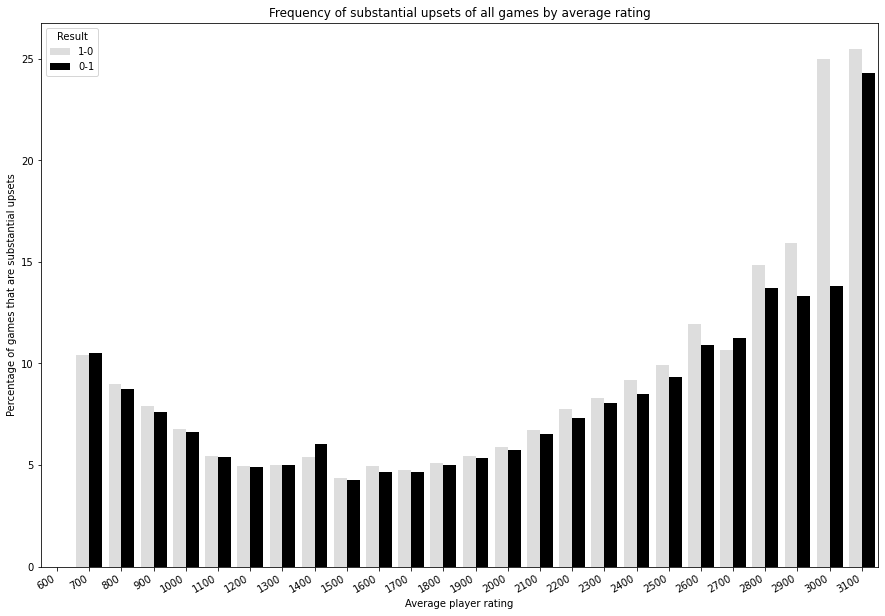

In [ ]:
fig, ax = plt.subplots(figsize = (15, 10))

#Cheap to re-type for visualization - very few columns
upset_rating_hist_allresults['avg_rating'] = \
  upset_rating_hist_allresults.avg_rating.astype('int')

sns.barplot(x = 'avg_rating',       # x variable name
            y = "subst_upset_percentage",       # y variable name
            hue = "Result",  # group variable name
            data = upset_rating_hist_allresults, # dataframe to plot
            hue_order = ['1-0', '0-1'],
            palette = {'1-0':'#dddddd', 
                       '0-1':'#000000',},
            ax=ax)
ax.set_xlabel("Average player rating")
ax.set_ylabel("Percentage of games that are substantial upsets")
ax.set_title("Frequency of substantial upsets of all games by average rating")

#Beautifying
# ax.set_ylim([0,100])
# ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
# ax.yaxis.set_minor_locator(ticker.MultipleLocator(2))
plt.xticks(rotation=30, ha='right')

Ultimately, we see the same trend - the lowest chance of a significant upset win in games with a moderate average player rating, and higher chances at very low or very high average player ratings. 

####Upset wins by time control

Following the model of the previous question, let's see if substantial upset wins are more or less common in certain time controls (as a percentage of all games played with that time control). 


In [ ]:
#Query 
%%bigquery upset_by_timecontrol --project cs145-f2022

SELECT time_control_type, ROUND(100*AVG(upset),2) as subst_upset_percentage
FROM (
  SELECT
  CASE WHEN WhiteElo < BlackElo - 99 AND Result='1-0' THEN 1
    WHEN BlackElo < WhiteElo -99 AND Result='0-1' THEN 1
    ELSE 0
  END AS upset,
  CASE WHEN CONTAINS_SUBSTR(Event, 'ultrabullet') THEN "UltraBullet"
    WHEN CONTAINS_SUBSTR(Event, 'bullet') THEN "Bullet"
    WHEN CONTAINS_SUBSTR(Event, 'blitz') THEN "Blitz"
    WHEN CONTAINS_SUBSTR(Event, 'rapid') THEN "Rapid"
    WHEN CONTAINS_SUBSTR(Event, 'classical') THEN "Classical"
    WHEN CONTAINS_SUBSTR(Event, 'correspondence') THEN "Correspondence"
    ELSE "Other"
  END AS time_control_type
  FROM `cs145-f2022.project3.games_main`
)
GROUP BY time_control_type

Query is running:   0%|          |

Downloading:   0%|          |

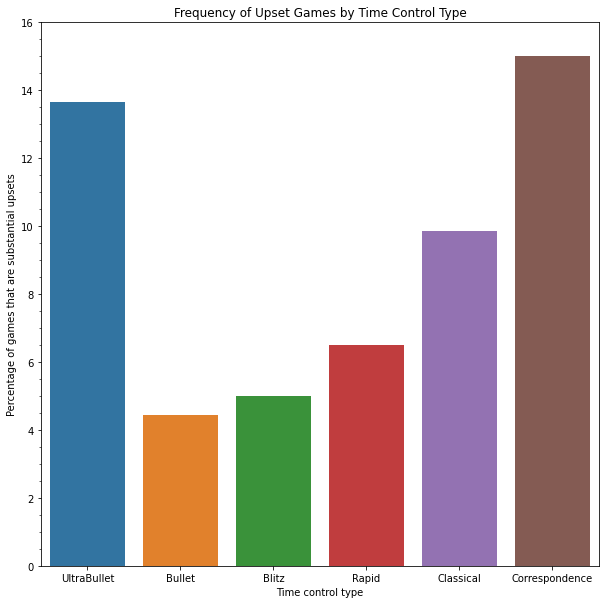

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.barplot(x = 'time_control_type',       # x variable name
            y = "subst_upset_percentage",       # y variable name
            data = upset_by_timecontrol, # dataframe to plot
            order = ['UltraBullet', 'Bullet', 'Blitz', 'Rapid', 'Classical', 'Correspondence'],
            ax=ax)
ax.set_xlabel("Time control type")
ax.set_ylabel("Percentage of games that are substantial upsets")
ax.set_title("Frequency of Upset Games by Time Control Type")

#Beautifying
ax.set_ylim([0,16])
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))

####Frequency of openings amongst upset and favorite wins

####Openings by average rating differential between winner and loser

####Scratchwork

In [ ]:
#Opponent-specific strategy

#Most frequent openings where lower-Elo player holds a draw - W/B
#Most frequent openings in upset wins (lower-Elo player wins) - W/B
#Most frequent openings in favorite wins (higher-Elo player wins) - W/B
#Openings sorted by by average rating differential by winner 
#Most frequent winning openings for the following categories of players:

The general consensus is below 1200= “beginner”, 1200-1800 is “intermediate”, 1800-2000 is “advanced”, 2000-2200 is “expert”, and 2200+ are masters at chess, with FIDE titles being awarded at certain ratings or norms after that.

###Model-building

Although our initial explorations were enlightening, they ultimately are not ideal for helping us decide a course of action because our 1D or 2D plots always miss important axes of covariates. One way to resolve this might be to create more complex tools (i.e. machine learning models) which can identify trends in our data. 

We have two questions which building a predictive model may help us answer:
*   How is a game likely to end?
*   What opening should we choose for a desired result (namely, a win)?

We will investigate the model-building process below.



####Scratchwork

In [ ]:
#Model-building

#############

#First model: 

#Given player Elos and titles (if any), time controls, time of day, number of moves in the game, game result - 
#can we predict the opening used? Large multi-class classification that can be simplified (e.g. leading letter of ECO code) 

#Do not evaluate with pure many-way accuracy - try a metric like top-k accuracy

#Causality might not be completely legitimate, but might help people explore new openings
#Players could input their Elo, opponent's Elo, desired game duration, time controls, desired result (win or draw) and see
#what openings are most correlated with these types of games  

#############

#Second model:

#Given player Elos, titles (if any), time controls, time of day, ECO and Opening, maybe the first 10 moves 
#and clock times (engineer the time spent per move?), predict the game result - 3-way classification 

#Can try to evaluate and build confusion matrix using games_val

#Players could input their Elo, opponent's Elo, time controls, favorite opening, and see what outcome the model thinks is most likely
#for those types of games 

####Modeling game result as a function of other attributes

Let's attempt to build a model from our data that will predict the game result (White win, Black win, or draw) as a function of information from the first 10 moves of the game or sooner. For our first attempt, we will use the following features:
* White and Black Elo
* White and Black titles (can be NULL) 
* ECO code and Opening 
* StartTime and Increment (engineered from TimeControl)
* UTCTime 
* White and Black moves through move 10
* Time spent by end of 10th move (can be NULL; engineered from `[color]_move1_timespent` and `[color]_move10_timespent`) 

The resulting model should be a 3-way classifier; to keep things simple, we will start with logistic regression and progress to more complex nonlinear models as necessary. In this attempt, we will focus our analysis on timed games (no correspondence games) that have at least 10 moves by both White and Black; we will also filter out games that have not yet terminated. 

For training, we will use all games played until April 4, 2021 at 12:00:00 UTC; our validation set will be all games played from this point onwards to the end of our April data. We will not touch our test set (games from the first half of October 1, 2022) until the prediction section of the notebook.

#####Logistic regression 

In [ ]:
%%bigquery --project $project_id

# YOUR QUERY HERE

CREATE OR REPLACE MODEL `cs145-f2022.project3.result_logreg_v1`
OPTIONS(model_type='logistic_reg') AS
SELECT
  Result AS label,
  WhiteElo, BlackElo,
  WhiteTitle, BlackTitle,
  ECO, Opening,
  StartTime, Increment,
  UTCTime,
  white_move1_timespent - white_move10_timespent AS w_time_used,
  black_move1_timespent - black_move10_timespent AS b_time_used,
  white_move1_move AS w1, black_move1_move AS b1,
  white_move2_move AS w2, black_move2_move AS b2,
  white_move3_move AS w3, black_move3_move AS b3,
  white_move4_move AS w4, black_move4_move AS b4,
  white_move5_move AS w5, black_move5_move AS b5,
  white_move6_move AS w6, black_move6_move AS b6,
  white_move7_move AS w7, black_move7_move AS b7,
  white_move8_move AS w8, black_move8_move AS b8,
  white_move9_move AS w9, black_move9_move AS b9,
  white_move10_move AS w10, black_move10_move AS b10
FROM
  `cs145-f2022.project3.games_main`
WHERE black_move10_move IS NOT NULL 
AND Result <> '*'
AND NOT CONTAINS_SUBSTR(Event, 'correspondence')
AND UTCDateTime < '2021-04-04T12:00:00'

Query is running:   0%|          |

Empty DataFrame
Columns: []
Index: []

In [ ]:
%%bigquery --project $project_id

# Run cell to view training stats

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `cs145-f2022.project3.result_logreg_v1`)

Query is running:   0%|          |

Downloading:   0%|          |

training_run  iteration      loss  eval_loss  learning_rate  duration_ms
0             0          1  0.277456   0.277511            0.1        46693
1             0          0  0.278398   0.278446            0.2        34271

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `cs145-f2022.project3.result_logreg_v1`, (
SELECT
  Result AS label,
  WhiteElo, BlackElo,
  WhiteTitle, BlackTitle,
  ECO, Opening,
  StartTime, Increment,
  UTCTime,
  white_move1_timespent - white_move10_timespent AS w_time_used,
  black_move1_timespent - black_move10_timespent AS b_time_used,
  white_move1_move AS w1, black_move1_move AS b1,
  white_move2_move AS w2, black_move2_move AS b2,
  white_move3_move AS w3, black_move3_move AS b3,
  white_move4_move AS w4, black_move4_move AS b4,
  white_move5_move AS w5, black_move5_move AS b5,
  white_move6_move AS w6, black_move6_move AS b6,
  white_move7_move AS w7, black_move7_move AS b7,
  white_move8_move AS w8, black_move8_move AS b8,
  white_move9_move AS w9, black_move9_move AS b9,
  white_move10_move AS w10, black_move10_move AS b10
FROM
  `cs145-f2022.project3.games_main`
WHERE black_move10_move IS NOT NULL 
AND Result <> '*'
AND NOT CONTAINS_SUBSTR(Event, 'correspondence')
AND UTCDateTime >= '2021-04-04T12:00:00'))

Query is running:   0%|          |

Downloading:   0%|          |

precision    recall  accuracy  f1_score  log_loss   roc_auc
0   0.353479  0.363866  0.527115  0.345124  1.503179  0.571107

The base logistic regression model does not have an impressive performance; although we don't have a large number of features, the large number of unique board positions (i.e. sequence of moves) that result after 10 moves might create complexity that a simple model cannot handle. Clever feature engineering might help the model "save brainpower" for computing simpler relations (e.g. using average rating and rating differential instead of WhiteElo and BlackElo), but it's difficult to conceptualize how to do so for the board moves. 

Let's try building a short (3- or 4-layer) deep neural network classifier instead to see if expanding the intermediate hidden dimensions can help with classification. 

#####Deep neural network classifier

In [ ]:
####Best-performing model

%%bigquery --project $project_id

# YOUR QUERY HERE

CREATE OR REPLACE MODEL `cs145-f2022.project3.result_dnn_v4`
OPTIONS(MODEL_TYPE='DNN_CLASSIFIER',
        ACTIVATION_FN = 'RELU',
        BATCH_SIZE = 8192,
        DROPOUT = 0.2,
        EARLY_STOP = FALSE,
        HIDDEN_UNITS = [32,32,32],
        --INPUT_LABEL_COLS = ['Result'],
        LEARN_RATE=0.0003,
        MAX_ITERATIONS = 25,
        OPTIMIZER = 'ADAM') AS
SELECT
  Result AS label,
  WhiteElo, BlackElo,
  WhiteTitle, BlackTitle,
  ECO, Opening,
  StartTime, Increment,
  UTCTime,
  white_move1_timespent - white_move10_timespent AS w_time_used,
  black_move1_timespent - black_move10_timespent AS b_time_used,
  white_move1_move AS w1, black_move1_move AS b1,
  white_move2_move AS w2, black_move2_move AS b2,
  white_move3_move AS w3, black_move3_move AS b3,
  white_move4_move AS w4, black_move4_move AS b4,
  white_move5_move AS w5, black_move5_move AS b5,
  white_move6_move AS w6, black_move6_move AS b6,
  white_move7_move AS w7, black_move7_move AS b7,
  white_move8_move AS w8, black_move8_move AS b8,
  white_move9_move AS w9, black_move9_move AS b9,
  white_move10_move AS w10, black_move10_move AS b10
FROM
  `cs145-f2022.project3.games_main`
WHERE black_move10_move IS NOT NULL 
AND Result <> '*'
AND NOT CONTAINS_SUBSTR(Event, 'correspondence')
AND UTCDateTime < '2021-04-04T12:00:00'

Query is running:   0%|          |

Empty DataFrame
Columns: []
Index: []

In [ ]:
#####DO NOT RERUN DNN TRAINING CELL - JUST RUN BELOW!!!

In [ ]:
%%bigquery --project $project_id

# Run cell to view training stats

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `cs145-f2022.project3.result_dnn_v4`)

Query is running:   0%|          |

Downloading:   0%|          |

training_run  iteration      loss  eval_loss  learning_rate  duration_ms
0              0         24  0.779371   0.800150         0.0003       125807
1              0         23  0.788209   0.801225         0.0003       122378
2              0         22  0.778794   0.799490         0.0003       128586
3              0         21  0.788360   0.801098         0.0003       134647
4              0         20  0.795256   0.800447         0.0003       136147
5              0         19  0.779212   0.799964         0.0003       121024
6              0         18  0.790820   0.801139         0.0003       122944
7              0         17  0.794736   0.800377         0.0003       121287
8              0         16  0.793912   0.800477         0.0003       121792
9              0         15  0.796431   0.800986         0.0003       122920
10             0         14  0.803805   0.801228         0.0003       120041
11             0         13  0.793028   0.801337         0.0003       126294
12             0         12  0.801237   0.801413         0.0003       134402
13             0         11  0.800361   0.802957         0.0003       125083
14             0         10  0.810440   0.803005         0.0003       123393
15             0          9  0.800853   0.803149         0.0003       127243
16             0          8  0.809025   0.803218         0.0003       126764
17             0          7  0.812755   0.804337         0.0003       117488
18             0          6  0.813319   0.805446         0.0003       133323
19             0          5  0.809853   0.806626         0.0003       143997
20             0          4  0.806277   0.806167         0.0003       148412
21             0          3  0.821612   0.806718         0.0003       153011
22             0          2  0.807068   0.808801         0.0003       157145
23             0          1  0.811900   0.809867         0.0003       156303
24             0          0  0.827807   0.820036         0.0003       170609

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `cs145-f2022.project3.result_dnn_v4`, (
SELECT
  Result AS label,
  WhiteElo, BlackElo,
  WhiteTitle, BlackTitle,
  ECO, Opening,
  StartTime, Increment,
  UTCTime,
  white_move1_timespent - white_move10_timespent AS w_time_used,
  black_move1_timespent - black_move10_timespent AS b_time_used,
  white_move1_move AS w1, black_move1_move AS b1,
  white_move2_move AS w2, black_move2_move AS b2,
  white_move3_move AS w3, black_move3_move AS b3,
  white_move4_move AS w4, black_move4_move AS b4,
  white_move5_move AS w5, black_move5_move AS b5,
  white_move6_move AS w6, black_move6_move AS b6,
  white_move7_move AS w7, black_move7_move AS b7,
  white_move8_move AS w8, black_move8_move AS b8,
  white_move9_move AS w9, black_move9_move AS b9,
  white_move10_move AS w10, black_move10_move AS b10
FROM
  `cs145-f2022.project3.games_main`
WHERE black_move10_move IS NOT NULL 
AND Result <> '*'
AND NOT CONTAINS_SUBSTR(Event, 'correspondence')
AND UTCDateTime >= '2021-04-04T12:00:00'))

Query is running:   0%|          |

Downloading:   0%|          |

precision    recall  accuracy  f1_score  log_loss   roc_auc
0   0.576153  0.401899  0.578179  0.392071  1.487249  0.634402

In [ ]:
%%bigquery --project $project_id

# YOUR QUERY HERE
SELECT *
FROM
  ML.PREDICT(MODEL `cs145-f2022.project3.result_dnn_v4`, ( 
SELECT
  Result AS label,
  WhiteElo, BlackElo,
  WhiteTitle, BlackTitle,
  ECO, Opening,
  StartTime, Increment,
  UTCTime,
  white_move1_timespent - white_move10_timespent AS w_time_used,
  black_move1_timespent - black_move10_timespent AS b_time_used,
  white_move1_move AS w1, black_move1_move AS b1,
  white_move2_move AS w2, black_move2_move AS b2,
  white_move3_move AS w3, black_move3_move AS b3,
  white_move4_move AS w4, black_move4_move AS b4,
  white_move5_move AS w5, black_move5_move AS b5,
  white_move6_move AS w6, black_move6_move AS b6,
  white_move7_move AS w7, black_move7_move AS b7,
  white_move8_move AS w8, black_move8_move AS b8,
  white_move9_move AS w9, black_move9_move AS b9,
  white_move10_move AS w10, black_move10_move AS b10
FROM
  `cs145-f2022.project3.games_main`
WHERE black_move10_move IS NOT NULL 
AND Result <> '*'
AND NOT CONTAINS_SUBSTR(Event, 'correspondence')
AND UTCDateTime >= '2021-04-04T12:00:00'))
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

predicted_label                              predicted_label_probs label  \
0             0-1  [{'label': '1/2-1/2', 'prob': 0.03785198181867...   0-1   
1             1-0  [{'label': '1/2-1/2', 'prob': 0.03825020790100...   1-0   
2             0-1  [{'label': '1/2-1/2', 'prob': 0.04915374517440...   0-1   
3             0-1  [{'label': '1/2-1/2', 'prob': 0.02759812772274...   0-1   
4             0-1  [{'label': '1/2-1/2', 'prob': 0.03176742792129...   0-1   
5             0-1  [{'label': '1/2-1/2', 'prob': 0.02813897281885...   0-1   
6             1-0  [{'label': '1/2-1/2', 'prob': 0.01664159446954...   0-1   
7             0-1  [{'label': '1/2-1/2', 'prob': 0.02428107894957...   0-1   
8             0-1  [{'label': '1/2-1/2', 'prob': 0.00856773648411...   0-1   
9             0-1  [{'label': '1/2-1/2', 'prob': 0.01372408680617...   0-1   

   WhiteElo  BlackElo WhiteTitle BlackTitle  ECO  \
0    1371.0    1432.0       None       None  A40   
1    2008.0    1772.0       None       None  B12   
2    2059.0    2352.0       None         CM  C55   
3    1452.0    1731.0       None       None  B10   
4    1413.0    1681.0       None       None  C00   
5    1791.0    1876.0       None       None  B12   
6    2053.0    2052.0       None       None  A00   
7    1687.0    2108.0       None       None  B00   
8     929.0    1142.0       None       None  B20   
9    1006.0    1381.0       None       None  B13   

                                             Opening  StartTime  ...    w6  \
0                                     Modern Defense        0.0  ...  h6g7   
1                                  Caro-Kann Defense        0.0  ...  e1g1   
2  Italian Game: Two Knights Defense, Modern Bish...        0.0  ...  c2c3   
3                                  Caro-Kann Defense        0.0  ...  g1f3   
4                   French Defense: Normal Variation        0.0  ...  c2c4   
5                                  Caro-Kann Defense        0.0  ...  f2f4   
6                                       Grob Opening        0.0  ...  g1f3   
7                                       Pirc Defense        0.0  ...  e5f3   
8                   Sicilian Defense: Bowdler Attack       15.0  ...  g2g4   
9              Caro-Kann Defense: Exchange Variation       15.0  ...  b5c6   

     b6    w7    b7    w8    b8    w9    b9   w10   b10  
0  g8g7  d2g5  b7b6  g5h4  c8b7  g1f3  c7c5  f3g5  c5d4  
1  e7e5  d4e5  d6e5  d1e2  f8d6  f3d2  d7c5  d2b3  c5d3  
2  d7d6  c4b3  h7h6  b1d2  f6h7  f1e1  h7g5  d2f1  g5f3  
3  e7e6  e1g1  f8e7  f1e1  e8g8  b1c3  d7c5  d2d3  c5d7  
4  g8f6  b1c3  e8g8  f1d3  b8c6  e1g1  a7a6  e4e5  a8b8  
5  b8c6  g1f3  f8d6  e1g1  d8c7  f3e5  e8g8  b1d2  c8d7  
6  d8e7  d1b3  e8c8  g4g5  h7h5  g5f6  g8f6  f3g5  e6e5  
7  d5d8  d4d5  e7e6  c2c4  e6d5  c4d5  d8d5  f1d3  c5c4  
8  g8f6  h2h4  f6e4  h1h3  e4f2  h3h1  f2h1  g1f3  c8g4  
9  b7c6  c2c4  c8f5  c1g5  e7e6  g5f6  d8f6  g2g4  f5b1  

[10 rows x 34 columns]

Ultimately, we attempted 5 different deep neural network models, attempting to tune some of the hyperparameters and find a reasonable network architecture. We found that the default learning rate of 0.001 for BigQuery deep neural network classifiers was a bit too steep, and would not give a stable drop in loss over number of epochs. Additionally, we first tried a 3-hidden-layer network with 64, 128 and 64 units respectively (before the final classifier head), but we also suspected that this model could be slightly too complex and cause overfitting. 

Our best-performing architecture has 3 hidden layers with 32 units in each, all with relu activations; the training hyperparameters we chose were a training duration of 25 epochs with dropout of 0.2 and a learning rate of 0.0003 with an Adam optimizer. Still, we did not achieve amazing performance; we only got to a training accuracy of 0.578 with an AUROC of 0.634, indicating that our classifier performed slightly better than random. 

***********

As a final test of the DNN architecture (before we move on to a tree-based approach or to the opening/ECO classification problem), let's see if we can improve performance by being a bit by being smarter with our features. Instead of using WhiteElo and BlackElo, let's try engineering average rating and rating differential (White - Black) as our two numerical rating features to possibly save the model some "brainpower". Additionally, let's investigate if taking out one of {ECO, Opening} will help the model perform better at all as compared to when both are present. 

#####DNN classifier refinement and feature re-engineering

In [ ]:
%%bigquery --project $project_id

# YOUR QUERY HERE

CREATE OR REPLACE MODEL `cs145-f2022.project3.result_dnn_5moves_v1`
OPTIONS(MODEL_TYPE='DNN_CLASSIFIER',
        ACTIVATION_FN = 'RELU',
        BATCH_SIZE = 8192,
        DROPOUT = 0.2,
        EARLY_STOP = FALSE,
        HIDDEN_UNITS = [32,32,32],
        --INPUT_LABEL_COLS = ['Result'],
        LEARN_RATE=0.0003,
        MAX_ITERATIONS = 25,
        OPTIMIZER = 'ADAM') AS
SELECT
  Result AS label,
  (WhiteElo+BlackElo/2) AS avg_rating,
  (WhiteElo - BlackElo) AS white_rating_diff,
  WhiteTitle, BlackTitle,
  ECO, --Opening,
  StartTime, Increment,
  UTCTime,
  white_move1_timespent - white_move10_timespent AS w_time_used,
  black_move1_timespent - black_move10_timespent AS b_time_used,
  white_move1_move AS w1, black_move1_move AS b1,
  white_move2_move AS w2, black_move2_move AS b2,
  white_move3_move AS w3, black_move3_move AS b3,
  white_move4_move AS w4, black_move4_move AS b4,
  white_move5_move AS w5, black_move5_move AS b5,
  --white_move6_move AS w6, black_move6_move AS b6,
  --white_move7_move AS w7, black_move7_move AS b7,
  --white_move8_move AS w8, black_move8_move AS b8,
  --white_move9_move AS w9, black_move9_move AS b9,
  --white_move10_move AS w10, black_move10_move AS b10
FROM
  `cs145-f2022.project3.games_main`
WHERE black_move10_move IS NOT NULL 
AND Result <> '*'
AND NOT CONTAINS_SUBSTR(Event, 'correspondence')
AND UTCDateTime < '2021-04-04T12:00:00'

In [ ]:
#####DO NOT RERUN DNN TRAINING CELL - JUST RUN BELOW!!!

In [ ]:
%%bigquery --project $project_id

# Run cell to view training stats

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `cs145-f2022.project3.result_dnn_5moves_v1`)

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `cs145-f2022.project3.result_dnn_5moves_v1`, (
SELECT
  Result AS label,
  (WhiteElo+BlackElo/2) AS avg_rating,
  (WhiteElo - BlackElo) AS white_rating_diff,
  WhiteTitle, BlackTitle,
  ECO,
  StartTime, Increment,
  UTCTime,
  white_move1_timespent - white_move10_timespent AS w_time_used,
  black_move1_timespent - black_move10_timespent AS b_time_used,
  white_move1_move AS w1, black_move1_move AS b1,
  white_move2_move AS w2, black_move2_move AS b2,
  white_move3_move AS w3, black_move3_move AS b3,
  white_move4_move AS w4, black_move4_move AS b4,
  white_move5_move AS w5, black_move5_move AS b5,
  --white_move6_move AS w6, black_move6_move AS b6,
  --white_move7_move AS w7, black_move7_move AS b7,
  --white_move8_move AS w8, black_move8_move AS b8,
  --white_move9_move AS w9, black_move9_move AS b9,
  --white_move10_move AS w10, black_move10_move AS b10
FROM
  `cs145-f2022.project3.games_main`
WHERE black_move10_move IS NOT NULL 
AND Result <> '*'
AND NOT CONTAINS_SUBSTR(Event, 'correspondence')
AND UTCDateTime >= '2021-04-04T12:00:00'))

Query is running:   0%|          |

Downloading:   0%|          |

precision   recall  accuracy  f1_score  log_loss   roc_auc
0   0.375804  0.39316    0.5641   0.38428  1.504776  0.613691

The removal of the Opening feature (and the transformation of WhiteElo, BlackElo to avg_rating, rating_diff) didn't significantly improve the performance of our model, but the removal of the ECO feature (using just the Opening feature as a proxy for opening strategy) as well as changing the number of moves used was found to be harmful to model performance. As a result, for future downstream models that will use player rating information, we will just use the default WhiteElo, BlackElo attributes. 

We will evaluate our best-performing model in the section on Data Prediction below. 

####Modeling game opening as a function of other attributes

For our second model, we will try to predict what opening was used in a game with specific attributes and results. For our first attempt, we will use the following features:
* White and Black Elo
* White and Black titles (can be NULL) 
* StartTime and Increment (engineered from TimeControl)
* UTCTime 
* Time spent by end of 10th move (can be NULL; engineered from `[color]_move1_timespent` and `[color]_move10_timespent`) 
* Game ply length
* Game result 
* Termination condition 

As evidenced by our above exploration into the frequency of openings as classified either by English common name or ECO code, there is an incredible amount of class imbalance and a very large number of useful classes to predict, potentially (at least 496 for ECO - almost 3000 for English-named Openings!). To avoid making an entirely useless model, let's try something very simple - engineering a label for ECO volume. As there are five volumes, A through E (and a tiny subset of games which have ambiguous classification and are labeled "?"), this problem will turn out to be "only" a six-way classification, and it seems tractable with logistic regression (although the initial results may not be impressive). If we get decent-looking accuracy, we can try to use some `CASE WHEN` statements and domain knowledge to further subdivide ECO codes into reasonable categories for prediction.

#####Logistic regression on ECO volume

In [ ]:
%%bigquery --project $project_id

# YOUR QUERY HERE

CREATE OR REPLACE MODEL `cs145-f2022.project3.eco_logreg_v1`
OPTIONS(model_type='logistic_reg') AS
SELECT
  SUBSTRING(ECO, 1, 1) AS label,
  WhiteElo, BlackElo,
  WhiteTitle, BlackTitle,
  StartTime, Increment,
  UTCTime,
  white_move1_timespent - white_move10_timespent AS w_time_used,
  black_move1_timespent - black_move10_timespent AS b_time_used,
  Ply,
  Result,
  Termination
FROM
  `cs145-f2022.project3.games_main`
WHERE black_move10_move IS NOT NULL 
AND Result <> '*'
AND ECO IS NOT NULL
AND UTCDateTime < '2021-04-04T12:00:00'

Query is running:   0%|          |

Empty DataFrame
Columns: []
Index: []

In [ ]:
%%bigquery --project $project_id

# Run cell to view training stats

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `cs145-f2022.project3.eco_logreg_v1`)

Query is running:   0%|          |

Downloading:   0%|          |

training_run  iteration      loss  eval_loss  learning_rate  duration_ms
0             0          3  0.273981   0.276526            1.6        42854
1             0          2  0.279161   0.280286            0.8        39589
2             0          1  0.290689   0.291094            0.4        35141
3             0          0  0.307142   0.307255            0.2        25966

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `cs145-f2022.project3.eco_logreg_v1`, (
SELECT
  SUBSTRING(ECO, 1, 1) AS label,
  WhiteElo, BlackElo,
  WhiteTitle, BlackTitle,
  StartTime, Increment,
  UTCTime,
  white_move1_timespent - white_move10_timespent AS w_time_used,
  black_move1_timespent - black_move10_timespent AS b_time_used,
  Ply,
  Result,
  Termination
FROM
  `cs145-f2022.project3.games_main`
WHERE black_move10_move IS NOT NULL 
AND Result <> '*'
AND ECO IS NOT NULL
AND UTCDateTime >= '2021-04-04T12:00:00'))

Query is running:   0%|          |

Downloading:   0%|          |

precision    recall  accuracy  f1_score  log_loss   roc_auc
0   0.213117  0.248323  0.367119  0.225723  1.829136  0.594617

In [ ]:
%%bigquery --project $project_id

# YOUR QUERY HERE
SELECT *
FROM
  ML.PREDICT(MODEL `cs145-f2022.project3.eco_logreg_v1`, ( 
SELECT
  SUBSTRING(ECO, 1, 1) AS label,
  WhiteElo, BlackElo,
  WhiteTitle, BlackTitle,
  StartTime, Increment,
  UTCTime,
  white_move1_timespent - white_move10_timespent AS w_time_used,
  black_move1_timespent - black_move10_timespent AS b_time_used,
  Ply,
  Result,
  Termination
FROM
  `cs145-f2022.project3.games_main`
WHERE black_move10_move IS NOT NULL 
AND Result <> '*'
AND ECO IS NOT NULL
AND UTCDateTime >= '2021-04-04T12:00:00'))
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

predicted_label                              predicted_label_probs label  \
0               B  [{'label': 'B', 'prob': 0.31599633856502557}, ...     C   
1               C  [{'label': 'C', 'prob': 0.38932733220013727}, ...     C   
2               A  [{'label': 'A', 'prob': 0.38182760335800436}, ...     D   
3               B  [{'label': 'B', 'prob': 0.29605695239410923}, ...     B   
4               C  [{'label': 'C', 'prob': 0.3943572872966881}, {...     C   
5               C  [{'label': 'C', 'prob': 0.3252557478538412}, {...     C   
6               C  [{'label': 'C', 'prob': 0.3367559097577093}, {...     A   
7               B  [{'label': 'B', 'prob': 0.3116963680842672}, {...     C   
8               C  [{'label': 'C', 'prob': 0.3388102955120172}, {...     C   
9               A  [{'label': 'A', 'prob': 0.323773635785019}, {'...     A   

   WhiteElo  BlackElo WhiteTitle BlackTitle  StartTime  Increment   UTCTime  \
0    1707.0    1710.0       None       None      300.0        0.0  15:35:01   
1    1028.0     944.0       None       None       60.0        0.0  12:46:42   
2    2245.0    2267.0       None       None      180.0        0.0  16:57:33   
3    1758.0    1758.0       None       None      180.0        0.0  13:54:10   
4    1500.0    1680.0       None       None      600.0        0.0  15:22:29   
5    1337.0    1330.0       None       None      180.0        0.0  16:50:32   
6    1441.0    1393.0       None       None      180.0        2.0  16:53:43   
7    1839.0    1924.0       None       None      180.0        0.0  15:49:13   
8    1507.0    1485.0       None       None      300.0        0.0  13:35:40   
9    1452.0    1434.0       None       None      120.0        1.0  12:05:57   

   w_time_used  b_time_used    Ply Result   Termination  
0         38.0         40.0   56.0    0-1        Normal  
1         24.0         19.0   34.0    0-1  Time forfeit  
2         15.0         10.0   89.0    1-0        Normal  
3         19.0         25.0   49.0    0-1        Normal  
4        115.0         67.0   26.0    0-1        Normal  
5         10.0         13.0  102.0    0-1        Normal  
6         30.0         -2.0   50.0    0-1        Normal  
7         13.0         15.0   71.0    1-0        Normal  
8         19.0         50.0   43.0    1-0        Normal  
9         15.0         10.0   70.0    0-1  Time forfeit

The accuracy of this model on paper is, as expected, not great. However, it's important to note that stripping away the ECO code and simply predicting volume destroys a ton of information; for example, the only thing volumes B and C have in common is that they describe all openings starting with `e4`, and so a model that misclassifies a `B` game as a `C` game is making a qualitatively less egregious error than misclassifying a `B` game as an `A` game, which isn't well-captured by a default cross-entropy loss function that would be used for parameter selection. 

Something I will try, therefore, is to see what happens if we run a logistic regression model on a more complex engineered label. One observation to make is that many unique values for the `Opening` attribute really refer to the same base opening; variations are simply appended to the name after a colon character (for example, "English Opening: Anglo-Indian Defense, Scandinavian Defense, Exchange Variation"). If we try some string parsing in SQL to remove all characters starting from the colon afterwards, we can maybe get at a shorter list of unique openings which it is feasible to predict.

#####Logistic regression on Base opening

In [ ]:
%%bigquery --project $project_id

SELECT COUNT(*) AS num_base_openings FROM(
  SELECT DISTINCT CASE WHEN STRPOS(Opening, ':')=0 THEN Opening ELSE SUBSTR(Opening, 1, STRPOS(Opening, ':')-1) END AS Base_opening
  FROM `cs145-f2022.project3.games_main` 
)

Query is running:   0%|          |

Downloading:   0%|          |

num_base_openings
0                167

We see that after applying the above transformation to our `Opening` attribute, we are left with 167 base openings, upon which some 2500 or so variations can be appended to give us the original total count of about 2900 distinct named openings. Unfortunately, BigQuery still does not allow 167-way classification, and even if it did, there is still some label overlap (where something like "King's Pawn" is *technically* a valid if not the most descriptive label for other types of openings). The approach we will try, although equally as problematic as for ECO classification, is to compress down all of the least-common named openings into one grab bag of "other", and keep the 49 most common openings as their own labels. This will probably end poorly, but there is hopefully at least pedagogical merit here with regards to label engineering. 

After trying a bunch of CTEs, nested queries, etc. - it seems that the best method for doing this will be to create a new attribute in our `games_main` table, do some label preprocessing with a few queries, and then run a 50-way classification model.

In [ ]:
%%bigquery --project $project_id

--Create a new column for Base opening
ALTER TABLE `cs145-f2022.project3.games_main` 
ADD COLUMN Base_opening STRING;

Query is running:   0%|          |

Empty DataFrame
Columns: []
Index: []

In [ ]:
%%bigquery --project $project_id

--Modify all values of this new column 
UPDATE `cs145-f2022.project3.games_main` 
SET Base_opening = CASE WHEN STRPOS(Opening, ':')=0 THEN Opening 
  ELSE SUBSTR(Opening, 1, STRPOS(Opening, ':')-1) 
END
WHERE Opening IS NOT NULL

Query is running:   0%|          |

Empty DataFrame
Columns: []
Index: []

In [ ]:
%%bigquery --project $project_id

--Modify all values of this new column AGAIN to prepare for 50-way classification
UPDATE `cs145-f2022.project3.games_main` 
SET Base_opening = 
  CASE WHEN Base_opening IN (
    SELECT Base_opening
    FROM (
      SELECT Base_opening, COUNT(*) AS num_games
      FROM `cs145-f2022.project3.games_main`
      GROUP BY Base_opening
      ORDER BY num_games DESC
      LIMIT 49
    )
  ) THEN Base_opening
  ELSE 'Other'
END
WHERE Opening IS NOT NULL

Query is running:   0%|          |

Empty DataFrame
Columns: []
Index: []

In [ ]:
%%bigquery --project $project_id
SELECT COUNT(*)
FROM (SELECT DISTINCT Base_opening FROM `cs145-f2022.project3.games_main`)

Query is running:   0%|          |

Downloading:   0%|          |

f0_
0   50

In [ ]:
%%bigquery --project $project_id

# YOUR QUERY HERE

CREATE OR REPLACE MODEL `cs145-f2022.project3.opening_logreg_v1`
OPTIONS(model_type='logistic_reg') AS
SELECT
  Base_opening AS label,
  WhiteElo, BlackElo,
  WhiteTitle, BlackTitle,
  StartTime, Increment,
  UTCTime,
  white_move1_timespent - white_move10_timespent AS w_time_used,
  black_move1_timespent - black_move10_timespent AS b_time_used,
  Ply,
  Result,
  Termination
FROM
  `cs145-f2022.project3.games_main`
WHERE black_move10_move IS NOT NULL 
AND Result <> '*'
AND ECO IS NOT NULL
AND UTCDateTime < '2021-04-04T12:00:00'

Query is running:   0%|          |

Empty DataFrame
Columns: []
Index: []

In [ ]:
%%bigquery --project $project_id

# Run cell to view training stats

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `cs145-f2022.project3.opening_logreg_v1`)

Query is running:   0%|          |

Downloading:   0%|          |

training_run  iteration      loss  eval_loss  learning_rate  duration_ms
0             0          5  0.068321   0.069943            6.4       471371
1             0          4  0.069303   0.070156            3.2       415826
2             0          3  0.071586   0.072005            1.6       427527
3             0          2  0.074421   0.074616            0.8       393321
4             0          1  0.076453   0.076537            0.4       401799
5             0          0  0.077621   0.077648            0.2       177230

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `cs145-f2022.project3.opening_logreg_v1`, (
SELECT
  Base_opening AS label,
  WhiteElo, BlackElo,
  WhiteTitle, BlackTitle,
  StartTime, Increment,
  UTCTime,
  white_move1_timespent - white_move10_timespent AS w_time_used,
  black_move1_timespent - black_move10_timespent AS b_time_used,
  Ply,
  Result,
  Termination
FROM
  `cs145-f2022.project3.games_main`
WHERE black_move10_move IS NOT NULL 
AND Result <> '*'
AND ECO IS NOT NULL
AND UTCDateTime >= '2021-04-04T12:00:00'))

Query is running:   0%|          |

Downloading:   0%|          |

precision    recall  accuracy  f1_score  log_loss   roc_auc
0   0.021328  0.023049  0.076605  0.012565  4.174355  0.574302

In [ ]:
%%bigquery --project $project_id

# YOUR QUERY HERE
SELECT *
FROM
  ML.PREDICT(MODEL `cs145-f2022.project3.opening_logreg_v1`, ( 
SELECT
  Base_opening AS label,
  WhiteElo, BlackElo,
  WhiteTitle, BlackTitle,
  StartTime, Increment,
  UTCTime,
  white_move1_timespent - white_move10_timespent AS w_time_used,
  black_move1_timespent - black_move10_timespent AS b_time_used,
  Ply,
  Result,
  Termination
FROM
  `cs145-f2022.project3.games_main`
WHERE black_move10_move IS NOT NULL 
AND Result <> '*'
AND ECO IS NOT NULL
AND UTCDateTime >= '2021-04-04T12:00:00'))
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

predicted_label                              predicted_label_probs  \
0                 Other  [{'label': 'Other', 'prob': 0.1053950773706947...   
1     Queen's Pawn Game  [{'label': 'Queen's Pawn Game', 'prob': 0.1008...   
2                 Other  [{'label': 'Other', 'prob': 0.0835061192762379...   
3  Scandinavian Defense  [{'label': 'Scandinavian Defense', 'prob': 0.0...   
4        French Defense  [{'label': 'French Defense', 'prob': 0.0956148...   
5     Queen's Pawn Game  [{'label': 'Queen's Pawn Game', 'prob': 0.1205...   
6     Queen's Pawn Game  [{'label': 'Queen's Pawn Game', 'prob': 0.1366...   
7     Queen's Pawn Game  [{'label': 'Queen's Pawn Game', 'prob': 0.0873...   
8     Queen's Pawn Game  [{'label': 'Queen's Pawn Game', 'prob': 0.0730...   
9     Queen's Pawn Game  [{'label': 'Queen's Pawn Game', 'prob': 0.0896...   

                     label  WhiteElo  BlackElo WhiteTitle BlackTitle  \
0         Bishop's Opening    1376.0    1365.0       None       None   
1         Sicilian Defense    1581.0    1611.0       None       None   
2        Queen's Pawn Game    1695.0    1734.0       None       None   
3     Scandinavian Defense    1370.0     740.0       None       None   
4  Englund Gambit Declined    1664.0    1493.0       None       None   
5             Pirc Defense    1817.0    1784.0       None       None   
6           French Defense    1126.0    1103.0       None       None   
7          Horwitz Defense    1540.0    1543.0       None       None   
8         Alekhine Defense    1159.0    1105.0       None       None   
9        Queen's Pawn Game    1337.0    1363.0       None       None   

   StartTime  Increment   UTCTime  w_time_used  b_time_used    Ply Result  \
0      600.0        5.0  15:32:29          8.0          6.0   36.0    0-1   
1      420.0        5.0  13:37:41        -14.0         28.0  113.0    1-0   
2      180.0        0.0  15:59:52         16.0         25.0  160.0    0-1   
3       60.0        0.0  15:31:38          7.0         14.0   67.0    1-0   
4       30.0        0.0  17:11:42          4.0         26.0   25.0    1-0   
5      300.0        3.0  14:29:57          5.0         -5.0   73.0    1-0   
6      180.0        0.0  13:24:45         22.0         11.0   86.0    0-1   
7      180.0        2.0  13:41:28          7.0         36.0   90.0    0-1   
8      180.0        0.0  15:34:54         50.0         43.0   57.0    1-0   
9       60.0        0.0  17:41:21          7.0          9.0   86.0    0-1   

    Termination  
0        Normal  
1        Normal  
2        Normal  
3  Time forfeit  
4  Time forfeit  
5        Normal  
6        Normal  
7        Normal  
8        Normal  
9  Time forfeit

As expected, this model's on-paper performance is abysmal, and because of the limited input feature space and difficulties in overlapping labels, we consider it unlikely to improve upon this metric significantly by throwing a more advanced model at the prediction problem.

One thing to consider trying (again for pedagogical purposes) is to implement a top-k accuracy function to see if the model can guess the correct Base opening played in *k* tries instead of just 1. Our method of calculating this metric will necessitate creating a new table and storing the prediction results. Then, the `predicted_label_probs` array can hopefully be unpacked to answer this question. 

#####Implementing top-k accuracy

In [ ]:
%%bigquery --project $project_id

--create a very small sample table to experiment first
CREATE OR REPLACE TABLE `cs145-f2022.project3.opening_logreg_v1_predictions` AS
SELECT *
FROM
  ML.PREDICT(MODEL `cs145-f2022.project3.opening_logreg_v1`, ( 
SELECT
  Site, --used to identify the games for unnesting later
  Base_opening AS label,
  WhiteElo, BlackElo,
  WhiteTitle, BlackTitle,
  StartTime, Increment,
  UTCTime,
  white_move1_timespent - white_move10_timespent AS w_time_used,
  black_move1_timespent - black_move10_timespent AS b_time_used,
  Ply,
  Result,
  Termination
FROM
  `cs145-f2022.project3.games_main`
WHERE black_move10_move IS NOT NULL 
AND Result <> '*'
AND ECO IS NOT NULL
AND UTCDateTime >= '2021-04-04T12:00:00'))
LIMIT 100

Query is running:   0%|          |

Empty DataFrame
Columns: []
Index: []

It turns out that there's a very elegant way to compute top-k accuracy! What we first do is use the `UNNEST` operator to expand out the `predicted_label_probs` array. Making this entire operation possible is the fact that by default, the `STRUCT`s of `<label, prob>` in `predicted_label_probs` are SORTED in descending order by softmax probability, meaning that the first entry in this array gives the label that the model predicts with highest confidence, followed by the second most likely label, the third, and so on and so forth. Using this knowledge, we then use the `WITH OFFSET` operator to fetch a (zero-indexed) position in the array for each label we extract. Then, we simply include a `WHERE` clause to filter through all of the unnested rows for just those where the predicted label matches the actual label of the game, and we can determine if this prediction passes by looking at the associated rank of that prediction!! We can very easily calculate top-k accurcy in BigQuery very easily from this point onward using simple `GROUP BY` operations, but we can also return this table to Pandas, where we can write functions that will allow us to determine top-k accuracy for k of our choosing without performing the expensive operation of re-querying the table. Let's try it on our entire evaluation set!

In [ ]:
%%bigquery --project $project_id

--put in our entire evaluation set - no LIMIT! 
CREATE OR REPLACE TABLE `cs145-f2022.project3.opening_logreg_v1_predictions` AS
SELECT *
FROM
  ML.PREDICT(MODEL `cs145-f2022.project3.opening_logreg_v1`, ( 
SELECT
  Site, --used to identify the games for unnesting later
  Base_opening AS label,
  WhiteElo, BlackElo,
  WhiteTitle, BlackTitle,
  StartTime, Increment,
  UTCTime,
  white_move1_timespent - white_move10_timespent AS w_time_used,
  black_move1_timespent - black_move10_timespent AS b_time_used,
  Ply,
  Result,
  Termination
FROM
  `cs145-f2022.project3.games_main`
WHERE black_move10_move IS NOT NULL 
AND Result <> '*'
AND ECO IS NOT NULL
AND UTCDateTime >= '2021-04-04T12:00:00'))

Query is running:   0%|          |

Empty DataFrame
Columns: []
Index: []

In [ ]:
%%bigquery --project $project_id

SELECT ROUND(100*COUNT(*)/(SELECT COUNT(*) FROM `cs145-f2022.project3.opening_logreg_v1_predictions`), 2)
AS top_3_accuracy
FROM (
  SELECT Site, pred_rank
  FROM `cs145-f2022.project3.opening_logreg_v1_predictions` AS games,
  UNNEST(predicted_label_probs) AS preds --unnest the predictions array
  WITH OFFSET AS pred_rank --fetch the prediction rank for each label
  WHERE preds.label=games.label --find the correct rank
  AND pred_rank < 3 --does the associated rank of the correct label pass top-k? 
)

Query is running:   0%|          |

Downloading:   0%|          |

top_3_accuracy
0           22.28

We see that if our model is evaluated with a top-1 (or standard) accuracy metric, it only got about 7.66% of games correct; given 3 top guesses, however, it can get the correct opening in about 22.28% of games. 

This appears impressive, but how does this model stack up against a no-learning policy? We know how imbalanced the labels for ECO and Opening are, but we haven't yet investigated our engineered Base opening feature yet. 

In [ ]:
%%bigquery base_opening_freq --project cs145-f2022

SELECT Base_opening, 
  ROUND(100*COUNT(*)/(SELECT COUNT(*) FROM `cs145-f2022.project3.games_main`), 2) AS percent_games
FROM `cs145-f2022.project3.games_main`
GROUP BY Base_opening 
ORDER BY COUNT(*) DESC

Query is running:   0%|          |

Downloading:   0%|          |

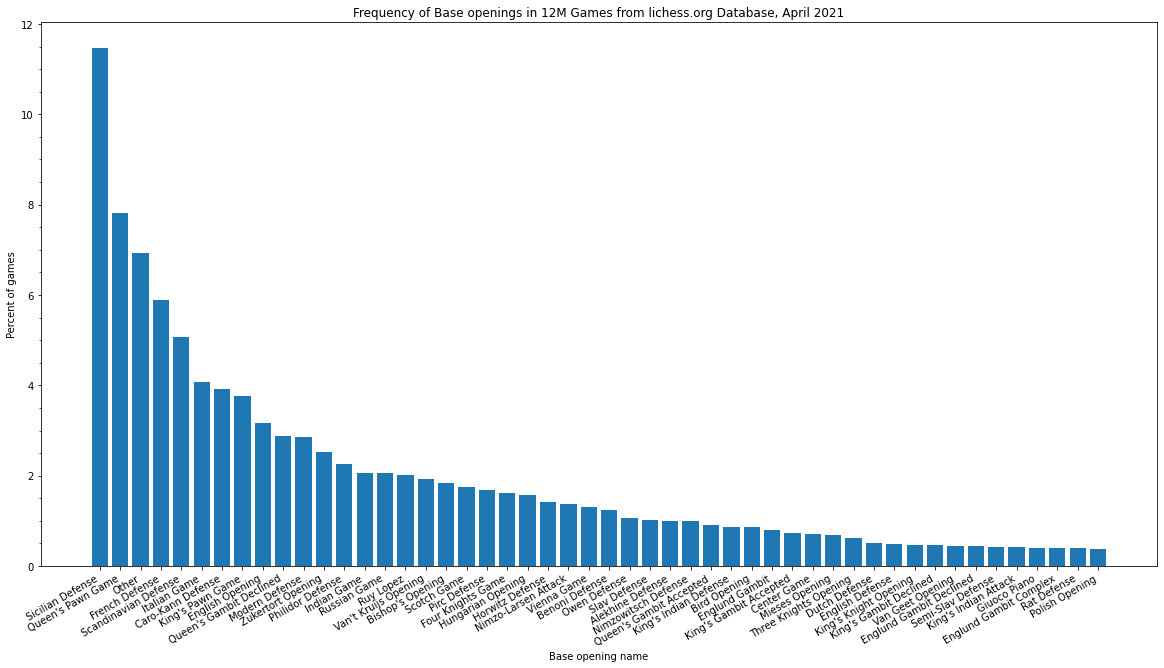

In [ ]:
#plotting/labeling
fig, ax = plt.subplots(figsize = (20, 10)) #Giant plots for language readability
ax.bar(base_opening_freq.Base_opening, base_opening_freq.percent_games)
ax.set_xlabel("Base opening name")
ax.set_ylabel("Percent of games")
ax.set_title("Frequency of Base openings in 12M Games from lichess.org Database, April 2021")

#Beautifying
plt.xticks(rotation=30, ha='right');
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))

Upon actually examining our data, we arrive at the unpleasant conclusion that by simply predicting "Sicilian Defense" for all games, we would achieve about 50% higher accuracy than our logistic regression model gave us. :(

(The gap closes a little if we consider top-3 accuracy, but again, the maximally-conservative learning approach of predicting the top 3 most common Base openings is a better policy by a few percent.) 

The last thing we will try is training a 50-way DNN classifier with some minimal fine-tuning to see if we can at least beat the no-learning policy; then, we will report a few top-k accuracy metrics in comparison to our known label distribution and move on to making predictions on our holdout data! 

#####DNN classifier on Base opening

In [ ]:
%%bigquery --project $project_id

# YOUR QUERY HERE

CREATE OR REPLACE MODEL `cs145-f2022.project3.opening_dnn_v1`
OPTIONS(MODEL_TYPE='DNN_CLASSIFIER',
        ACTIVATION_FN = 'RELU',
        BATCH_SIZE = 8192,
        DROPOUT = 0.2,
        EARLY_STOP = FALSE,
        HIDDEN_UNITS = [32,32,32],
        --INPUT_LABEL_COLS = ['Result'],
        LEARN_RATE=0.0006,
        MAX_ITERATIONS = 15,
        OPTIMIZER = 'ADAM') AS
SELECT
  Base_opening AS label,
  WhiteElo, BlackElo,
  WhiteTitle, BlackTitle,
  StartTime, Increment,
  UTCTime,
  white_move1_timespent - white_move10_timespent AS w_time_used,
  black_move1_timespent - black_move10_timespent AS b_time_used,
  Ply,
  Result,
  Termination
FROM
  `cs145-f2022.project3.games_main`
WHERE black_move10_move IS NOT NULL 
AND Result <> '*'
AND ECO IS NOT NULL
AND UTCDateTime < '2021-04-04T12:00:00'

Query is running:   0%|          |

Empty DataFrame
Columns: []
Index: []

In [ ]:
%%bigquery --project $project_id

# Run cell to view training stats

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `cs145-f2022.project3.opening_dnn_v1`)

Query is running:   0%|          |

Downloading:   0%|          |

training_run  iteration      loss  eval_loss  learning_rate  duration_ms
0              0         14  3.340707   3.375025         0.0006       506963
1              0         13  3.363635   3.373499         0.0006       503049
2              0         12  3.367603   3.372630         0.0006       465170
3              0         11  3.357943   3.372160         0.0006       472371
4              0         10  3.364682   3.371419         0.0006       483277
5              0          9  3.353494   3.371348         0.0006       510543
6              0          8  3.361326   3.370803         0.0006       483815
7              0          7  3.360277   3.371691         0.0006       563662
8              0          6  3.368784   3.370555         0.0006       493267
9              0          5  3.377911   3.370941         0.0006       521179
10             0          4  3.357249   3.371604         0.0006       528063
11             0          3  3.372643   3.373463         0.0006       500986
12             0          2  3.363273   3.376173         0.0006       491656
13             0          1  3.383491   3.383558         0.0006       508969
14             0          0  3.383487   3.408986         0.0006       502989

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `cs145-f2022.project3.opening_dnn_v1`, (
SELECT
  Base_opening AS label,
  WhiteElo, BlackElo,
  WhiteTitle, BlackTitle,
  StartTime, Increment,
  UTCTime,
  white_move1_timespent - white_move10_timespent AS w_time_used,
  black_move1_timespent - black_move10_timespent AS b_time_used,
  Ply,
  Result,
  Termination
FROM
  `cs145-f2022.project3.games_main`
WHERE black_move10_move IS NOT NULL 
AND Result <> '*'
AND ECO IS NOT NULL
AND UTCDateTime >= '2021-04-04T12:00:00'))

Query is running:   0%|          |

Downloading:   0%|          |

precision  recall  accuracy  f1_score  log_loss   roc_auc
0   0.018566  0.0258  0.122095  0.011468  4.192127  0.650557

In [ ]:
%%bigquery --project $project_id

# YOUR QUERY HERE
SELECT *
FROM
  ML.PREDICT(MODEL `cs145-f2022.project3.opening_dnn_v1`, ( 
SELECT
  Base_opening AS label,
  WhiteElo, BlackElo,
  WhiteTitle, BlackTitle,
  StartTime, Increment,
  UTCTime,
  white_move1_timespent - white_move10_timespent AS w_time_used,
  black_move1_timespent - black_move10_timespent AS b_time_used,
  Ply,
  Result,
  Termination
FROM
  `cs145-f2022.project3.games_main`
WHERE black_move10_move IS NOT NULL 
AND Result <> '*'
AND ECO IS NOT NULL
AND UTCDateTime >= '2021-04-04T12:00:00'))
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

predicted_label                              predicted_label_probs  \
0      Sicilian Defense  [{'label': 'Zukertort Opening', 'prob': 0.0146...   
1      Sicilian Defense  [{'label': 'Zukertort Opening', 'prob': 0.0152...   
2      Sicilian Defense  [{'label': 'Zukertort Opening', 'prob': 0.0133...   
3      Sicilian Defense  [{'label': 'Zukertort Opening', 'prob': 0.0151...   
4      Sicilian Defense  [{'label': 'Zukertort Opening', 'prob': 0.0153...   
5     Queen's Pawn Game  [{'label': 'Zukertort Opening', 'prob': 0.0363...   
6     Queen's Pawn Game  [{'label': 'Zukertort Opening', 'prob': 0.0476...   
7      Sicilian Defense  [{'label': 'Zukertort Opening', 'prob': 0.0564...   
8      Sicilian Defense  [{'label': 'Zukertort Opening', 'prob': 0.0764...   
9  Scandinavian Defense  [{'label': 'Zukertort Opening', 'prob': 0.0221...   

   label  WhiteElo  BlackElo WhiteTitle BlackTitle  StartTime  Increment  \
0  Other    1842.0    1451.0       None       None        NaN        NaN   
1  Other    1662.0    1917.0       None       None        NaN        NaN   
2  Other    1270.0    1384.0       None       None        NaN        NaN   
3  Other    1808.0    1191.0       None       None        NaN        NaN   
4  Other    1226.0    1607.0       None       None        NaN        NaN   
5  Other     848.0    1024.0       None       None       15.0        0.0   
6  Other    1274.0    1117.0       None       None       15.0        0.0   
7  Other    2083.0    2063.0       None       None        0.0        1.0   
8  Other    1880.0    2368.0       None       None        0.0        1.0   
9  Other    1096.0    1217.0       None       None       15.0        0.0   

    UTCTime  w_time_used  b_time_used    Ply   Result   Termination  
0  14:24:23          NaN          NaN  100.0  1/2-1/2        Normal  
1  12:41:15          NaN          NaN   38.0      0-1        Normal  
2  16:52:43          NaN          NaN  102.0      0-1        Normal  
3  17:04:51          NaN          NaN   25.0      1-0        Normal  
4  17:45:18          NaN          NaN   62.0      0-1        Normal  
5  17:00:50          7.0          2.0   30.0  1/2-1/2        Normal  
6  17:35:53          5.0          7.0   32.0      0-1  Time forfeit  
7  17:35:02         -2.0         -8.0   36.0      0-1  Time forfeit  
8  16:33:53         -4.0         -8.0   42.0      0-1  Time forfeit  
9  17:31:50         10.0          5.0   26.0      0-1  Time forfeit

When examining the output of the DNN classifier, we see that far more games are predicted to open with a Sicilian Defense - this affirms that our model is learning something, because this is the most frequent Base opening label! Additionally, our model has a (top-1) accuracy of about 12.21% - not high, but still higher than the frequency of Sicilian Defense as a label, suggesting that the model has learned to do ever so slightly better than just predict the most common label in the dataset. 

Unfortunately, we notice while examining the snippets of output in the `predicted_label_probs` attribute that the labels and respective softmax probabilities are no longer sorted in descending order of probability, and are instead sorted in descending order of label name ("Zukertort Opening" at the start of the `STRUCT` array and "Alekhine Defense" at the end). To check top-k accuracy, we'll have to make a slight modification to our query to see if we can sort it as desired. 

In [ ]:
%%bigquery --project $project_id

--create a very small sample table to experiment first
CREATE OR REPLACE TABLE `cs145-f2022.project3.opening_dnn_v1_predictions` AS
SELECT *
FROM
  ML.PREDICT(MODEL `cs145-f2022.project3.opening_dnn_v1`, ( 
SELECT
  Site, --used to identify the games for unnesting later
  Base_opening AS label,
  WhiteElo, BlackElo,
  WhiteTitle, BlackTitle,
  StartTime, Increment,
  UTCTime,
  white_move1_timespent - white_move10_timespent AS w_time_used,
  black_move1_timespent - black_move10_timespent AS b_time_used,
  Ply,
  Result,
  Termination
FROM
  `cs145-f2022.project3.games_main`
WHERE black_move10_move IS NOT NULL 
AND Result <> '*'
AND ECO IS NOT NULL
AND UTCDateTime >= '2021-04-04T12:00:00'))
LIMIT 100

Query is running:   0%|          |

Empty DataFrame
Columns: []
Index: []

Our new query will look very similar to our old one, but will require an additional nested query layer to achieve the same state as the default logistic regression output table - the recommended method is to sort the array, return it as one of the queried columns, and then operate on it again to get array indexes. 



In [ ]:
%%bigquery --project $project_id

--Now, on all data
CREATE OR REPLACE TABLE `cs145-f2022.project3.opening_dnn_v1_predictions` AS
SELECT *
FROM
  ML.PREDICT(MODEL `cs145-f2022.project3.opening_dnn_v1`, ( 
SELECT
  Site, --used to identify the games for unnesting later
  Base_opening AS label,
  WhiteElo, BlackElo,
  WhiteTitle, BlackTitle,
  StartTime, Increment,
  UTCTime,
  white_move1_timespent - white_move10_timespent AS w_time_used,
  black_move1_timespent - black_move10_timespent AS b_time_used,
  Ply,
  Result,
  Termination
FROM
  `cs145-f2022.project3.games_main`
WHERE black_move10_move IS NOT NULL 
AND Result <> '*'
AND ECO IS NOT NULL
AND UTCDateTime >= '2021-04-04T12:00:00'))

Query is running:   0%|          |

Empty DataFrame
Columns: []
Index: []

In [ ]:
%%bigquery --project $project_id

SELECT ROUND(100*COUNT(*)/(SELECT COUNT(*) FROM `cs145-f2022.project3.opening_dnn_v1_predictions`), 2)
AS top_3_accuracy
FROM (
  SELECT Site, pred_rank 
  FROM (
    SELECT Site, label, 
    ARRAY(SELECT x FROM UNNEST(predicted_label_probs) AS x ORDER BY prob DESC) 
    AS predicted_label_probs 
    FROM `cs145-f2022.project3.opening_dnn_v1_predictions` AS games
  ) AS games, 
  UNNEST(predicted_label_probs) AS preds WITH OFFSET AS pred_rank
  WHERE preds.label=games.label
  AND pred_rank < 3
)

Query is running:   0%|          |

Downloading:   0%|          |

top_3_accuracy
0           27.64

And we can see a modest improvement compared to the logistic regression model - now, top-3 accuracy reaches 27.64%. How does this accuracy compare to the naive strategy of picking our top 3 as the most common 3 labels of Base opening? 

In [ ]:
np.sum(base_opening_freq.percent_games.values[:3])

26.220000000000002

Better, but only by a hair. 

## Data Prediction

Now that we have made two predictive models, let's crack open our test dataset - the 1 million games played in the first 11 hours or so of October 1, 2022. We'll investigate how well the model performs in terms of pure accuracy, and then do a bit more exploring with other metrics:
* For our 3-way game result classifier, we will build a confusion matrix and examine the model's performance on specific subsets of the data. 
* For our Base opening classifier, we will look at the distributions of ground-truth label rank for specific openings and games. 

And in both cases, we'll have a little fun experimenting with how we might use these models to inform our chess playstyles!

###Preprocessing (**RUN ONCE**)

In [ ]:
%%bigquery --project $project_id

--Create a new column for Base opening in the appropriate table
ALTER TABLE `cs145-f2022.project3.games_val` 
ADD COLUMN Base_opening STRING;

Query is running:   0%|          |

Empty DataFrame
Columns: []
Index: []

In [ ]:
%%bigquery --project $project_id

--Modify all values of this new column 
UPDATE `cs145-f2022.project3.games_val` 
SET Base_opening = CASE WHEN STRPOS(Opening, ':')=0 THEN Opening 
  ELSE SUBSTR(Opening, 1, STRPOS(Opening, ':')-1) 
END
WHERE Opening IS NOT NULL

Query is running:   0%|          |

Empty DataFrame
Columns: []
Index: []

In [ ]:
%%bigquery --project $project_id

--Modify all values of this new column AGAIN to prepare for 50-way classification
UPDATE `cs145-f2022.project3.games_val` 
SET Base_opening = 
  CASE WHEN Base_opening IN (
    SELECT Base_opening
    FROM (
      SELECT Base_opening, COUNT(*) AS num_games
      --IMPORTANT - we use the labeling scheme based on 
      --opening frequencies from our training data!!! 
      FROM `cs145-f2022.project3.games_main` 
      GROUP BY Base_opening
      ORDER BY num_games DESC
      LIMIT 49
    )
  ) THEN Base_opening
  ELSE 'Other'
END
WHERE Opening IS NOT NULL

Query is running:   0%|          |

Empty DataFrame
Columns: []
Index: []

In [ ]:
%%bigquery --project $project_id

--Double-check the expected count of distinct labels for Opening classification
SELECT COUNT(*)
FROM (SELECT DISTINCT Base_opening FROM `cs145-f2022.project3.games_main`)

Query is running:   0%|          |

Downloading:   0%|          |

f0_
0   50

###Test set performance - classifiers for game result

####Basic metrics

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `cs145-f2022.project3.result_logreg_v1`, (
SELECT
  Result AS label,
  WhiteElo, BlackElo,
  WhiteTitle, BlackTitle,
  ECO, Opening,
  StartTime, Increment,
  UTCTime,
  white_move1_timespent - white_move10_timespent AS w_time_used,
  black_move1_timespent - black_move10_timespent AS b_time_used,
  white_move1_move AS w1, black_move1_move AS b1,
  white_move2_move AS w2, black_move2_move AS b2,
  white_move3_move AS w3, black_move3_move AS b3,
  white_move4_move AS w4, black_move4_move AS b4,
  white_move5_move AS w5, black_move5_move AS b5,
  white_move6_move AS w6, black_move6_move AS b6,
  white_move7_move AS w7, black_move7_move AS b7,
  white_move8_move AS w8, black_move8_move AS b8,
  white_move9_move AS w9, black_move9_move AS b9,
  white_move10_move AS w10, black_move10_move AS b10
FROM
  `cs145-f2022.project3.games_val`
WHERE black_move10_move IS NOT NULL 
AND Result <> '*'))

Query is running:   0%|          |

Downloading:   0%|          |

precision    recall  accuracy  f1_score  log_loss   roc_auc
0   0.348707  0.357541    0.5222  0.339389  1.502999  0.561569

The first model we trained, a logistic regression classifier for game result, performs very similarly on the test data (overall accuracy of 52.22%) as compared to on our evaluation set split from the training data (accuracy of 52.71%). The accuracy is slightly lower as expected (perhaps some distributional shift naturally occurs as certain openings and time controls rise or fall in popularity over years), but is very usable! Let's investigate the DNN classifier:

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `cs145-f2022.project3.result_dnn_v4`, (
SELECT
  Result AS label,
  WhiteElo, BlackElo,
  WhiteTitle, BlackTitle,
  ECO, Opening,
  StartTime, Increment,
  UTCTime,
  white_move1_timespent - white_move10_timespent AS w_time_used,
  black_move1_timespent - black_move10_timespent AS b_time_used,
  white_move1_move AS w1, black_move1_move AS b1,
  white_move2_move AS w2, black_move2_move AS b2,
  white_move3_move AS w3, black_move3_move AS b3,
  white_move4_move AS w4, black_move4_move AS b4,
  white_move5_move AS w5, black_move5_move AS b5,
  white_move6_move AS w6, black_move6_move AS b6,
  white_move7_move AS w7, black_move7_move AS b7,
  white_move8_move AS w8, black_move8_move AS b8,
  white_move9_move AS w9, black_move9_move AS b9,
  white_move10_move AS w10, black_move10_move AS b10
FROM
  `cs145-f2022.project3.games_val`
WHERE black_move10_move IS NOT NULL 
AND Result <> '*'))

Query is running:   0%|          |

Downloading:   0%|          |

precision   recall  accuracy  f1_score  log_loss   roc_auc
0   0.686195  0.39358   0.56825   0.38655  1.483678  0.622373

As with the logistic classifier, our deep neural network has slightly lower accuracy on the test data (56.83%) as compared to the holdout validation set which we used for model selection (57.82%) - however, this is not a drastic loss in performance, which is good for us. 

As we continue with more detailed analyses, we will focus on the DNN classifier and leave the logistic classifier alone, as it is strictly outperformed by the more complex model.

####Detailed metrics



Beyond accuracy, let's look at the other metrics available to us in the default output of `ML.EVALUATE`. While raw accuracy may help in very quickly assessing the rough behavior of a model, it is not always very informative in terms of how much a model has actually "learned", especially if our labels are highly imbalanced. The interpretation of precision, recall, f1 score and AUROC are much harder when our prediction problem (as here) is non-binary, but they can be used for rough qualitative assessments of the model. An AUROC of 0.622 suggests our model is definitely outperforming random, but is not an amazing fit (ideally we would have something in the range of 0.7-0.8 at least). The precision and recall figures suggest that our model prioritizes its positive predictive value (that is, maximizing the probability that a model-predicted label is the true label) while sacrificing on the sensitivity of the true label (the model may not identify all games that have the true label). 

To examine the model's performance on each of the three classes, we will first plot a confusion matrix for all predictions.

In [ ]:
%%bigquery result_preds --project $project_id

#Get a bunch of other attributes for more detailed investigation
SELECT predicted_label, label, WhiteElo, BlackElo, WhiteTitle, BlackTitle, Base_opening, time_control_type
FROM
  ML.PREDICT(MODEL `cs145-f2022.project3.result_dnn_v4`, ( 
SELECT
  Result AS label,
  WhiteElo, BlackElo,
  WhiteTitle, BlackTitle,
  ECO, Opening, Base_opening, --use for accuracy investigations 
  StartTime, Increment,
  UTCTime,
  white_move1_timespent - white_move10_timespent AS w_time_used,
  black_move1_timespent - black_move10_timespent AS b_time_used,
  white_move1_move AS w1, black_move1_move AS b1,
  white_move2_move AS w2, black_move2_move AS b2,
  white_move3_move AS w3, black_move3_move AS b3,
  white_move4_move AS w4, black_move4_move AS b4,
  white_move5_move AS w5, black_move5_move AS b5,
  white_move6_move AS w6, black_move6_move AS b6,
  white_move7_move AS w7, black_move7_move AS b7,
  white_move8_move AS w8, black_move8_move AS b8,
  white_move9_move AS w9, black_move9_move AS b9,
  white_move10_move AS w10, black_move10_move AS b10,
  CASE WHEN CONTAINS_SUBSTR(Event, 'ultrabullet') THEN "UltraBullet"
    WHEN CONTAINS_SUBSTR(Event, 'bullet') THEN "Bullet"
    WHEN CONTAINS_SUBSTR(Event, 'blitz') THEN "Blitz"
    WHEN CONTAINS_SUBSTR(Event, 'rapid') THEN "Rapid"
    WHEN CONTAINS_SUBSTR(Event, 'classical') THEN "Classical"
    WHEN CONTAINS_SUBSTR(Event, 'correspondence') THEN "Correspondence"
    ELSE "Other"
  END AS time_control_type --for detailed accuracy investigations
FROM
  `cs145-f2022.project3.games_val`
WHERE black_move10_move IS NOT NULL 
AND Result <> '*'))

Query is running:   0%|          |

Downloading:   0%|          |

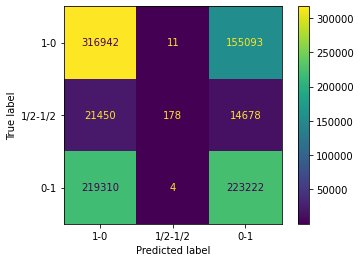

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(result_preds.label, result_preds.predicted_label, labels=['1-0', '1/2-1/2', '0-1'])

Across all of our data, we can now visualize where our model makes its predictions relative to the ground-truth labels - and therefore, where it makes errors most often. The model is horrendous at *identifying* draws; because of their very low frequency (by far the least common class at around 3.5-4%), the model is almost never rewarded for predicting a draw, and therefore exhibits very low sensitivity towards this class (although the model predicts a draw with very high precision; if it guesses a game is a draw, there's a very good chance it actually is). The class that the model is best at predicting is White victory ("1-0"), which it does with about two-thirds sensitivity by glancing at the confusion matrix. Astoundingly, the model performs barely better than random at correctly predicting Black victory ("0-1"); a game that is actually won by Black is almost equally likely to be predicted a White victory as it is a Black victory, so again the sensitivity of the model is lackluster. 

Now, let's try plotting confusion matrices for specific subsets of games.

For example, my (Bowen's) current lichess Blitz rating is 1834, which over the past year and a half has ranged between 1750 and 1900. If I were to play a game with one of the Blitz time controls (e.g. 3 minutes with a 2-second increment per move; or 5 minutes with no bonus time), how well can the model predict *my* specific odds of victory? Let's examine the model's performance on games that look like this in the test set - Blitz games where at least one player has a rating between 1750 and 1900.

In [ ]:
#Condition: Blitz AND (WhiteElo between 1750,1900 OR BlackElo between 1750, 1900)
blitz_preds = result_preds.loc[(result_preds.time_control_type=='Blitz') & \
    (((result_preds.WhiteElo <= 1900) & (result_preds.WhiteElo >= 1750)) | \
     ((result_preds.BlackElo <= 1900) & (result_preds.BlackElo >= 1750)))]

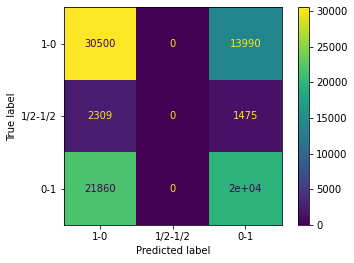

In [ ]:
ConfusionMatrixDisplay.from_predictions(blitz_preds.label, blitz_preds.predicted_label, labels=['1-0', '1/2-1/2', '0-1'])

Amongst this subset of games, the model performs similarly to how it does on the whole dataset, but its performance on Black victories is noticeably worse with less than 50% sensitivity. 

I also have played a large number of Bullet games on lichess, my rating for which has climbed from about 1830 to around 1950 over the past year and a half. How does the model perform on these games? 

In [ ]:
#Condition: Bullet AND (WhiteElo between 1830,1950 OR BlackElo between 1830, 1950)
bullet_preds = result_preds.loc[(result_preds.time_control_type=='Bullet') & \
    (((result_preds.WhiteElo <= 1950) & (result_preds.WhiteElo >= 1830)) | \
     ((result_preds.BlackElo <= 1950) & (result_preds.BlackElo >= 1830)))]

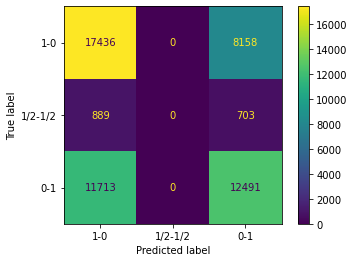

In [ ]:
ConfusionMatrixDisplay.from_predictions(bullet_preds.label, bullet_preds.predicted_label, labels=['1-0', '1/2-1/2', '0-1'])

Again, very similar performance, but the model does have improved sensitivity for Black victories and a positive predictive value of around 60-70% for both Black and White victories. 

Now, let's look at my (Bowen's) favorite opening for Black - the Scandinavian Defense. How well does the model predict results of these games?

In [ ]:
scandi_preds = result_preds.loc[(result_preds.Base_opening=='Scandinavian Defense')]

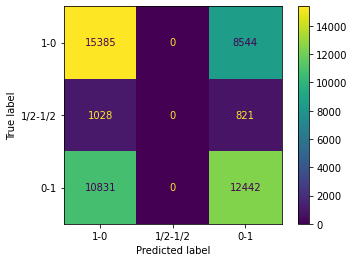

In [ ]:
ConfusionMatrixDisplay.from_predictions(scandi_preds.label, scandi_preds.predicted_label, labels=['1-0', '1/2-1/2', '0-1'])

As before, the model struggles a bit more at detecting Black victories, but it visually appears to have better precision and recall for both types of victories as compared to some of the above subsets of games. 

Finally, let's investigate how the model performs at predicting the results of games where at least one player has a title (i.e. games of a higher skill level, ostensibly). Does it do better, worse, or about the same as on the above subsets of games? 

In [ ]:
#Condition: Either White or Black has a title that is not "BOT"
title_preds = result_preds.loc[((~pd.isna(result_preds.WhiteTitle)) & \
                            (result_preds.WhiteTitle!='BOT')) | \
                           ((~pd.isna(result_preds.BlackTitle)) \
                            & (result_preds.BlackTitle!='BOT'))]
#Additional filter - neither White or Black has a title that is "BOT"
title_preds = title_preds.loc[(title_preds.WhiteTitle!='BOT') & \
                              (title_preds.BlackTitle!='BOT')]

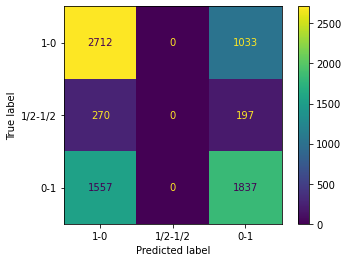

In [ ]:
ConfusionMatrixDisplay.from_predictions(title_preds.label, title_preds.predicted_label, labels=['1-0', '1/2-1/2', '0-1'])

We can see visually that on titled games, the model has high precision and recall for White victories as expected. Based on simple ratios of the numbers of games, the precision and recall for Black victories are also slightly better, but not nearly to the degree as for White victories.  

###Test set performance - classifiers for opening

####Basic metrics

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `cs145-f2022.project3.opening_dnn_v1`, (
SELECT
  Base_opening AS label,
  WhiteElo, BlackElo,
  WhiteTitle, BlackTitle,
  StartTime, Increment,
  UTCTime,
  white_move1_timespent - white_move10_timespent AS w_time_used,
  black_move1_timespent - black_move10_timespent AS b_time_used,
  Ply,
  Result,
  Termination
FROM
  `cs145-f2022.project3.games_val`
WHERE black_move10_move IS NOT NULL 
AND Result <> '*'
AND Base_opening IS NOT NULL))

Query is running:   0%|          |

Downloading:   0%|          |

precision   recall  accuracy  f1_score  log_loss   roc_auc
0    0.01896  0.02594  0.117767  0.011108  4.197113  0.618958

On our test set, the DNN classifier predicting Base opening sees a loss of accuracy relative to the validation set, as predicted - perhaps, as the frequency and popularity of openings change over time, this model is more greatly affected by distributional shift than the game result classifier. Its top-1 accuracy of 11.78% is lower than the validation accuracy of 12.21%; it also has a lower AUROC of 0.619 compared to validation AUROC of 0.651. While the AUROC suggests that the model is outperforming a no-learning random policy, we know that the labels for Base opening are highly imbalanced, and the precision/recall metrics reveal the model's learning struggles: both numbers are close to 1/(num_classes), suggesting that when the class imbalance is corrected for, the model has learned little from the actual features of the data (as opposed to the distribution of data) that are informative for label prediction. 

Because of the difficulties in interpreting a 50x50 confusion matrix, we will analyze this model's performance by looking at the distribution of ranks for the correct label across relevant subsets of games. 

####Detailed metrics

In [ ]:
%%bigquery --project $project_id

--Add relevant information to the predictions table
CREATE OR REPLACE TABLE `cs145-f2022.project3.opening_dnn_v1_predictions` AS
SELECT *
FROM
  ML.PREDICT(MODEL `cs145-f2022.project3.opening_dnn_v1`, ( 
SELECT
  Site, --used to identify the games for unnesting later
  Base_opening AS label,
  WhiteElo, BlackElo,
  WhiteTitle, BlackTitle,
  StartTime, Increment,
  UTCTime,
  white_move1_timespent - white_move10_timespent AS w_time_used,
  black_move1_timespent - black_move10_timespent AS b_time_used,
  Ply,
  Result,
  Termination,
  CASE WHEN CONTAINS_SUBSTR(Event, 'ultrabullet') THEN "UltraBullet"
    WHEN CONTAINS_SUBSTR(Event, 'bullet') THEN "Bullet"
    WHEN CONTAINS_SUBSTR(Event, 'blitz') THEN "Blitz"
    WHEN CONTAINS_SUBSTR(Event, 'rapid') THEN "Rapid"
    WHEN CONTAINS_SUBSTR(Event, 'classical') THEN "Classical"
    WHEN CONTAINS_SUBSTR(Event, 'correspondence') THEN "Correspondence"
    ELSE "Other"
  END AS time_control_type --for detailed accuracy investigations
FROM
  `cs145-f2022.project3.games_val`
WHERE black_move10_move IS NOT NULL 
AND Result <> '*'
AND Base_opening IS NOT NULL))

Query is running:   0%|          |

Empty DataFrame
Columns: []
Index: []

In [ ]:
%%bigquery opening_preds --project $project_id

SELECT Site, games.label, WhiteElo, BlackElo, WhiteTitle, BlackTitle, 
  Result, Termination, time_control_type, pred_rank 
FROM (
  SELECT Site, label, WhiteElo, BlackElo, WhiteTitle, BlackTitle, 
    Result, Termination, time_control_type,
  ARRAY(SELECT x FROM UNNEST(predicted_label_probs) AS x ORDER BY prob DESC) 
  AS predicted_label_probs 
  FROM `cs145-f2022.project3.opening_dnn_v1_predictions` AS games
) AS games, 
UNNEST(predicted_label_probs) AS preds WITH OFFSET AS pred_rank
WHERE preds.label=games.label

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
opening_preds

Site                    label  WhiteElo  \
0       https://lichess.org/VaBvQNjY             Russian Game    1782.0   
1       https://lichess.org/gqiy6sxo        Queen's Pawn Game    1693.0   
2       https://lichess.org/6DPt4rPd                    Other    1391.0   
3       https://lichess.org/91z6wdjp  Queen's Gambit Declined    1707.0   
4       https://lichess.org/WeKsYQnT  Queen's Gambit Declined    1593.0   
...                              ...                      ...       ...   
950883  https://lichess.org/nIDY4ulp                Ruy Lopez    2870.0   
950884  https://lichess.org/lBoF4IA3          English Opening    2041.0   
950885  https://lichess.org/cklG2GhP                Ruy Lopez    1716.0   
950886  https://lichess.org/MSA5qbje          English Opening    2022.0   
950887  https://lichess.org/bkiOnXGS  Queen's Gambit Declined    2272.0   

        BlackElo WhiteTitle BlackTitle   Result   Termination  \
0         1193.0       None       None      1-0        Normal   
1         1610.0       None       None      0-1        Normal   
2         1500.0       None       None      1-0        Normal   
3         1237.0       None       None      1-0  Time forfeit   
4         1522.0       None       None      1-0  Time forfeit   
...          ...        ...        ...      ...           ...   
950883    2878.0        BOT        BOT  1/2-1/2        Normal   
950884    2029.0       None       None      1-0        Normal   
950885    1725.0       None       None  1/2-1/2        Normal   
950886    2005.0       None       None      0-1        Normal   
950887    2349.0       None       None  1/2-1/2        Normal   

       time_control_type  pred_rank  
0         Correspondence         14  
1         Correspondence          1  
2         Correspondence          4  
3                 Bullet          9  
4                 Bullet          8  
...                  ...        ...  
950883            Bullet          9  
950884             Rapid          5  
950885             Blitz          5  
950886            Bullet         10  
950887             Blitz          8  

[950888 rows x 10 columns]

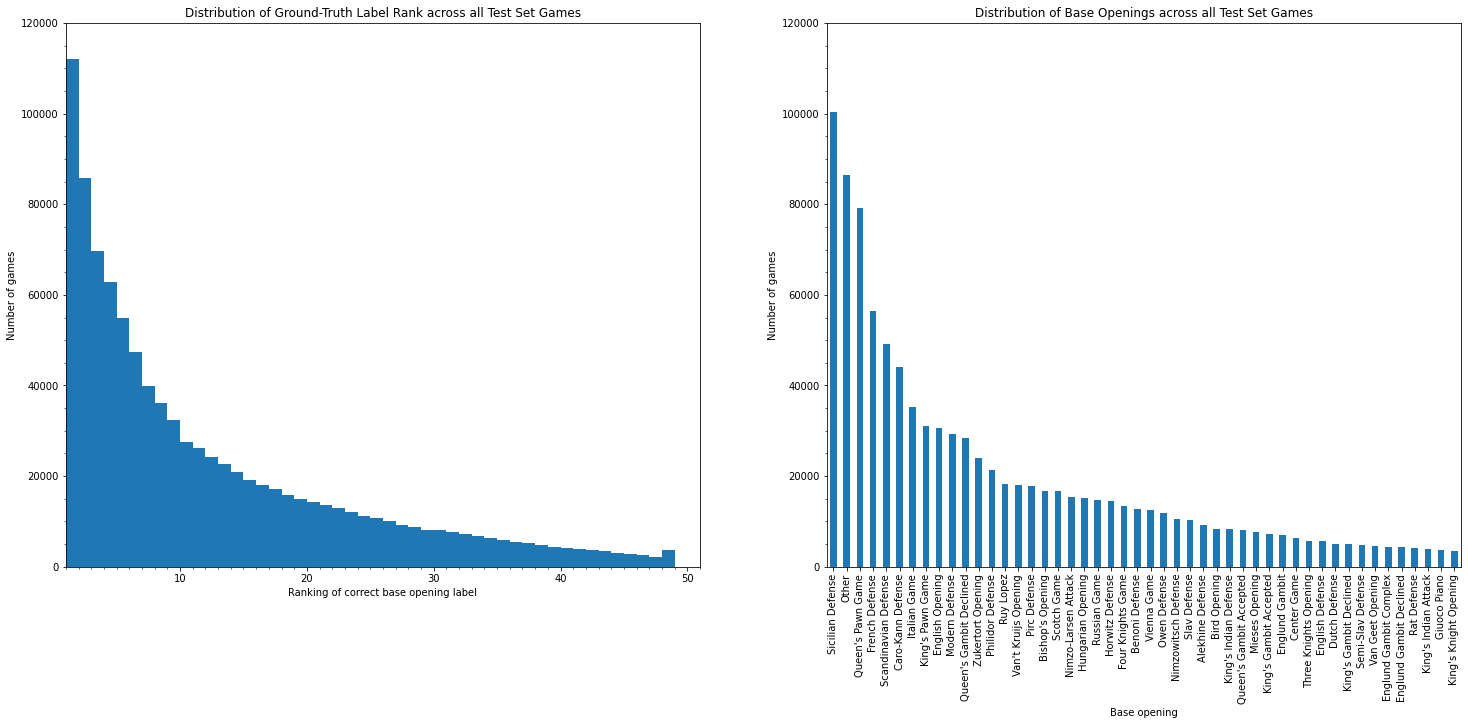

In [ ]:
bins = np.arange(50) #

fig, ax = plt.subplots(1, 2, figsize = (25, 10)) #Giant plots for language readability
ax[0].hist(opening_preds.pred_rank+1, bins=bins)
ax[0].set_xlabel("Ranking of correct base opening label")
ax[0].set_ylabel("Number of games")
ax[0].set_title("Distribution of Ground-Truth Label Rank across all Test Set Games")

opening_preds.label.value_counts().plot(kind='bar', ax=ax[1])
ax[1].set_xlabel("Base opening")
ax[1].set_ylabel("Number of games")
ax[1].set_title("Distribution of Base Openings across all Test Set Games")

#Beautifying
ax[0].set_xlim([1,51])
ax[0].set_ylim([0,120000])
ax[0].xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax[0].yaxis.set_minor_locator(ticker.MultipleLocator(5000))
ax[1].set_ylim([0,120000])
ax[1].yaxis.set_minor_locator(ticker.MultipleLocator(5000))

We can see from the the similarity in the distributions of base opening frequencies and ground-truth label rank that the model's top-k accuracy for any cutoff point *k* will not significantly outperform the naive top-k strategy of choosing opening "guesses" in descending order of frequency; again, our training strategy that did not take into account the class imbalance is likely a contributing factor. 

Instead of looking at all games, we can also examine the distributions of the rank of the correct label for games with specific openings to see if the model is better at predicting the more frequent openings versus the less frequent ones. 

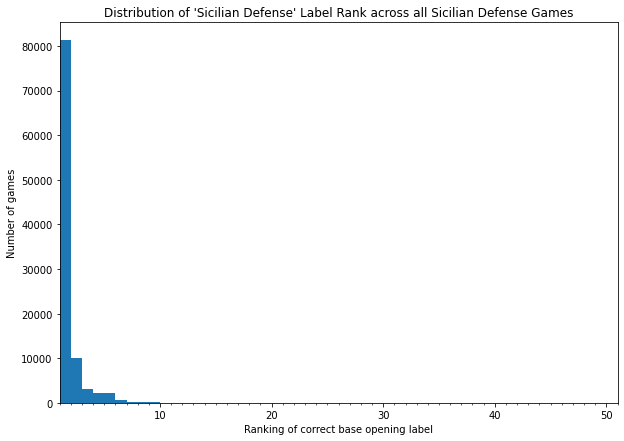

In [ ]:
sicilian = opening_preds.loc[opening_preds.label=='Sicilian Defense']

bins = np.arange(50) #

fig, ax = plt.subplots(figsize = (10, 7)) #Giant plots for language readability
ax.hist(sicilian.pred_rank+1, bins=bins)
ax.set_xlabel("Ranking of correct base opening label")
ax.set_ylabel("Number of games")
ax.set_title("Distribution of 'Sicilian Defense' Label Rank across \
all Sicilian Defense Games")

#Beautifying
ax.set_xlim([1,51])
#ax.set_ylim([0,120000])
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
#ax.yaxis.set_minor_locator(ticker.MultipleLocator(5000))

The most common base opening, the Sicilian Defense (found in about 100k games), is predicted correctly on the first "guess" of the model more than 80% of the time, and almost always within the top 5 guesses. 

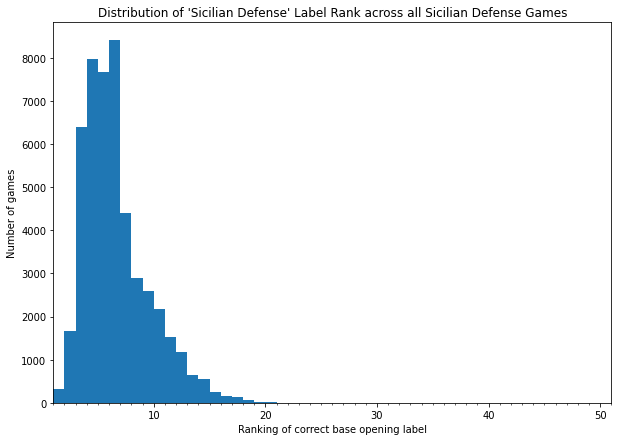

In [ ]:
scandi = opening_preds.loc[opening_preds.label=='Scandinavian Defense']

bins = np.arange(50) #

fig, ax = plt.subplots(figsize = (10, 7)) #Giant plots for language readability
ax.hist(scandi.pred_rank+1, bins=bins)
ax.set_xlabel("Ranking of correct base opening label")
ax.set_ylabel("Number of games")
ax.set_title("Distribution of 'Sicilian Defense' Label Rank across \
all Sicilian Defense Games")

#Beautifying
ax.set_xlim([1,51])
#ax.set_ylim([0,120000])
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
#ax.yaxis.set_minor_locator(ticker.MultipleLocator(5000))

For the fifth most popular opening, the Scandinavian Defense, the model guesses the correct opening on its first try in a very small number of games. Most of the time, it takes between 3 and 7 guesses for the model to correctly label the game, and a significant fraction of the time, it takes more than 10 guesses. 

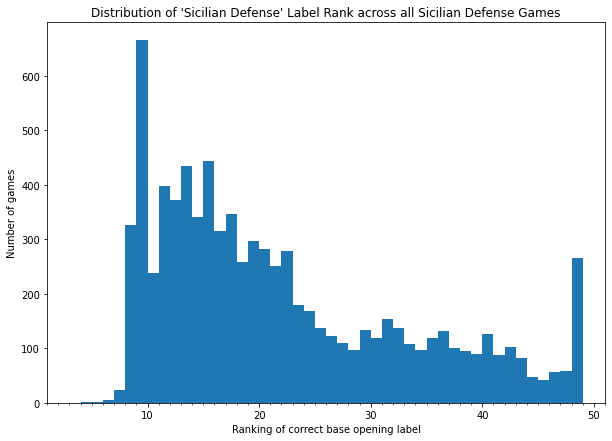

In [ ]:
kid = opening_preds.loc[opening_preds.label=="King's Indian Defense"]

bins = np.arange(50) #

fig, ax = plt.subplots(figsize = (10, 7)) #Giant plots for language readability
ax.hist(kid.pred_rank+1, bins=bins)
ax.set_xlabel("Ranking of correct base opening label")
ax.set_ylabel("Number of games")
ax.set_title("Distribution of 'Sicilian Defense' Label Rank across \
all Sicilian Defense Games")

#Beautifying
ax.set_xlim([1,51])
#ax.set_ylim([0,120000])
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
#ax.yaxis.set_minor_locator(ticker.MultipleLocator(5000))

For a far less popular opening - the King's Indian Defense - the model effectively never guesses the correct answer on the first try...or the second, or the third, or the fourth or the fifth. In fact, for games where the KID is played, the model ranks the correct opening as only the 10th through 20th most likely opening, but for a signfiicant number of games, the model effectively cannot beat a policy of random guessing agnostic of opening popularity (where the rank distribution would be centered around 25). 

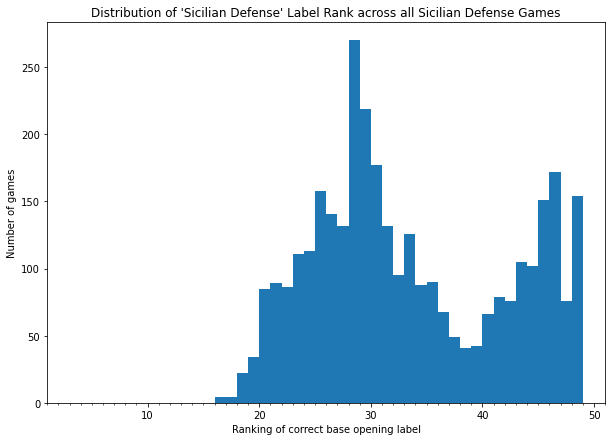

In [ ]:
KN = opening_preds.loc[opening_preds.label=="King's Knight Opening"]

bins = np.arange(50) #

fig, ax = plt.subplots(figsize = (10, 7)) #Giant plots for language readability
ax.hist(KN.pred_rank+1, bins=bins)
ax.set_xlabel("Ranking of correct base opening label")
ax.set_ylabel("Number of games")
ax.set_title("Distribution of 'Sicilian Defense' Label Rank across \
all Sicilian Defense Games")

#Beautifying
ax.set_xlim([1,51])
#ax.set_ylim([0,120000])
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
#ax.yaxis.set_minor_locator(ticker.MultipleLocator(5000))

For the least frequent of the base openings - the King's Knight Opening (which does not further transpose into a more common named opening like the Italian or the Ruy Lopez) - the model's performance is in fact worse than a frequency-naive random guessing policy (one way to conceptualize - without weighting openings by their prevalence in the game set, we draw opening names out of a hat at random, and stop when we have drawn the correct opening; the ordinal of this draw is the "rank" of our prediction), where the expected rank would be 25. Here, we see a bimodal distribution where both the mean and median game rank are clearly above 25, from which we conclude that our model has probably not learned anything from the features it was given that can help it predict the opening used. 

Now, let's see if, for the same types of games we were interested in above (Blitz and Bullet games of a certain rating range), the model performs any better at predicting openings than for the general set of all games. 

In [ ]:
#Condition: Blitz AND (WhiteElo between 1750,1900 OR BlackElo between 1750, 1900)
blitz_preds = opening_preds.loc[(opening_preds.time_control_type=='Blitz') & \
    (((opening_preds.WhiteElo <= 1900) & (opening_preds.WhiteElo >= 1750)) | \
     ((opening_preds.BlackElo <= 1900) & (opening_preds.BlackElo >= 1750)))]

#Condition: Bullet AND (WhiteElo between 1830,1950 OR BlackElo between 1830, 1950)
bullet_preds = opening_preds.loc[(opening_preds.time_control_type=='Bullet') & \
    (((opening_preds.WhiteElo <= 1950) & (opening_preds.WhiteElo >= 1830)) | \
     ((opening_preds.BlackElo <= 1950) & (opening_preds.BlackElo >= 1830)))]

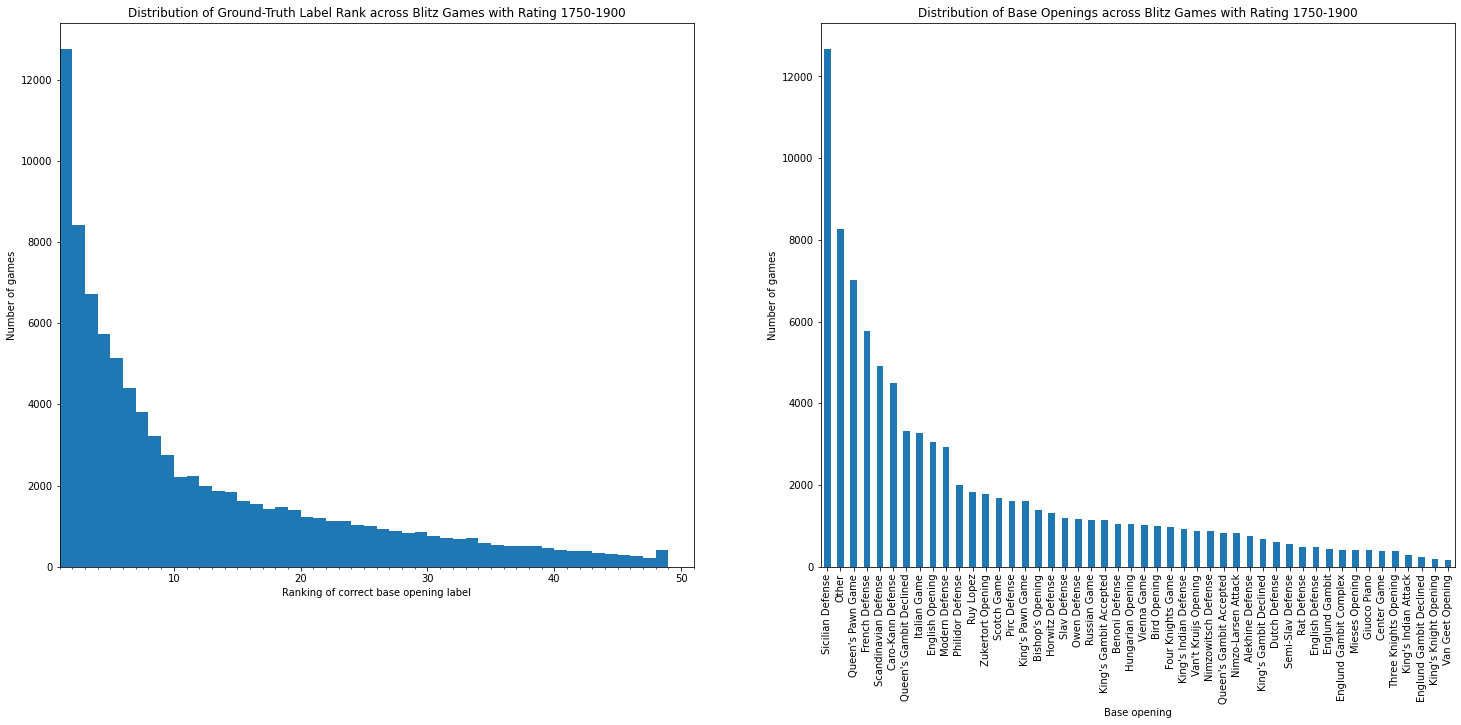

In [ ]:
bins = np.arange(50) #

fig, ax = plt.subplots(1, 2, figsize = (25, 10)) #Giant plots for language readability
ax[0].hist(blitz_preds.pred_rank+1, bins=bins)
ax[0].set_xlabel("Ranking of correct base opening label")
ax[0].set_ylabel("Number of games")
ax[0].set_title("Distribution of Ground-Truth Label Rank across Blitz Games with Rating 1750-1900")

blitz_preds.label.value_counts().plot(kind='bar', ax=ax[1])
ax[1].set_xlabel("Base opening")
ax[1].set_ylabel("Number of games")
ax[1].set_title("Distribution of Base Openings across Blitz Games with Rating 1750-1900")

# #Beautifying
ax[0].set_xlim([1,51])
# ax[0].set_ylim([0,120000])
ax[0].xaxis.set_minor_locator(ticker.MultipleLocator(1))
# ax[0].yaxis.set_minor_locator(ticker.MultipleLocator(5000))
# ax[1].set_ylim([0,120000])
# ax[1].yaxis.set_minor_locator(ticker.MultipleLocator(5000))

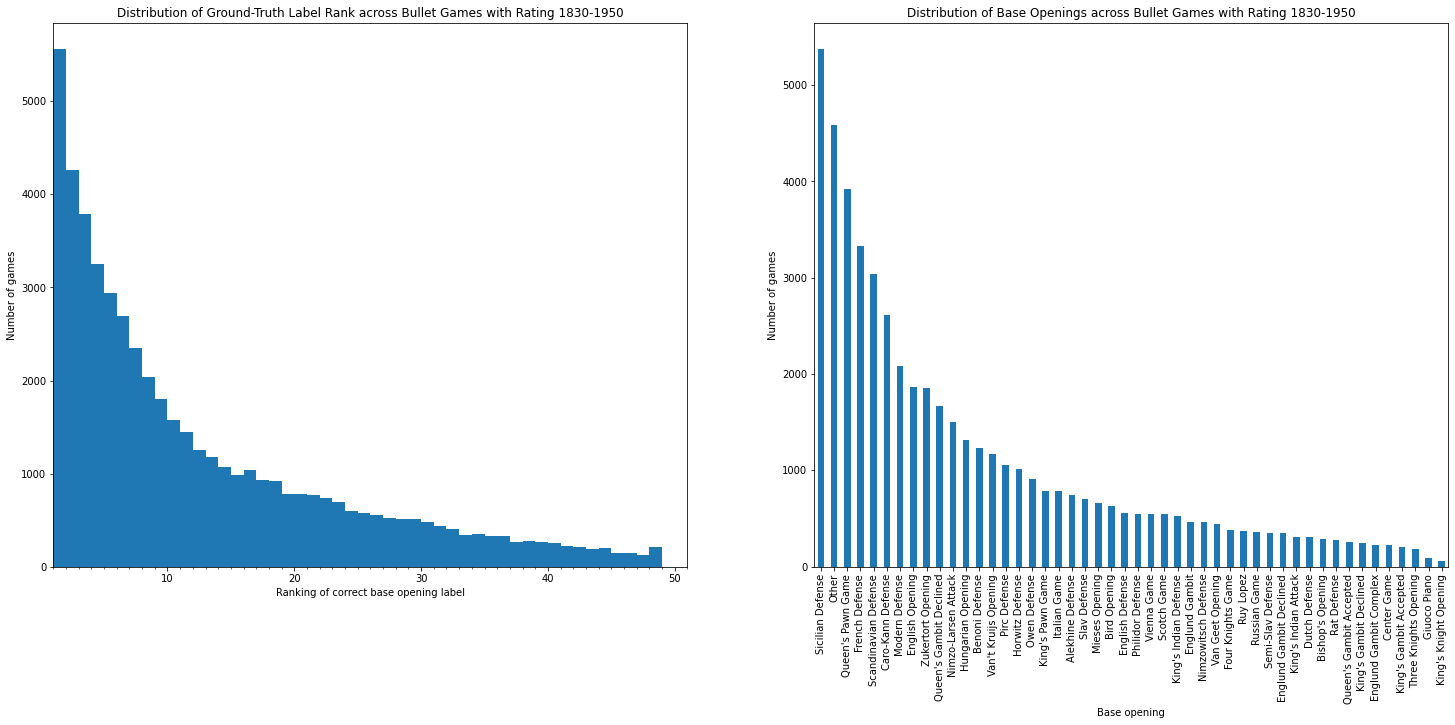

In [ ]:
bins = np.arange(50) #

fig, ax = plt.subplots(1, 2, figsize = (25, 10)) #Giant plots for language readability
ax[0].hist(bullet_preds.pred_rank+1, bins=bins)
ax[0].set_xlabel("Ranking of correct base opening label")
ax[0].set_ylabel("Number of games")
ax[0].set_title("Distribution of Ground-Truth Label Rank across Bullet Games with Rating 1830-1950")

bullet_preds.label.value_counts().plot(kind='bar', ax=ax[1])
ax[1].set_xlabel("Base opening")
ax[1].set_ylabel("Number of games")
ax[1].set_title("Distribution of Base Openings across Bullet Games with Rating 1830-1950")

# #Beautifying
ax[0].set_xlim([1,51])
# ax[0].set_ylim([0,120000])
ax[0].xaxis.set_minor_locator(ticker.MultipleLocator(1))
# ax[0].yaxis.set_minor_locator(ticker.MultipleLocator(5000))
# ax[1].set_ylim([0,120000])
# ax[1].yaxis.set_minor_locator(ticker.MultipleLocator(5000))

Once again, the distribution of correct label ranks across the subgroups of games I am most interested in clearly follows the distribution of actual opening frequencies in these types of games too - no clear advantage of the model operating under these time control/rating conditions. 

The last thing to try - how do the model's predictions look across titled games? 

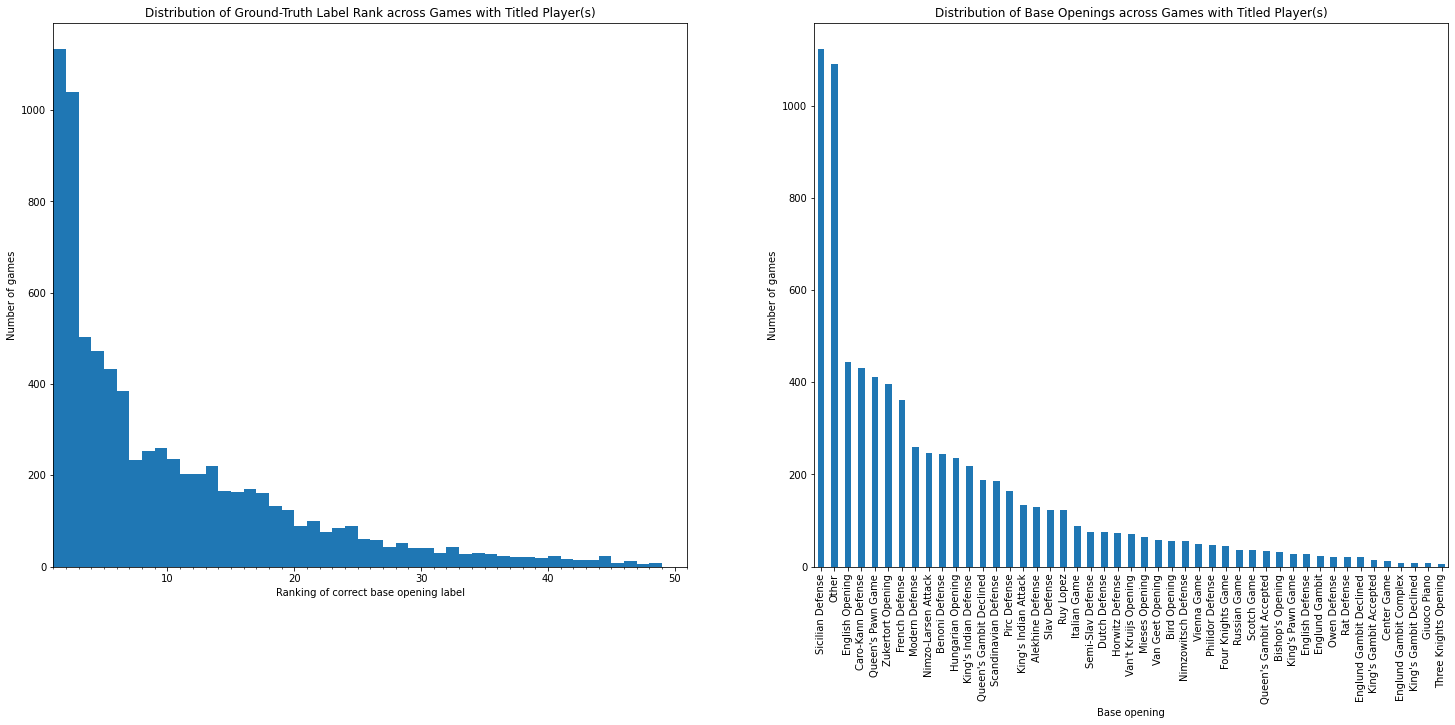

In [ ]:
#Condition: Either White or Black has a title that is not "BOT"
title_preds = opening_preds.loc[((~pd.isna(opening_preds.WhiteTitle)) & \
                            (opening_preds.WhiteTitle!='BOT')) | \
                           ((~pd.isna(opening_preds.BlackTitle)) \
                            & (opening_preds.BlackTitle!='BOT'))]

#Additional filter - neither White or Black has a title that is "BOT"
title_preds = title_preds.loc[(title_preds.WhiteTitle!='BOT') & \
                              (title_preds.BlackTitle!='BOT')]

bins = np.arange(50) #

fig, ax = plt.subplots(1, 2, figsize = (25, 10)) #Giant plots for language readability
ax[0].hist(title_preds.pred_rank+1, bins=bins)
ax[0].set_xlabel("Ranking of correct base opening label")
ax[0].set_ylabel("Number of games")
ax[0].set_title("Distribution of Ground-Truth Label Rank across Games with Titled Player(s)")

title_preds.label.value_counts().plot(kind='bar', ax=ax[1])
ax[1].set_xlabel("Base opening")
ax[1].set_ylabel("Number of games")
ax[1].set_title("Distribution of Base Openings across Games with Titled Player(s)")

# #Beautifying
ax[0].set_xlim([1,51])
# ax[0].set_ylim([0,120000])
ax[0].xaxis.set_minor_locator(ticker.MultipleLocator(1))

Our model's predictions, once again, almost exactly follow the highly imbalanced distributions of the dataset class-for-class. 

###Using models in practice

Somewhat disappointingly, our investigation into our models' predictive abilities revealed lots of shortcomings on our models - a heavy bias towards predicting White victory, a lack of sensitivity to draws, and predictions of openings that almost exactly mirror the distribution of openings in the dataset without providing additional insight. (We will discuss our model's issues and what we could have done to resolve them in the below section.)

In the meantime, assuming that our models did work well, how could we imagine using them to improve our strategy as players? Or, because chess is a creative game and does not exist in a vacuum, how can we still use the models as-is to get some additional inspiration to try approaching our games in a different way we might not have considered before? 

####Predicting the outcome of a game

I played the following rated game (Blitz, 5 minutes with no bonus time) on my phone - encountering a strong opponent rated 1866. As Black, I played my favorite Scandinavian Defense and gained a two-pawn advantage in the early endgame, pushing a pawn on the edge of the board which the opponent could not stop from promoting to a Queen, prompting a resignation on move 45. 

Of course I know the result of this game; however, given the information from the first 10 moves (at which point a chess engine gives White a sizeable, but not insurmountable, advantage) and the practical knowledge of my opponent, what does my model think are the chances of having observed the outcome (a Black victory)? 

To do so, let's upload a barebones, 1-line CSV table with the minimal game features for prediction to BigQuery! (I realized after the fact we can use aliasing to directly insert our data into the model without uploading a new table - let's call it a pedagogical exercise in using the BigQuery visual Console. ;) )

In [ ]:
###Table uploaded using visual Console for ease of use - we will query it now
%%bigquery my_game --project $project_id

SELECT
  label, predicted_label, predicted_label_probs
FROM
  ML.PREDICT(MODEL `cs145-f2022.project3.result_dnn_v4`, ( 
SELECT
  Result AS label,
  WhiteElo, BlackElo,
  WhiteTitle, BlackTitle,
  ECO, Opening,
  StartTime, Increment,
  TIME '23:35:00' AS UTCTime, --I entered the time as Pacific Time - correct here
  white_move1_timespent - white_move10_timespent AS w_time_used,
  black_move1_timespent - black_move10_timespent AS b_time_used,
  white_move1_move AS w1, black_move1_move AS b1,
  white_move2_move AS w2, black_move2_move AS b2,
  white_move3_move AS w3, black_move3_move AS b3,
  white_move4_move AS w4, black_move4_move AS b4,
  white_move5_move AS w5, black_move5_move AS b5,
  white_move6_move AS w6, black_move6_move AS b6,
  white_move7_move AS w7, black_move7_move AS b7,
  white_move8_move AS w8, black_move8_move AS b8,
  white_move9_move AS w9, black_move9_move AS b9,
  white_move10_move AS w10, black_move10_move AS b10
FROM
  `cs145-f2022.project3.taimanovspiano-result-prediction`))

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
my_game.predicted_label_probs.values

array([array([{'label': '1/2-1/2', 'prob': 0.04899587109684944},
              {'label': '1-0', 'prob': 0.506040096282959},
              {'label': '0-1', 'prob': 0.44496405124664307}], dtype=object)],
      dtype=object)

It turns out that the model would've probably bet against me if it could! Although we can't easily examine weights from a DNN classifier in the way that we could from a logistic classifier, we can do a quasi-sensitivity analysis to see how the model's prediction would change if my opponent and I rematched, with me now having gained some rating for beating a higher-rated opponent. 

In [ ]:
###Table uploaded using visual Console for ease of use - we will query it now
%%bigquery updated_ratings --project $project_id

SELECT
  label, predicted_label, predicted_label_probs
FROM
  ML.PREDICT(MODEL `cs145-f2022.project3.result_dnn_v4`, ( 
SELECT
  Result AS label,
  1860 AS WhiteElo, 1856 AS BlackElo,
  WhiteTitle, BlackTitle,
  ECO, Opening,
  StartTime, Increment,
  TIME '23:35:00' AS UTCTime,
  white_move1_timespent - white_move10_timespent AS w_time_used,
  black_move1_timespent - black_move10_timespent AS b_time_used,
  white_move1_move AS w1, black_move1_move AS b1,
  white_move2_move AS w2, black_move2_move AS b2,
  white_move3_move AS w3, black_move3_move AS b3,
  white_move4_move AS w4, black_move4_move AS b4,
  white_move5_move AS w5, black_move5_move AS b5,
  white_move6_move AS w6, black_move6_move AS b6,
  white_move7_move AS w7, black_move7_move AS b7,
  white_move8_move AS w8, black_move8_move AS b8,
  white_move9_move AS w9, black_move9_move AS b9,
  white_move10_move AS w10, black_move10_move AS b10
FROM
  `cs145-f2022.project3.taimanovspiano-result-prediction`))

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
updated_ratings.predicted_label_probs.values

array([array([{'label': '1/2-1/2', 'prob': 0.050076767802238464},
              {'label': '1-0', 'prob': 0.48835381865501404},
              {'label': '0-1', 'prob': 0.4615694284439087}], dtype=object)],
      dtype=object)

We can see that after our ratings have changed, the model now gives me a better chance of winning this game!

One more thing to investigate - my tenth move of the game (the last one before we stop counting move-level features) was 10...O-O, or castling kingside. However, the chess analysis engine on lichess suggests that this natural-looking move gives back a significant advantage to White, whereas playing 10...Bxf3 (taking White's kingside knight) would've kept the evaluation equal. Assuming I played the chess engine's top recommendation, does our result-prediction model we built here change its predictions significantly? (Let's try this out both with the original rating information from the start of this game, as well as the updated player ratings from after the game concluded). 

In [ ]:
###Table uploaded using visual Console for ease of use - we will query it now
%%bigquery engine_move --project $project_id

SELECT
  label, predicted_label, predicted_label_probs
FROM
  ML.PREDICT(MODEL `cs145-f2022.project3.result_dnn_v4`, ( 
SELECT
  Result AS label,
  WhiteElo, BlackElo,
  WhiteTitle, BlackTitle,
  ECO, Opening,
  StartTime, Increment,
  TIME '23:35:00' AS UTCTime,
  white_move1_timespent - white_move10_timespent AS w_time_used,
  black_move1_timespent - black_move10_timespent AS b_time_used,
  white_move1_move AS w1, black_move1_move AS b1,
  white_move2_move AS w2, black_move2_move AS b2,
  white_move3_move AS w3, black_move3_move AS b3,
  white_move4_move AS w4, black_move4_move AS b4,
  white_move5_move AS w5, black_move5_move AS b5,
  white_move6_move AS w6, black_move6_move AS b6,
  white_move7_move AS w7, black_move7_move AS b7,
  white_move8_move AS w8, black_move8_move AS b8,
  white_move9_move AS w9, black_move9_move AS b9,
  white_move10_move AS w10, 'g4f3' AS b10
FROM
  `cs145-f2022.project3.taimanovspiano-result-prediction`))

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
engine_move.predicted_label_probs.values

array([array([{'label': '1/2-1/2', 'prob': 0.051334481686353683},
              {'label': '1-0', 'prob': 0.5258918404579163},
              {'label': '0-1', 'prob': 0.42277365922927856}], dtype=object)],
      dtype=object)

In [ ]:
###Table uploaded using visual Console for ease of use - we will query it now
%%bigquery engine_move_upd_rat --project $project_id

SELECT
  label, predicted_label, predicted_label_probs
FROM
  ML.PREDICT(MODEL `cs145-f2022.project3.result_dnn_v4`, ( 
SELECT
  Result AS label,
  1860 AS WhiteElo, 1856 AS BlackElo,
  WhiteTitle, BlackTitle,
  ECO, Opening,
  StartTime, Increment,
  TIME '23:35:00' AS UTCTime,
  white_move1_timespent - white_move10_timespent AS w_time_used,
  black_move1_timespent - black_move10_timespent AS b_time_used,
  white_move1_move AS w1, black_move1_move AS b1,
  white_move2_move AS w2, black_move2_move AS b2,
  white_move3_move AS w3, black_move3_move AS b3,
  white_move4_move AS w4, black_move4_move AS b4,
  white_move5_move AS w5, black_move5_move AS b5,
  white_move6_move AS w6, black_move6_move AS b6,
  white_move7_move AS w7, black_move7_move AS b7,
  white_move8_move AS w8, black_move8_move AS b8,
  white_move9_move AS w9, black_move9_move AS b9,
  white_move10_move AS w10, 'g4f3' AS b10
FROM
  `cs145-f2022.project3.taimanovspiano-result-prediction`))

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
engine_move_upd_rat.predicted_label_probs.values

array([array([{'label': '1/2-1/2', 'prob': 0.050832610577344894},
              {'label': '1-0', 'prob': 0.5088469386100769},
              {'label': '0-1', 'prob': 0.44032055139541626}], dtype=object)],
      dtype=object)

Interestingly, our model's prediction of game result disagrees with the chess engine evaluation after 10...Bxf3, with the model predicting a significantly higher chance of a White victory in a game where it is played instead of 10...O-O (while the chess engine claims that Black should be able to hold a draw at least if not win much more easily). Although we don't have the time in this project to really compare result prediction model vs chess engine evaluations with any statistical rigor, this reveals an important difference in the two types of chess algorithms: one predicts the degree to which a "perfect" (or as good as we have for now!) chess player will have an advantage after a move, and the other predicts whether a real-life chess player with a known rating, in a given game condition, will have an advantage after the same move. With more time and resources, a refined version of our model could be very useful for quantifying the winning chances of players of certain ratings in a given position or choosing opening lines based on their practical utility, instead of some aloof engine calculation that no human could hope to emulate in actual (non-cheating) play. 

For example, imagine I had to play an advanced player rated 300 points higher than me, and both of us enjoy slugging it out in the Najdorf Variation of the Sicilian - one of the most popular, complex and theoretical chess openings which is still played by top-10 grandmasters in professional tournaments. Of the dozens of lines and plans, what should I choose? The lichess engine recommends White to go for the English Attack, an aggressive setup that includes the moves Be3, f3, Qd2, and O-O-O (in some order) followed by a kingside pawn storm; one possible line runs as follows:

1. e4 c5 
2. Nf3 d6 
3. d4 cxd4 
4. Nxd4 Nf6 
5. Nc3 a6 (the starting position of the Najdorf) 
6. f3 (the lichess engine prefers the pawn move first) e6 (Black adopts a Scheveningen-like setup) 
7. a3 (engine suggestion to prevent a Black pawn advance of ...b5...b4 or ...Nc6...Nb4 ideas) Nc6 
8. Be3 (the signature move of the English Attack) Be7 
9. Qd2 O-O (engine suggests 8...h5 but almost no human would play this, castles is far more common) 

and this position after 9 moves is evaluated at +0.7 for White; the lichess database states that of 999 games that have reached this position, White has won 52% and Black only 43%. 

How does our model evaluate my chances of winning this game?

In [ ]:
###English attack
%%bigquery english_attack --project $project_id

SELECT
  label, predicted_label, predicted_label_probs
FROM
  ML.PREDICT(MODEL `cs145-f2022.project3.result_dnn_v4`, ( 
SELECT
  Result AS label,
  1850 AS WhiteElo, 2150 AS BlackElo,
  WhiteTitle, BlackTitle,
  'B90' AS ECO, 'Sicilian Defense: Najdorf Variation' AS Opening,
  StartTime, Increment,
  TIME '23:35:00' AS UTCTime,
  10 AS w_time_used,
  10 AS b_time_used,
  'e2e4' AS w1, 'c7c5' AS b1,
  'g1f3' AS w2, 'd7d6' AS b2,
  'd2d4' AS w3, 'c5d4' AS b3,
  'f3d4' AS w4, 'g8f6' AS b4,
  'b1c3' AS w5, 'a7a6' AS b5,
  'f2f3' AS w6, 'e7e6' AS b6,
  'a2a3' AS w7, 'b8c6' AS b7,
  'c1e3' AS w8, 'f8e7' AS b8,
  'd1d2' AS w9, 'e8g8' AS b9,
  '' AS w10, '' AS b10
FROM
  `cs145-f2022.project3.taimanovspiano-result-prediction`))

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
english_attack.predicted_label_probs.values

array([array([{'label': '1/2-1/2', 'prob': 0.05045698583126068},
              {'label': '1-0', 'prob': 0.2285066843032837},
              {'label': '0-1', 'prob': 0.7210363149642944}], dtype=object)],
      dtype=object)

Not good! The lichess database doesn't take into account the fact that I'm merely a competitive casual player, whereas my opponent with their rating could be well on their way to a National Master title - the model predicts that given our strengths, if we were to play from the given position (at the same time of day, with our given ratings, etc.), Black would win more than 7 out of every 10 of these games. 

Instead of playing what the engine thinks is White's best option against the Najdorf, I could play more conservatively with the Opocensky or Classical Variation, which involves 6. Be2, a kingside castle, and attacking with the pawn break f4 to open up the kingside rook on f1. One line might look as follows: 

1. e4 c5 
2. Nf3 d6 
3. d4 cxd4 
4. Nxd4 Nf6 
5. Nc3 a6 (the starting position of the Najdorf) 
6. Be2 (Classical Variation) e5 (Black kicks the knight) 
7. Nb3 Be7 
8. O-O O-O (Although the engine recommends differently, short castles is the most common 8th move for both colors according to the database)
9. Be3 Be6

and the resulting position is evaluated at only +0.3 for White. Of the 35,843 games in the database that have reached this position, Black actually wins more (48%) than White (45%) - part of the reason why the Najdorf has historically been so popular!

However, what are MY odds, according to my model?

In [ ]:
###Classical variation
%%bigquery classical_var --project $project_id

SELECT
  label, predicted_label, predicted_label_probs
FROM
  ML.PREDICT(MODEL `cs145-f2022.project3.result_dnn_v4`, ( 
SELECT
  Result AS label,
  1850 AS WhiteElo, 2150 AS BlackElo,
  WhiteTitle, BlackTitle,
  'B92' AS ECO, 'Sicilian Defense: Najdorf Variation, Opocensky Variation, Traditional Line' AS Opening,
  StartTime, Increment,
  UTCTime,
  10 AS w_time_used,
  10 AS b_time_used,
  'e2e4' AS w1, 'c7c5' AS b1,
  'g1f3' AS w2, 'd7d6' AS b2,
  'd2d4' AS w3, 'c5d4' AS b3,
  'f3d4' AS w4, 'g8f6' AS b4,
  'b1c3' AS w5, 'a7a6' AS b5,
  'f1e2' AS w6, 'e7e5' AS b6,
  'd4b3' AS w7, 'f8e7' AS b7,
  'e1g1' AS w8, 'e8g8' AS b8,
  'c1e3' AS w9, 'c8e6' AS b9,
  '' AS w10, '' AS b10
FROM
  `cs145-f2022.project3.taimanovspiano-result-prediction`))

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
classical_var.predicted_label_probs.values

array([array([{'label': '1/2-1/2', 'prob': 0.07079434394836426},
              {'label': '1-0', 'prob': 0.24964539706707},
              {'label': '0-1', 'prob': 0.6795602440834045}], dtype=object)],
      dtype=object)

The model actually gives me (slightly) better odds playing a calmer Najdorf! Not only does the model predict about a 40% higher chance of holding a draw, but it also now estimates my probability of getting a win at about 25.0% versus just 22.9% were I to try the English Attack. Because an optimal chess engine's doesn't take into account players who don't always make the perfect moves, and the lichess database presents summary statistics of all games without breakdowns by individual player Elo, we would not have come to this conclusion without using big data techniques to infer personalized game result statistics. 

####Selecting an opening 

High on my confidence of the last win (with a new rating of 1856), I proceeded to play a new rated game (Blitz, 5 minutes with 3 seconds of bonus time) against a new opponent. I ran into a scary opponent, rated 1957 - the pure psychological pressure got to me and I instantly blundered a piece away. Very luckily for me, they didn't see it and I survived that test - but I still struggled to find a path forward as we slowly traded down to a complex endgame with three pawns, a knight and a bishop each, ultimately blundering and losing the game after 44 moves. 

Part of the psychological challenge was the fact that my opponent played a very offbeat opening to my 1. e4 (responding with 1...Nh6, unheard of at the top level and still very uncommon at all others), so I didn't have much theory to go off of in this game. Assuming I knew they would play a more mainstream defense, however, into what theoretical territory should I try to steer them to win? We'll pose this question to our model as follows - from our data, what openings are most like for games of this type where the White player actually wins? This might give me some insight into new lines I should study to improve my chances of holding my own against higher-rated players and even scoring a substantial upset win. 

In [ ]:
%%bigquery my_game_opening_pred --project $project_id

SELECT game.label AS base_opening, preds.label AS pred_opening, preds.prob
FROM (
  SELECT label, 
  ARRAY(SELECT x FROM UNNEST(predicted_label_probs) AS x ORDER BY prob DESC) 
    AS predicted_label_probs 
  FROM
    ML.PREDICT(MODEL `cs145-f2022.project3.opening_dnn_v1`, ( 
  SELECT
    Base_opening AS label,
    WhiteElo, BlackElo,
    WhiteTitle, BlackTitle,
    StartTime, Increment,
    UTCTime,
    white_move1_timespent - white_move10_timespent AS w_time_used,
    black_move1_timespent - black_move10_timespent AS b_time_used,
    Ply,
    '1-0' AS Result,
    Termination,
  FROM
    `cs145-f2022.project3.taimanovspiano-opening-prediction`))
) AS game,
UNNEST(predicted_label_probs) AS preds

Query is running:   0%|          |

Downloading:   0%|          |

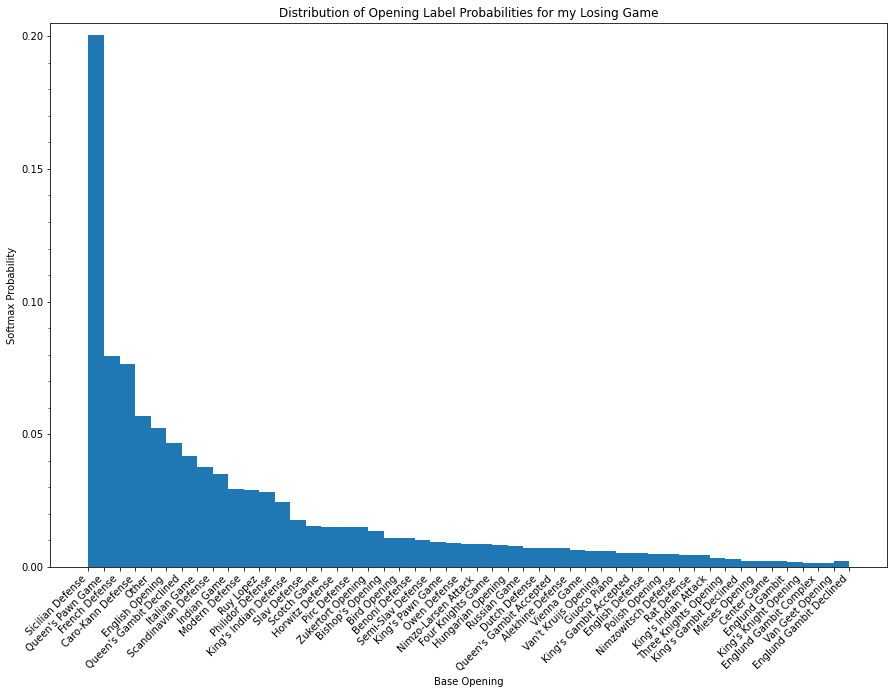

In [ ]:
bins = np.arange(50) #

fig, ax = plt.subplots(figsize = (15, 10)) #Giant plots for language readability
ax.hist(my_game_opening_pred.pred_opening, bins=bins, weights=my_game_opening_pred.prob)
ax.set_xlabel("Base Opening")
ax.set_ylabel("Softmax Probability")
ax.set_title("Distribution of Opening Label Probabilities for my Losing Game")

#Beautifying
ax.set_ylim([0,0.205])
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))

plt.xticks(rotation=45, ha='right');

Perhaps unsurprisingly, the model "recommends" (predicts) the Sicilian Defense in this situation, but resoundingly so - more so for this game than for many other subsets of games we've investigated thus far. Unfortunately, choosing to enter a Sicilian Defense, however favorable it might be for me (playing White in this game), is the decision of Black after 1. e4 (they must play 1...c5). We do notice, however, that most of the top openings listed are King's pawn openings (beginning with 1. e4), so as far as I know, I did everything I could that model would've recommended me - it was my opponent who took the game in a very different direction. 

Now, if we were to use this model prospectively - say I (as White) wanted to win against a lower-rated opponent in a short number of moves, and with such a ferocious attack that I caused my opponent to rage-quit the game. What openings would the model suggest are commonly associated with these outcomes?

In [ ]:
%%bigquery ragequit_pred --project $project_id

SELECT game.label AS base_opening, preds.label AS pred_opening, preds.prob
FROM (
  SELECT label, 
  ARRAY(SELECT x FROM UNNEST(predicted_label_probs) AS x ORDER BY prob DESC) 
    AS predicted_label_probs 
  FROM
    ML.PREDICT(MODEL `cs145-f2022.project3.opening_dnn_v1`, ( 
  SELECT
    Base_opening AS label,
    1850 AS WhiteElo, 1600 AS BlackElo,
    WhiteTitle, BlackTitle,
    300 AS StartTime, 0 AS Increment,
    UTCTime,
    15 AS w_time_used,
    25 AS b_time_used,
    30 AS Ply,
    '1-0' AS Result,
    'Abandoned' AS Termination,
  FROM
    `cs145-f2022.project3.taimanovspiano-opening-prediction`))
) AS game,
UNNEST(predicted_label_probs) AS preds

Query is running:   0%|          |

Downloading:   0%|          |

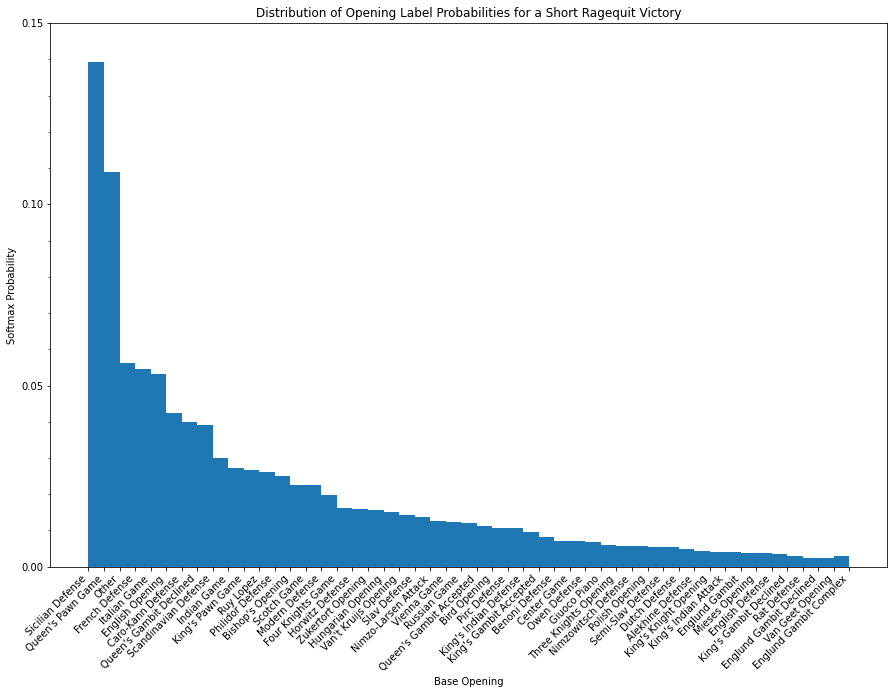

In [ ]:
fig, ax = plt.subplots(figsize = (15, 10)) #Giant plots for language readability
ax.hist(ragequit_pred.pred_opening, bins=bins, weights=ragequit_pred.prob)
ax.set_xlabel("Base Opening")
ax.set_ylabel("Softmax Probability")
ax.set_title("Distribution of Opening Label Probabilities for a Short Ragequit Victory")

#Beautifying
ax.set_ylim([0,0.15])
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))

plt.xticks(rotation=45, ha='right');

...according to the model, still just have to hope and pray for a Sicilian Defense, I guess. 

## Conclusions and Discussion

That was a lot of SQL, a lot of Pandas, and a lot of analysis! Ultimately, what did we learn (besides the basics of how to think about working at scale)? 

###Overall findings 

Many of our findings from the exploratory query section recapitulated or corroborated trends that were either already known or expected in the chess community, especially online; most of our "surprises" pertained to specific subgroups of games or players, or concerned the magnitude of trends. Some highlights:

* While there is a first-move advantage at almost all rating levels, it is most pronounced in games with the *highest* average ratings and least pronounced amongst the games with the *lowest* average ratings. Why might that be, if chess is a theoretical draw? One explanation is that at the very lowest levels, players "squander" the first-move advantage very quickly because they have no idea how to utilize it or that it exists; their moves quickly yield positionally chaotic games that offer chances for both colors. At the theoretical optimum of chess, the opposite phenomenon would lead to draws; although White will press for advantage at every move, Black has perfect konwledge of how to counter it, and the game reaches the theoretical conclusion. Some possible reasonings for why games with a peak average human rating might see such a high bias towards White might be a confounding influence of time control, or the fact that attacking chess (which is more likely to be White's strategy, given the first-move advantage) is *practically* much easier to play than defensive chess, a role oftentimes taken on by or forced onto Black. 
* Black is more likely to be the winner of a game ending in abandonment, and White is more likely to be the winner of a game that ends over the board (by checkmate or resignation). Both colors are about equally likely to win (or lose) on time. 
* One of the best time formats to play to beat a substantially higher-rated player is Ultrabullet; the best is Correspondence. The latter is easy to explain - when there is a whole day or perhaps no time limit to consider a move, both players have a lot more time to analyze deeply and play better - or covertly cheat. The former is less intuitive, but there's still a reasonable explanation: survive for just long enough to make all of the moves quickly and flag the opponent (a common term used in online chess to describe deliberately making fast moves with the intent of forcing the opponnent to lose on time). In the fastest chess time formats, getting moves out is just as important to victory, if not more so, than the objective evaluation of the board position. What's the worst time format (in terms of frequency of substantial upset wins)? Interestingly enough...Bullet. This suggests that there's some set of Goldilocks time controls at which both players feel the pressure to move quickly, but the higher-rated player then has enough time to really punish the highly inferior moves that the lower-rated player must make to not lose on time. As the time control grows shorter, both players lose calculation ability; as the time control grows longer, the lower-rated player has the ability to calculate more and can hold their own a bit better against their opponent. 
* The engine move is not always the best move to play! While it may seem counterintuitive to a game theoretician or a grandmaster, our (admittedly highly-flawed) model identifies some situations where top engine lines are predicted to win with lower probability than older, more solid openings, or even straight-up "bad" moves. Many chess YouTubers and instructors talk about this phenomenon in terms of "causing complications" - even if there is a way to punish such a suboptimal move or strategy, the refutation may be difficult to find or calculate, leaving winning opportunities for the "suboptimal" player on the clock or in the opponent's head. World Chess Champion Mikhail Tal was famous for employing brilliant, beautiful sacrifices and coy smiles at his opponents over the board; even if computers could easy counter his tactics, the fear of becoming immortalized as another victim of Tal's often caused opponents to misevaluate the position and, in fact, lose the game when they had the advantage. The real surprise is the degree to which a choice of variation can impact the game's outcome - in some cases, boosting the likelihood of a draw against a higher-rated opponent by almost half! 

Despite our headline findings, our project is deeply imperfect across many facets of its technical implementation; addressing these in a future iteration of this project while increasing the number of games analyzed by one or two orders of magnitude could make for some potentially very interesting - even marketable - chess insights. Let's talk about these below.

###Preprocessing, Schema and Query Design

####Preprocessing


One of the key difficulties in this project was having to process the data into a tabular form before we could even analyze it - games were available in PGN notation only. As a result, we had to make some pretty binding choices very early on about which features we were even going to give ourselves the *option* of analyzing, without much time or computing credit to make revisions. This led to some pretty egregious mistakes - for example, the realization too late that our boolean feature for checking if a board evaluation gave the number of moves until checkmate (as opposed to centipawn evaluation) was almost universally marked as TRUE, rendering all of our evaluation features useless; or the realization that features named `timespent` actually indicated the time *remaining* on a player's clock instead of the amount of time used between when a player made consecutive moves. It's not clear if these issues arose while writing the Python preprocessing script or performing the upload of tables to BigQuery while defining a schema in another Python script (another problem that caused lots of issues). Another challenge centered around deciding when to pre-process features - for example, splitting the `TimeControl` attribute into `StartTime` and `Increment`, which could either be done using the `.apply()` method in Pandas DataFrames, or using `ALTER TABLE`, `ADD COLUMN` and `SET` operators in BigQuery SQL; eventually, we ended up doing both for different attributes at various stages in the analysis and model-building process. And then, of course, there was the issue of how much of each game to extract from the PGN files. More moves, more information - but also bulkier models with longer train, and potentially more costly table storage and queries. 

In future iterations of this project, we would definitely spend more time experimenting with a small compressed PGN file with a few hundred to thousand games to iron out all of the kinks in our preprocessing pipeline. Using this small dataset, we could more effectively time various actions in Python and in SQL to get a better idea of where to stage our feature engineering operations without needing to wait hours or spend big chunks of compute credits to get our answers. We might also consider writing our own functions to parse through the PGN file as opposed to relying on the Python `chess` module, which, while convenient, probably cost lots of unnecessary time and memory creating rich descriptions of the game state which we ultimately did not need (i.e. game trees), and also automatically transformed some features into less informative representations (i.e. the moves, which were converted out of algebraic notation into `[STARTING_SQUARE][ENDING_SQUARE]`, which potentially removed information about which piece was being moved). With additional prep time, we could have also parsed through a greater number of games or sampled games across more months, giving us a more diverse distribution of data to work with too.  

####Table schema

Throughout this project, we worked primarily with a single megatable on which we ran all of our queries and built our machine learning models; the models were evaluated on a second table, slightly smaller but with effectively the exact same structure. The megatable had some definite advantages, in that none of our queries involved `JOIN` operations; however, the disadvantages were definitely more noticeable. Just from a readability standpoint, 100+ columns is...a lot. In our defense, we built these tables and ran most of our queries and ML models before the course material reached the topics of good schema design, but we definitely felt the need to decompose the table long before we reached the corresponding lectures and even identified some logical decompositions we could have feasibly employed. 

How, then, might we think about breaking up the large table into useful smaller ones? Firstly, we should recognize that the `Site` attribute is a primary key for each game - or at least the final part of the URL following `https://lichess.org/`. This can be used to reference information for a given game across multiple tables. I think the first sub-table to be split off could be called `player-info`, where for each game, we store White and Black usernames and their titles at the time of playing the game. With enough game history (and a static schema), we could then create a table of `players` with username (as primary key - the only table without `Site` as a primary key), number of games played, win rates, average Elos for various time controls, etc. - all features we would have to engineer out of our aggregate data which we did not do in this project. Another useful sub-table might be something like `game-info` - this would include when the game was played (date and time - with the `Date` column removed in favor of `UTCDate`), time controls, whether it was played in a tournament, who won, mybe how the players' Elos changed as a result, the game's termination condition, number of moves, etc. And finally, we could create a table called `moves`, which might be another valid place to store the number of moves played in a game; instead of being a monster table with potentially hundreds of columns (one per ply per player), we could maybe create an attribute that is an `ARRAY` of `STRUCT`s - each `STRUCT` would have the move number (`INT`), player (could even be `BOOL` if not a single-character `STRING` for "W"/"B"), move in algebraic notation (`STRING`), clock time or time spent on a move (`FLOAT`), if position has a forced mate (`BOOL`) and evaluation as either number of moves until forced mate or centipawn advantage (`INT` or `FLOAT`). This would be a very neat way of storing our movelists with their relevant annotations without having a column explosion like we experienced; however, this would require more delicate querying and model-building (with potentially extra layers of queries to handle the `UNNEST` operators).

###Model-building, Feature Engineering and Training

Although we were unimpressed with our models' performances, we were not particularly surprised that they weren't giving stellar results. The primary issue we identified in this process was just the lack of very strong, obvious trends across the axes of variation in our limited feature set that might lend themselves well to exploitation by an ML algorithm; simply adding data is unlikely to fix the problem, and might in fact make it worse (without careful dataset construction) by a "drowning out" effect. Some other issues we encountered included the significant overlap of certain features (namely `ECO` and `Opening`; however, also the reaching of the same opening position through different unique move orders) and the loss of potentially very useful features through sloppy preprocessing. 

A few ideas for fixes or improvements in future iterations: 

####Feature engineering:



* Including user-level features. As mentioned above in the schema design section, perhaps we could get information about a user's presence in the database from a relevant table or engineer the features - number of games played, date of first game played, preference for time controls, average length of games played? This information might not always be available, but may be useful for personalizing predictions to an even greater degree. 
* Including more move-level features - ideally for the entire game, and with evaluations and clock times for each move (where available). In particular, evaluations are *so* important as a way of creating a single numerical representation of a board position, over which a tabular ML model can operate very effectively (as compared to the billion-parameter deep reinforcement models needed to understand the board); in general, the strategy of using another model's output as the input to a downstream model is very common in the ML world, and we should leverage that more here instead of relying on our puny 3- or 4-layer networks to try and parse through the millions of unique movesets that arise as early as move 6 or 7. This will help save our model from having to work with thousands of categorial variables for each unique move, and it can really focus more effort on handling an objective evaluation of a position alongside the information about the game conditions. All games after April 2017 have clock times; about 6% of games across the database have evaluations, so it might be useful to include games with and without these specific attributes so the model can learn how to operate with various levels of information. 
* Better representations for opening strategy! `ECO` and English-named `Opening` attributes are a mess for machine learning use with tremendous overlap, nested hierarchies, class imbalance, and more. One idea in a similar vein to what was mentioned above might be to develop a deeper, chess-specific network that produces rich representations of games in various opening states, and then run unsupervised clustering on these representations to identify types of opening positions that may be more useful for an ML perspective (as opposed to human study, like `ECO`). The benefit of classifying openings this way besides reducing overlap is that this process should hopefully better capture positional/tactical themes of openings that are invariant to specific move orders or subvariations, and may be more practically useful for opening preparation where a player's opponent does not make the exact moves that a player prepared for (the player has many options of moves that eventually yield a position with desired characteristics).

####Dataset restructuring:

* Fix class imbalance in openings! Ignoring the issues of whether games receive an informative opening label or not, models will have a hard time learning if over 50% of games are given one of only a small subset of opening labels, yet there are hundreds of potential labels in the dataset (some of which may apply to only a tiny handful of games!). Assuming we have good opening labels, one way to fix this would be to create weights for our loss function which penalize wrong predictions proportionate to the frequency of the label in the dataset; another option would be to subsample our data until all of our opening labels are of roughly equal frequency. The latter option might actually become feasible with large enough amounts of data, although we will be throwing away lots of good data too. 

* Fix class imbalance in game results! Similar to the above problem, we noticed that our game result classifier sucks at sensitivity when it comes to draws, and prefers to predict White victory. To fix this, we can apply the above tricks of weighting our loss function or training on an even balance of results; the latter option isn't too awful here, considering that draws represent about 4% of games and getting an equal number of White and Black victories yields a training set of about 12% the size of our original dataset (which could still be tens of millions of games). 

####Model-building and training:

* Choosing the best model for use - it might not be a deep neural network! Although neural networks are all the rage these days, they tend to underperform (relative to expectations, at least) on organized tabular data compared to many tree-based methods; however, I was less experienced with the latter, so I did choose to implement DNN classifiers for this project. In future iterations, I would be open to other model architectures as well, or at the very least trying something like a recurrent network to operate over move-level features. 
* Systematic hyperparameter selection - we sort of chose our learning rates, epoch numbers and layer count without any rhyme or reason, just using qualitative heuristics (which sounds so much better than "plug and chug" or "try things that look nice"). Applying a more consistent methodology to choose our model architecture and hyperparameters might help us optimize its performance, although it likely won't make up for having uninformative features or biased data. 


###Future Directions

Now that we have identified several axes of improvement to this exploratory project, where do we go from here? A few ideas (some of which we might capitalize on in future class projects!):

* Bigger data. Although we were limited by time and credit constraints, we were still able to get our hands on over 10 million games for this project which already started to provide some interesting insights across a diversity of positions -  ranging from likely some users' first games of chess ever to longstanding grandmaster rivalries. By implementing the more readable and compact schemas and decompositions described above, we can easily 10x the number of games while keeping the costs of simple queries down, which may help us uncover more subtle trends that we could have missed with our preliminary exporation. 
* Pipeline design. In this course, SQL and BigQuery were learning objectives in their own right; however, in the real world, they are often just parts (albeit very important ones) of a much more complex data ecosystem, and can be a jumping-off point for loading data into more sophisticated schemes that won't run in the BigQuery interface. We might consider slimming down our schemas and operating with our tables entirely in Python for future projects, keeping only relevant game representations and passing them along to an outside model. 

And as a sneak peek of what such an outside model might be: 

* Transformer representations of games: For CS 224N, I (Bowen) am considering following up on the idea of using Transformer models to build representations of chess games - although it's not a perfect fit for these types of models, one way to think of a chess game is as a sequence of board states, where the board can be represented as a small 8x8 array. Across billions of games in the full database, we could try to train a Transformer model with conditional tags using some common language modeling autoregressive techniques, like next-move or next-position prediction, with the goal of teaching the model to learn good representations for games played at various Elo ratings (most likely the strongest covariate). (Another idea might be to try contrastive- or BERT-like learning objectives where a model is given two positions and told to predict if they represent consecutive moves; or if a model is given multiple positions several moves apart and is told to predict how many moves apart they are.) We can then feed the model a set of moves, generate the representation of the game, and perform clustering on these representations to see along what axes the model chooses to classify openings; we can then investigate commonalities in the positions of games falling into certain clusters and try to interpret them in human strategic terms. Another idea might be to try something like a trajectory inference for the representations of consecutive positions of a game to see if the model is able to create definitions for what human players would classify as the opening, middlegame or endgame phases of a chess game. If used for generative purposes with ELO as a continuous conditioning parameter, this model might also become a very useful tool for rating-aware move prediction. A chess engine called Maia has been developed to play games in this way, but its multiple versions are each trained on only 12 million games in 100-Elo steps between 1100 and 1900; a Transformer model with conditioning tags might be able to better process the relationship between Elo and the position on the board, especially if sparse information from an optimal computer engine could be appended somehow. For a model like this, having well-organized and functional data pipelines is essential, and a good SQL backend would go a long way to making it easy to train, store and analyze these lare models and their outputs! 

Thanks for making a great iteration of this course - it's been an honor and lots of fun to work on this project!